In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta 
from sklearn.preprocessing import StandardScaler

## Load Dataset 

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
dataset.describe()

Timestep         Volt       Rotate     Pressure    Vibration  \
count  3000.000000  3000.000000  3000.000000  3000.000000  3000.000000   
mean   1499.500000     0.373067     0.618286     0.228649     0.262340   
std     866.169729     0.059924     0.074675     0.062273     0.071261   
min       0.000000     0.205925     0.087729     0.089105     0.137005   
25%     749.750000     0.339570     0.608941     0.200876     0.227192   
50%    1499.500000     0.363052     0.634062     0.218191     0.249273   
75%    2249.250000     0.388709     0.657018     0.235343     0.272689   
max    2999.000000     0.849701     0.838351     0.739828     0.781317   

             State  
count  3000.000000  
mean      1.670333  
std       1.305458  
min       0.000000  
25%       1.000000  
50%       2.000000  
75%       3.000000  
max       5.000000

## Data exploration

In [4]:
volt = np.array(dataset['Volt'].tolist()).transpose()
rotate = np.array(dataset['Rotate'].tolist()).transpose()
pressure = np.array(dataset['Pressure'].tolist()).transpose()
vibration = np.array(dataset['Vibration'].tolist()).transpose()
state = np.array(dataset['State'].tolist()).transpose()

Observe distribution of feature values 

Text(0.5, 1.0, 'Volt')

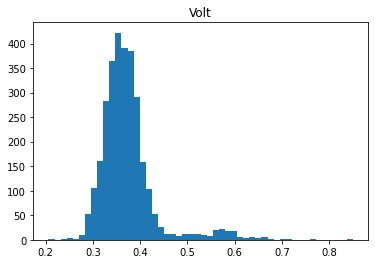

In [5]:
plt.hist(volt, bins=50)
plt.title('Volt')

Text(0.5, 1.0, 'Rotate')

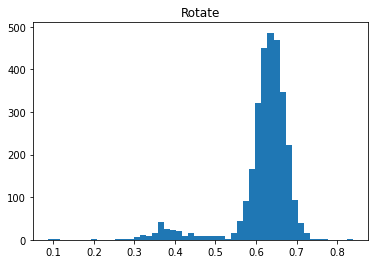

In [6]:
plt.hist(rotate, bins=50)
plt.title('Rotate')

Text(0.5, 1.0, 'Pressure')

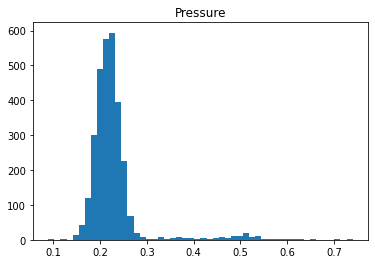

In [7]:
plt.hist(pressure, bins=50)
plt.title('Pressure')

Text(0.5, 1.0, 'Vibration')

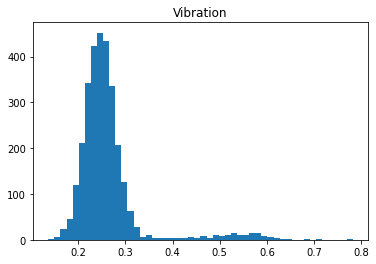

In [8]:
plt.hist(vibration, bins=50)
plt.title('Vibration')

Observe correlation of feature values

Text(0.5, 1.0, 'Correlation Heatmap')

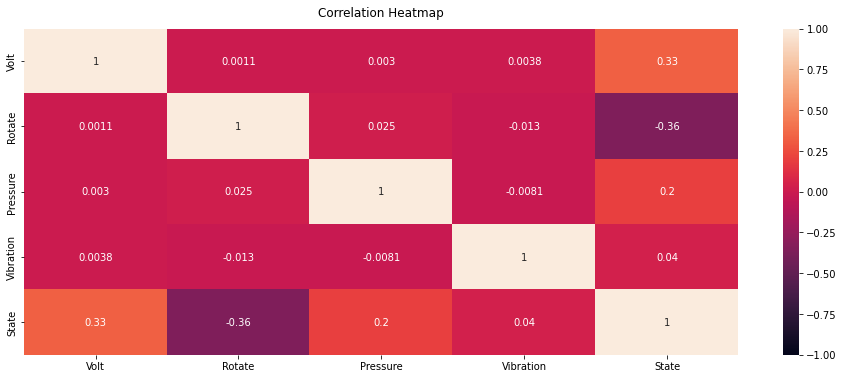

In [9]:
notimeDf = dataset.drop(columns=['Timestep'])
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(notimeDf.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

Observe variation of feature values over time

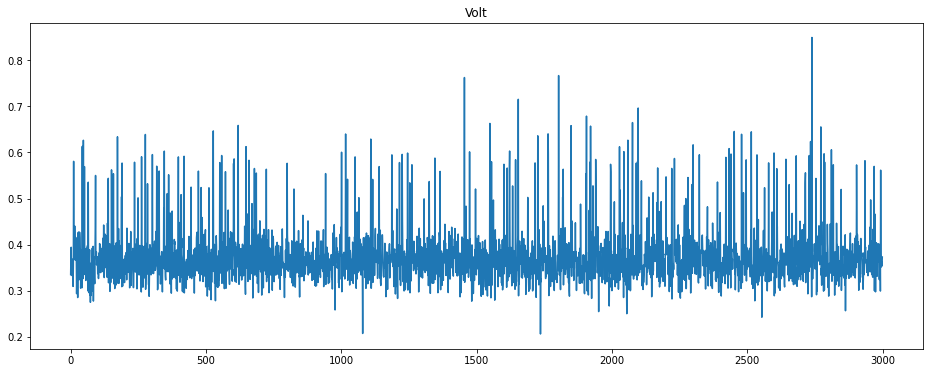

In [10]:
plt.figure(figsize=(16, 6))
plt.plot(volt)
plt.title('Volt')
plt.show()

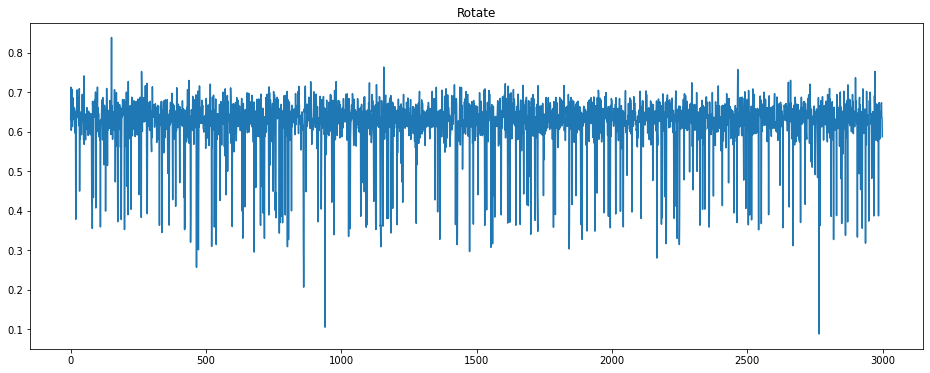

In [11]:
plt.figure(figsize=(16, 6))
plt.plot(rotate)
plt.title('Rotate')
plt.show()

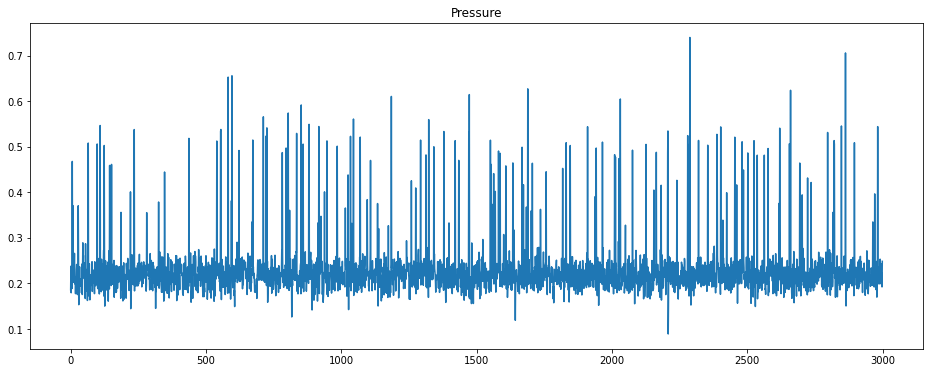

In [12]:
plt.figure(figsize=(16, 6))
plt.plot(pressure)
plt.title('Pressure')
plt.show()

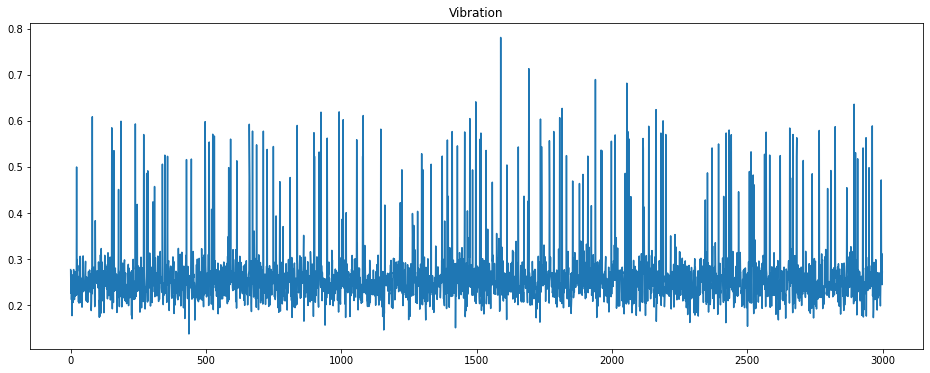

In [13]:
plt.figure(figsize=(16, 6))
plt.plot(vibration)
plt.title('Vibration')
plt.show()

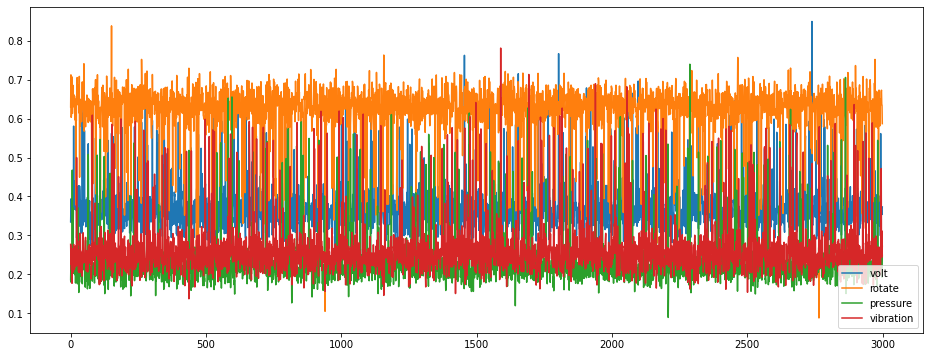

In [14]:
plt.figure(figsize=(16, 6))
plt.plot(volt)
plt.plot(rotate)
plt.plot(pressure)
plt.plot(vibration)
plt.legend(['volt', 'rotate', 'pressure', 'vibration'], loc="lower right")
plt.show()

## Data Cleaning

Check for any null or missing values. 

In [15]:
dataset.isnull()

Timestep   Volt  Rotate  Pressure  Vibration  State
0        False  False   False     False      False  False
1        False  False   False     False      False  False
2        False  False   False     False      False  False
3        False  False   False     False      False  False
4        False  False   False     False      False  False
...        ...    ...     ...       ...        ...    ...
2995     False  False   False     False      False  False
2996     False  False   False     False      False  False
2997     False  False   False     False      False  False
2998     False  False   False     False      False  False
2999     False  False   False     False      False  False

[3000 rows x 6 columns]

In [16]:
dataset.isnull().sum()

Timestep     0
Volt         0
Rotate       0
Pressure     0
Vibration    0
State        0
dtype: int64

There are no null values in the dataset. Smoothing and scaling will not be used here since the sensor readings are already scaled when generated. Smoothing is not used here as each sensor reading belongs to a particular state and taking moving averages for smoothing may not be appropriate. 

# Anomaly Detection

Prepare dataset

In [17]:
#Remove timestep and states from data
featuresDf = dataset.drop(columns=['Timestep', 'State'])

Set aside 20% of data for validation and 20% for test.

In [18]:
numReadings = len(featuresDf)
numTrain = int(0.6*numReadings)
numVal = int(0.2*numReadings)
train_dataset = featuresDf[0:numTrain]
val_dataset = featuresDf[numTrain:numTrain+numVal]
test_dataset = featuresDf[numTrain+numVal:]

#print number of readings in each set
print("number of readings in training set %d" % len(train_dataset))
print("number of readings in validation set %d" % len(val_dataset))
print("number of readings in test set %d" % len(test_dataset))

number of readings in training set 1800
number of readings in validation set 600
number of readings in test set 600


In [19]:
train_dataset

Volt    Rotate  Pressure  Vibration
0     0.335098  0.630101  0.186233   0.276855
1     0.377602  0.712434  0.237875   0.225342
2     0.394153  0.603349  0.179491   0.273827
3     0.333236  0.608902  0.217711   0.211595
4     0.349643  0.707796  0.209827   0.245194
...        ...       ...       ...        ...
1795  0.333090  0.608943  0.251035   0.224175
1796  0.336812  0.644161  0.205314   0.275966
1797  0.317805  0.673133  0.197640   0.195530
1798  0.361077  0.645488  0.230087   0.231396
1799  0.376732  0.615243  0.228609   0.271004

[1800 rows x 4 columns]

In [20]:
train_arr = train_dataset.to_numpy()
val_arr = val_dataset.to_numpy()
test_arr = test_dataset.to_numpy()

In [21]:
train_arr

array([[0.33509766, 0.63010127, 0.18623335, 0.27685491],
       [0.37760199, 0.7124338 , 0.23787507, 0.22534167],
       [0.3941534 , 0.60334937, 0.179491  , 0.27382719],
       ...,
       [0.3178046 , 0.67313302, 0.19764045, 0.19552994],
       [0.36107695, 0.64548752, 0.23008712, 0.23139641],
       [0.37673239, 0.61524341, 0.22860863, 0.27100364]])

Detect anomalies with PyOD

In [22]:
def viewOutliers(clf):
    #training set
    y_train_scores = clf.decision_scores_
    plt.hist(y_train_scores, bins='auto') 
    plt.title("Histogram for training set anomaly scores")
    plt.show()
    
    #validation set
    y_val_scores = clf.decision_function(val_arr)  # outlier scores
    y_val_scores = pd.Series(y_val_scores)
    plt.hist(y_val_scores, bins='auto') 
    plt.title("Histogram for validation set anomaly scores")
    plt.show()
    
    #test set
    y_test_scores = clf.decision_function(test_arr)  # outlier scores
    y_test_scores = pd.Series(y_test_scores)
    plt.hist(y_test_scores, bins='auto') 
    plt.title("Histogram for test set anomaly scores")
    plt.show()

Calculate percentage of outliers. Approximate number of outliers as number of extreme failure points. 

In [23]:
statelist = dataset['State'].tolist()
train_statelist = statelist[0:numTrain]
total_num = len(train_statelist)
failure_states = [i for i in train_statelist if i > 3]
failure_num = len(failure_states)
outlier_ratio = failure_num/total_num
print("Estimated percentage of outliers %f" % outlier_ratio)

Estimated percentage of outliers 0.082778


1. Principal Component Analysis

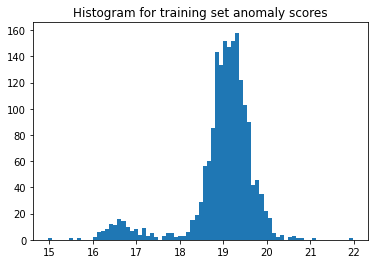

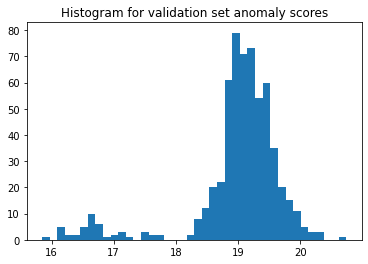

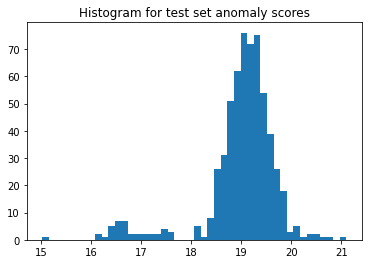

In [143]:
from pyod.models.pca import PCA
clf1 = PCA(random_state=42, standardization=False, contamination=outlier_ratio)
clf1.fit(train_arr)
viewOutliers(clf1)

2. One class support vector machine

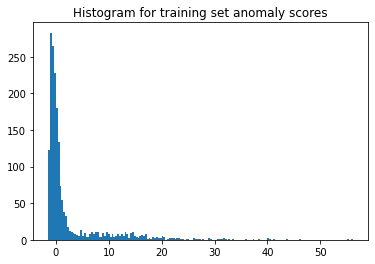

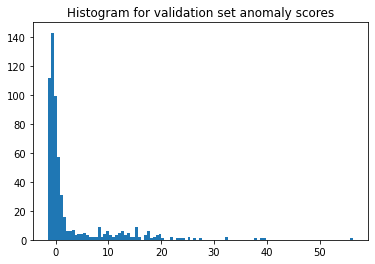

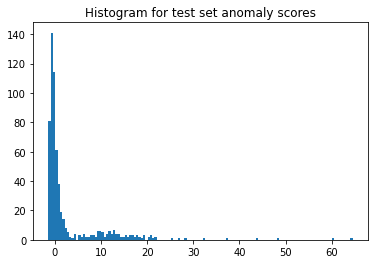

In [144]:
from pyod.models.ocsvm import OCSVM
clf2 = OCSVM(contamination=outlier_ratio)
clf2.fit(train_arr)
viewOutliers(clf2)

3. Deviation based outlier detection

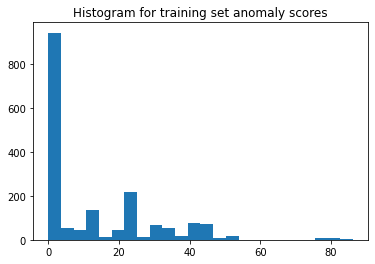

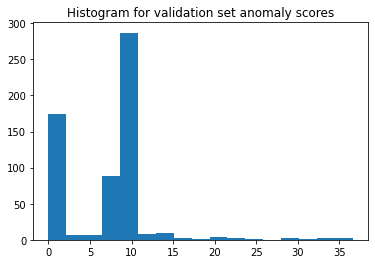

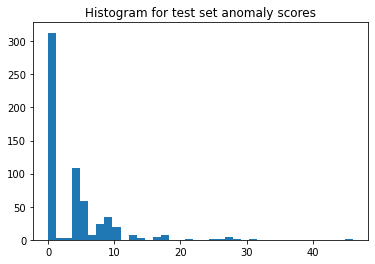

In [145]:
from pyod.models.lmdd import LMDD
clf3 = LMDD(n_iter=100, random_state=42, contamination=outlier_ratio)
clf3.fit(train_arr)
viewOutliers(clf3)

4. Local Outlier Factor

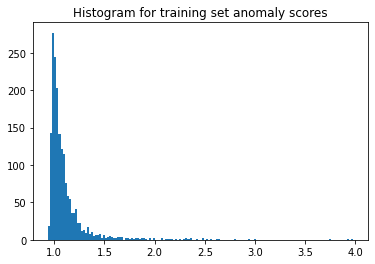

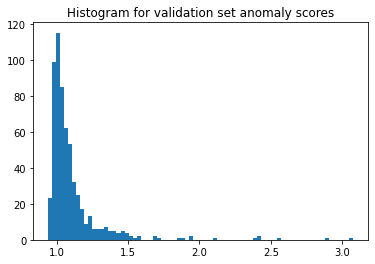

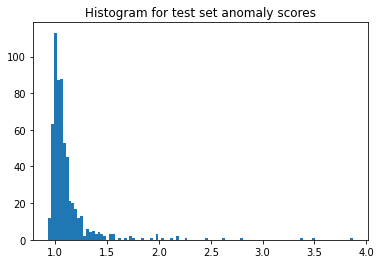

In [146]:
from pyod.models.lof import LOF
clf4 = LOF(contamination=outlier_ratio)
clf4.fit(train_arr)
viewOutliers(clf4)

5. Connectivity based outlier factor

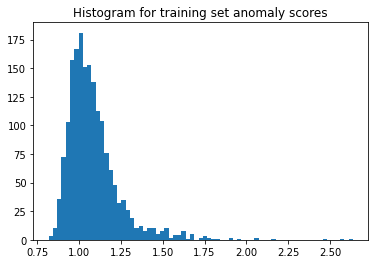

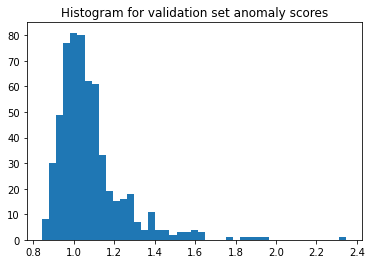

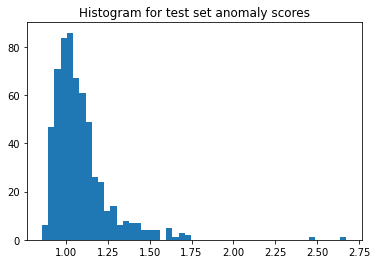

In [147]:
from pyod.models.cof import COF 
clf5 = COF(contamination=outlier_ratio)
clf5.fit(train_arr)
viewOutliers(clf5)

6. Clustering based local outlier factor

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


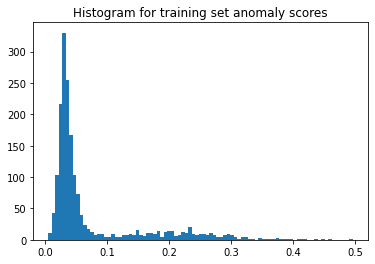

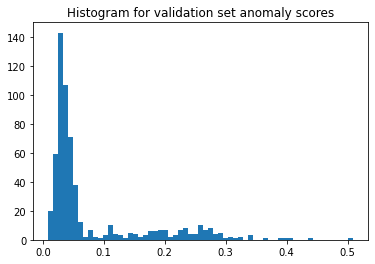

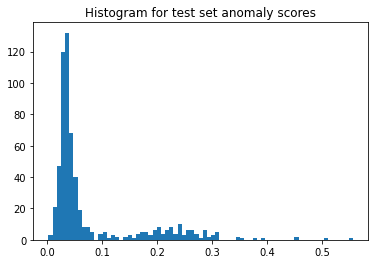

In [148]:
from pyod.models.cblof import CBLOF
clf6 = CBLOF(n_clusters=20, alpha=0.75, random_state=42, contamination=outlier_ratio)
clf6.fit(train_arr)
viewOutliers(clf6)

7. Histogram based outlier score

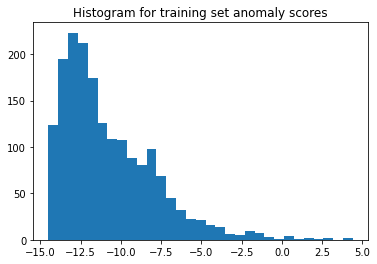

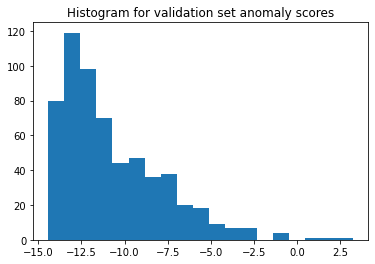

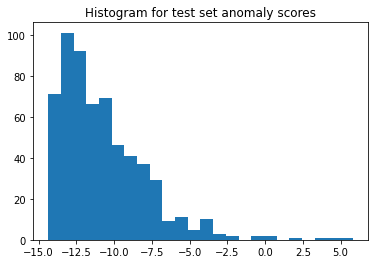

In [149]:
from pyod.models.hbos import HBOS
clf8 = HBOS(n_bins=60, contamination=outlier_ratio)
clf8.fit(train_arr)
viewOutliers(clf8)

8. KNN

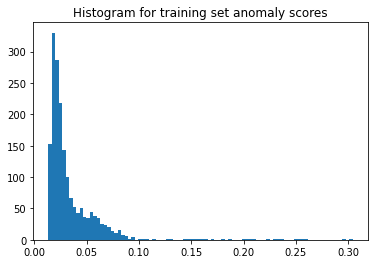

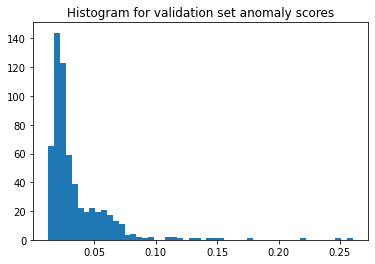

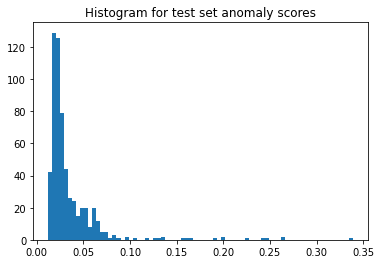

In [150]:
from pyod.models.knn import KNN
clf9 = KNN(n_neighbors=20, method='median', contamination=outlier_ratio)
clf9.fit(train_arr)
viewOutliers(clf9)

9. Subspace outlier detection

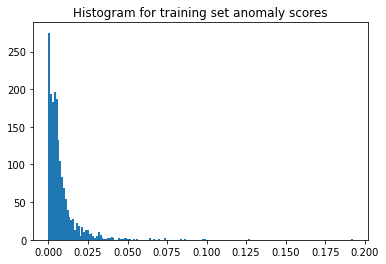

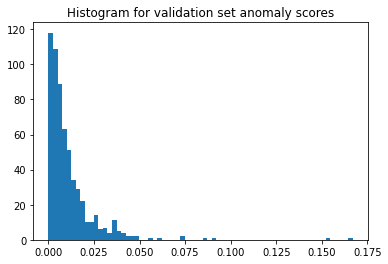

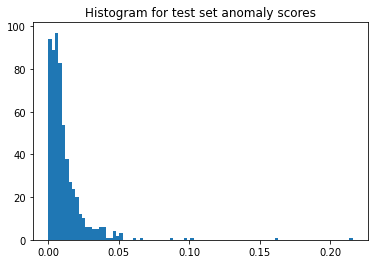

In [151]:
from pyod.models.sod import SOD
clf10 = SOD(contamination=outlier_ratio)
clf10.fit(train_arr)
viewOutliers(clf10)

10. Rotation-based Outlier Detection

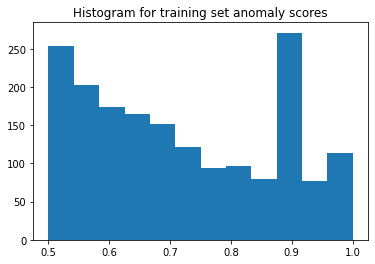

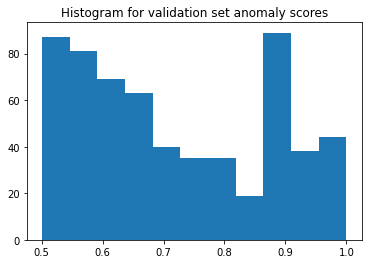

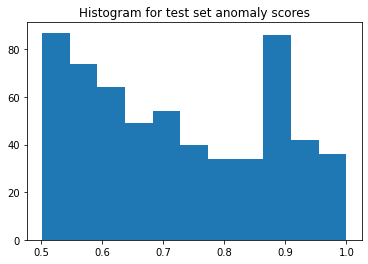

In [152]:
from pyod.models.rod import ROD
clf11 = ROD(contamination=outlier_ratio)
clf11.fit(train_arr)
viewOutliers(clf11)

11. Stochastic outlier selection

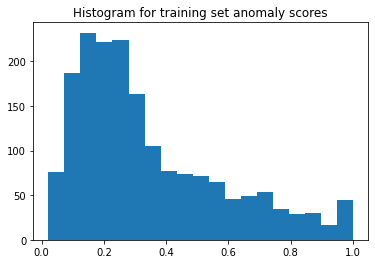

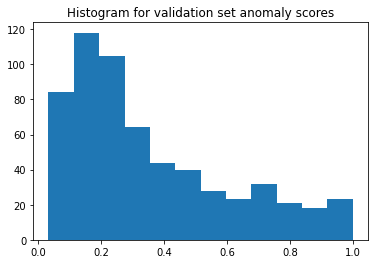

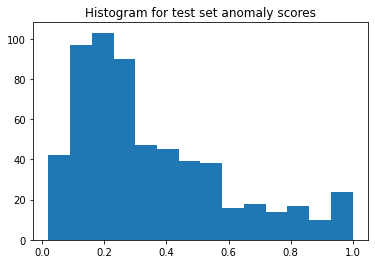

In [153]:
from pyod.models.sos import SOS
clf14 = SOS(contamination=outlier_ratio)
clf14.fit(train_arr)
viewOutliers(clf14)

12. Isolation forest

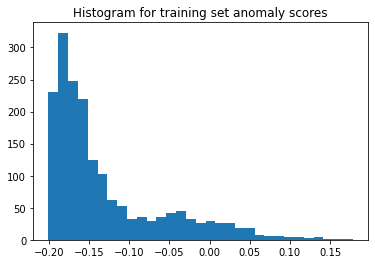

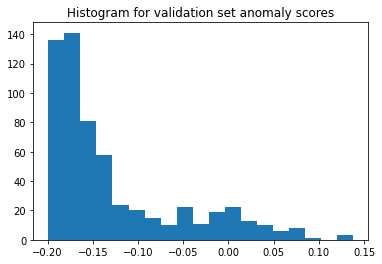

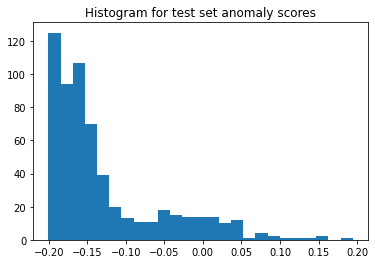

In [154]:
from pyod.models.iforest import IForest
clf15 = IForest(bootstrap=True, random_state=42, contamination=outlier_ratio)
clf15.fit(train_arr)
viewOutliers(clf15)

13. Autoencoders

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_30 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_106 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_31 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_107 (Dense)            (None, 64)                320       
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 32)              

51/51 [==============================] - 0s 3ms/step - loss: 1.0195 - val_loss: 0.8722
Epoch 133/150
51/51 [==============================] - 0s 3ms/step - loss: 1.0194 - val_loss: 0.8714
Epoch 134/150
51/51 [==============================] - 0s 3ms/step - loss: 1.0195 - val_loss: 0.8722
Epoch 135/150
51/51 [==============================] - 0s 3ms/step - loss: 1.0196 - val_loss: 0.8715
Epoch 136/150
51/51 [==============================] - 0s 3ms/step - loss: 1.0193 - val_loss: 0.8713
Epoch 137/150
51/51 [==============================] - 0s 4ms/step - loss: 1.0192 - val_loss: 0.8711
Epoch 138/150
51/51 [==============================] - 0s 3ms/step - loss: 1.0194 - val_loss: 0.8714
Epoch 139/150
51/51 [==============================] - 0s 3ms/step - loss: 1.0190 - val_loss: 0.8712
Epoch 140/150
51/51 [==============================] - 0s 3ms/step - loss: 1.0189 - val_loss: 0.8716
Epoch 141/150
51/51 [==============================] - 0s 3ms/step - loss: 1.0191 - val_loss: 0.8720
Epoc

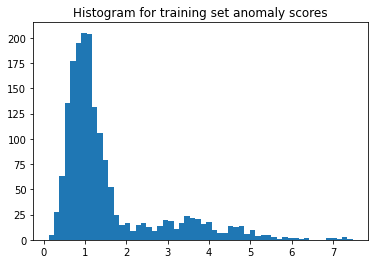

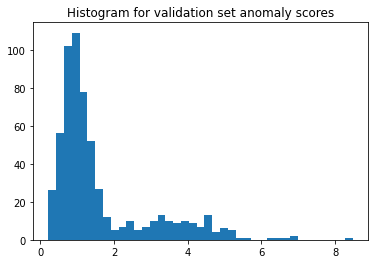

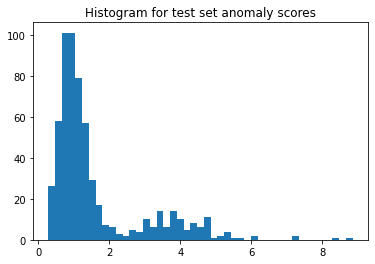

In [155]:
from pyod.models.auto_encoder import AutoEncoder
clf16 = AutoEncoder(hidden_neurons=[64,32,16,4,4,16,32,64], epochs=150, random_state=42, contamination=outlier_ratio)
clf16.fit(train_arr)
viewOutliers(clf16)

14. Copula Based Outlier Detector

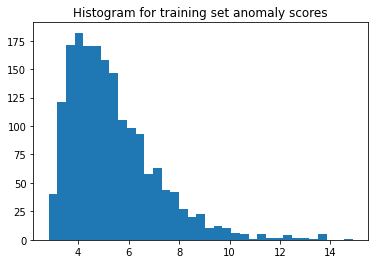

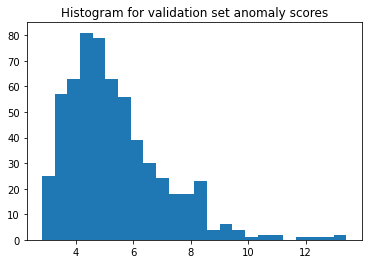

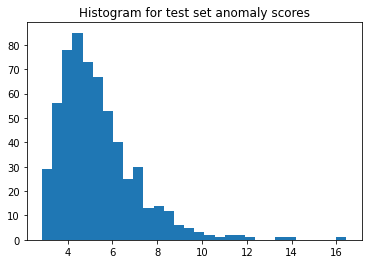

In [156]:
from pyod.models.copod import COPOD 
clf17 = COPOD(contamination=outlier_ratio)
clf17.fit(train_arr)
viewOutliers(clf17)

15. DeepSVDD

Model: "model_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_117 (Dense)            (None, 64)                320       
_________________________________________________________________
net_output (Dense)           (None, 32)                2080      
_________________________________________________________________
tf.math.subtract_7 (TFOpLamb (None, 32)                0         
_________________________________________________________________
tf.math.pow_7 (TFOpLambda)   (None, 32)                0         
_________________________________________________________________
tf.math.reduce_sum_7 (TFOpLa (None,)                   0         
_________________________________________________________________
tf.math.reduce_mean_7 (TFOpL ()                        0  

51/51 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0537
Epoch 149/150
51/51 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0537
Epoch 150/150
51/51 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0537


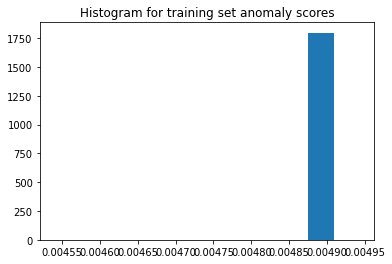

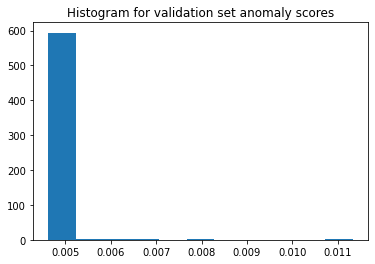

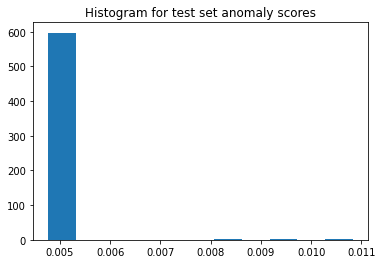

In [157]:
from pyod.models.deep_svdd import DeepSVDD
clf18 = DeepSVDD(epochs=150, random_state=42, contamination=outlier_ratio)
clf18.fit(train_arr)
viewOutliers(clf18)

16. Multi-Objective Generative Adversarial Active Learning

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1 of 150

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:
Epoch 2 of 150

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:
Epoch 3 of 150

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:
Epoch 4 of 150

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 index 3:
Epoch 5 of 150

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:

Testing for epoch 5 index 3:
Epoch 6 of 150

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:

Testing for epoch 6 index 3:
Epoch 7 of 150

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:

Testing for epoch 7 index 3:
Epoch 8 of 150

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:

Testing for epoch 8 index 3:
Epoch 9 of 150

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:

Testing for epoch 9 index 3:
Epoch 10 of 150

Testing for epoch 10 index 1:

Testing

16/16 [==============================] - 0s 800us/step - loss: 0.7064

Testing for epoch 56 index 2:
16/16 [==============================] - 0s 935us/step - loss: 0.7079

Testing for epoch 56 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7104
Epoch 57 of 150

Testing for epoch 57 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7076

Testing for epoch 57 index 2:
16/16 [==============================] - 0s 867us/step - loss: 0.7102

Testing for epoch 57 index 3:
16/16 [==============================] - 0s 849us/step - loss: 0.7076
Epoch 58 of 150

Testing for epoch 58 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7090

Testing for epoch 58 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7092

Testing for epoch 58 index 3:
16/16 [==============================] - 0s 933us/step - loss: 0.7093
Epoch 59 of 150

Testing for epoch 59 index 1:
16/16 [==============================] - 0s 885us/s

16/16 [==============================] - 0s 1ms/step - loss: 0.7098
Epoch 64 of 150

Testing for epoch 64 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7092

Testing for epoch 64 index 2:
16/16 [==============================] - 0s 987us/step - loss: 0.7076

Testing for epoch 64 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7087
Epoch 65 of 150

Testing for epoch 65 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 0.7068

Testing for epoch 65 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7110

Testing for epoch 65 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7081
Epoch 66 of 150

Testing for epoch 66 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7077

Testing for epoch 66 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7090

Testing for epoch 66 index 3:
16/16 [==============================] - 0s 1ms/step - l

16/16 [==============================] - 0s 1ms/step - loss: 0.7132

Testing for epoch 71 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7105

Testing for epoch 71 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7128
Epoch 72 of 150

Testing for epoch 72 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.7127

Testing for epoch 72 index 2:
16/16 [==============================] - 0s 969us/step - loss: 0.7092

Testing for epoch 72 index 3:
16/16 [==============================] - 0s 879us/step - loss: 0.7112
Epoch 73 of 150

Testing for epoch 73 index 1:
16/16 [==============================] - 0s 998us/step - loss: 0.7122

Testing for epoch 73 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7110

Testing for epoch 73 index 3:
16/16 [==============================] - 0s 933us/step - loss: 0.7085
Epoch 74 of 150

Testing for epoch 74 index 1:
16/16 [==============================] - 0s 971us/s

16/16 [==============================] - 0s 866us/step - loss: 0.7151

Testing for epoch 78 index 3:
16/16 [==============================] - 0s 800us/step - loss: 0.7135
Epoch 79 of 150

Testing for epoch 79 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7150

Testing for epoch 79 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7133

Testing for epoch 79 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 0.7138
Epoch 80 of 150

Testing for epoch 80 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7151

Testing for epoch 80 index 2:
16/16 [==============================] - 0s 956us/step - loss: 0.7157

Testing for epoch 80 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7131
Epoch 81 of 150

Testing for epoch 81 index 1:
16/16 [==============================] - 0s 923us/step - loss: 0.7169

Testing for epoch 81 index 2:
16/16 [==============================] - 0s 866us/

16/16 [==============================] - 0s 933us/step - loss: 0.7112

Testing for epoch 82 index 2:
16/16 [==============================] - 0s 950us/step - loss: 0.7142

Testing for epoch 82 index 3:
16/16 [==============================] - 0s 914us/step - loss: 0.7154
Epoch 83 of 150

Testing for epoch 83 index 1:
16/16 [==============================] - 0s 870us/step - loss: 0.7167

Testing for epoch 83 index 2:
16/16 [==============================] - 0s 946us/step - loss: 0.7162

Testing for epoch 83 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7147
Epoch 84 of 150

Testing for epoch 84 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7119

Testing for epoch 84 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7151

Testing for epoch 84 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7173
Epoch 85 of 150

Testing for epoch 85 index 1:
16/16 [==============================] - 0s 1ms/ste

16/16 [==============================] - 0s 1ms/step - loss: 0.7188

Testing for epoch 86 index 2:
16/16 [==============================] - 0s 868us/step - loss: 0.7142

Testing for epoch 86 index 3:
16/16 [==============================] - 0s 867us/step - loss: 0.7188
Epoch 87 of 150

Testing for epoch 87 index 1:
16/16 [==============================] - 0s 951us/step - loss: 0.7163

Testing for epoch 87 index 2:
16/16 [==============================] - ETA: 0s - loss: 0.724 - 0s 922us/step - loss: 0.7210

Testing for epoch 87 index 3:
16/16 [==============================] - 0s 867us/step - loss: 0.7159
Epoch 88 of 150

Testing for epoch 88 index 1:
16/16 [==============================] - 0s 869us/step - loss: 0.7153

Testing for epoch 88 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7141

Testing for epoch 88 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7210
Epoch 89 of 150

Testing for epoch 89 index 1:
16/16 [==================

16/16 [==============================] - 0s 1ms/step - loss: 0.7164

Testing for epoch 93 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7215
Epoch 94 of 150

Testing for epoch 94 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7171

Testing for epoch 94 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.7193

Testing for epoch 94 index 3:
16/16 [==============================] - 0s 934us/step - loss: 0.7208
Epoch 95 of 150

Testing for epoch 95 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.7207

Testing for epoch 95 index 2:
16/16 [==============================] - 0s 886us/step - loss: 0.7223

Testing for epoch 95 index 3:
16/16 [==============================] - 0s 933us/step - loss: 0.7204
Epoch 96 of 150

Testing for epoch 96 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7237

Testing for epoch 96 index 2:
16/16 [==============================] - 0s 952us/s

16/16 [==============================] - 0s 973us/step - loss: 0.7228
Epoch 101 of 150

Testing for epoch 101 index 1:
16/16 [==============================] - 0s 957us/step - loss: 0.7226

Testing for epoch 101 index 2:
16/16 [==============================] - 0s 886us/step - loss: 0.7233

Testing for epoch 101 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7231
Epoch 102 of 150

Testing for epoch 102 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7199

Testing for epoch 102 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7218

Testing for epoch 102 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7242
Epoch 103 of 150

Testing for epoch 103 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7239

Testing for epoch 103 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7262

Testing for epoch 103 index 3:
16/16 [==============================] - 0s

16/16 [==============================] - 0s 1ms/step - loss: 0.7238

Testing for epoch 108 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7285
Epoch 109 of 150

Testing for epoch 109 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7290

Testing for epoch 109 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7280

Testing for epoch 109 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7242
Epoch 110 of 150

Testing for epoch 110 index 1:
16/16 [==============================] - 0s 950us/step - loss: 0.7324

Testing for epoch 110 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.7275

Testing for epoch 110 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7280
Epoch 111 of 150

Testing for epoch 111 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7301

Testing for epoch 111 index 2:
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 1ms/step - loss: 0.7303
Epoch 116 of 150

Testing for epoch 116 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 0.7271

Testing for epoch 116 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7269

Testing for epoch 116 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7366
Epoch 117 of 150

Testing for epoch 117 index 1:
16/16 [==============================] - 0s 869us/step - loss: 0.7303

Testing for epoch 117 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.7322

Testing for epoch 117 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7298
Epoch 118 of 150

Testing for epoch 118 index 1:
16/16 [==============================] - 0s 857us/step - loss: 0.7294

Testing for epoch 118 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.7356

Testing for epoch 118 index 3:
16/16 [==============================]

16/16 [==============================] - 0s 934us/step - loss: 0.7387

Testing for epoch 123 index 2:
16/16 [==============================] - 0s 939us/step - loss: 0.7370

Testing for epoch 123 index 3:
16/16 [==============================] - 0s 990us/step - loss: 0.7420
Epoch 124 of 150

Testing for epoch 124 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.7367

Testing for epoch 124 index 2:
16/16 [==============================] - 0s 999us/step - loss: 0.7398

Testing for epoch 124 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7369
Epoch 125 of 150

Testing for epoch 125 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7369

Testing for epoch 125 index 2:
16/16 [==============================] - 0s 867us/step - loss: 0.7378

Testing for epoch 125 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7378
Epoch 126 of 150

Testing for epoch 126 index 1:
16/16 [==============================

16/16 [==============================] - 0s 1ms/step - loss: 0.7483

Testing for epoch 130 index 3:
16/16 [==============================] - 0s 934us/step - loss: 0.7478
Epoch 131 of 150

Testing for epoch 131 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7447

Testing for epoch 131 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7424

Testing for epoch 131 index 3:
16/16 [==============================] - 0s 938us/step - loss: 0.7392
Epoch 132 of 150

Testing for epoch 132 index 1:
16/16 [==============================] - 0s 867us/step - loss: 0.7421

Testing for epoch 132 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 0.7472

Testing for epoch 132 index 3:
16/16 [==============================] - 0s 933us/step - loss: 0.7391
Epoch 133 of 150

Testing for epoch 133 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.7377

Testing for epoch 133 index 2:
16/16 [=============================

16/16 [==============================] - 0s 1ms/step - loss: 0.7390

Testing for epoch 134 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7490
Epoch 135 of 150

Testing for epoch 135 index 1:
16/16 [==============================] - 0s 998us/step - loss: 0.7396

Testing for epoch 135 index 2:
16/16 [==============================] - 0s 957us/step - loss: 0.7442

Testing for epoch 135 index 3:
16/16 [==============================] - 0s 915us/step - loss: 0.7433
Epoch 136 of 150

Testing for epoch 136 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 0.7464

Testing for epoch 136 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7467

Testing for epoch 136 index 3:
16/16 [==============================] - 0s 933us/step - loss: 0.7438
Epoch 137 of 150

Testing for epoch 137 index 1:
16/16 [==============================] - 0s 934us/step - loss: 0.7437

Testing for epoch 137 index 2:
16/16 [=============================

16/16 [==============================] - 0s 937us/step - loss: 0.7573
Epoch 142 of 150

Testing for epoch 142 index 1:
16/16 [==============================] - 0s 934us/step - loss: 0.7464

Testing for epoch 142 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.7470

Testing for epoch 142 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 0.7544
Epoch 143 of 150

Testing for epoch 143 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7502

Testing for epoch 143 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 0.7451

Testing for epoch 143 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7532
Epoch 144 of 150

Testing for epoch 144 index 1:
16/16 [==============================] - 0s 944us/step - loss: 0.7512

Testing for epoch 144 index 2:
16/16 [==============================] - 0s 867us/step - loss: 0.7518

Testing for epoch 144 index 3:
16/16 [==========================

16/16 [==============================] - 0s 933us/step - loss: 0.7512

Testing for epoch 149 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7505

Testing for epoch 149 index 3:
16/16 [==============================] - 0s 956us/step - loss: 0.7564
Epoch 150 of 150

Testing for epoch 150 index 1:
16/16 [==============================] - 0s 866us/step - loss: 0.7495

Testing for epoch 150 index 2:
16/16 [==============================] - 0s 935us/step - loss: 0.7594

Testing for epoch 150 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 0.7636


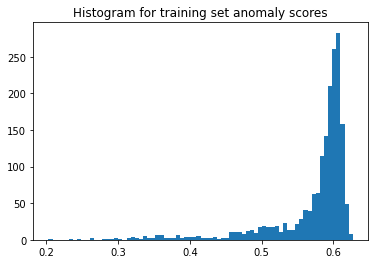

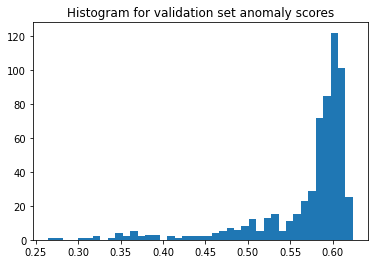

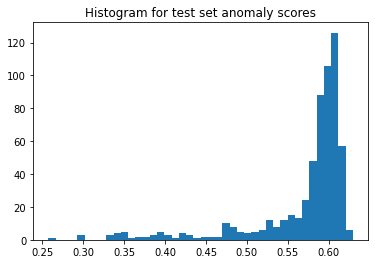

In [158]:
from pyod.models.mo_gaal import MO_GAAL
clf19 = MO_GAAL(stop_epochs=50, lr_g=0.001, decay=0.001, contamination=outlier_ratio)
clf19.fit(train_arr)
viewOutliers(clf19)

Based on the performance of the algorithms above, I selected 4 algorithms to further optimise, based on whether the algorithms were able to give a clear separation of normal points and around 0.08 outliers ratio. The algorithms chosen are connectivity based outlier factor, autoencoders, deepSVDD, Multiple-Objective Generative Adversarial Active Learning.  

1. Connectivity based outlier factor

number of n neighbours 10


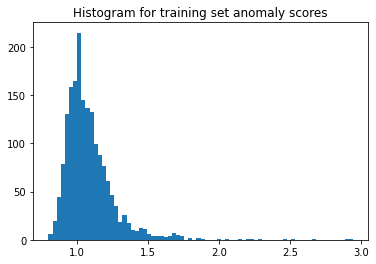

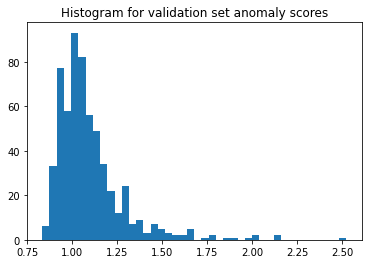

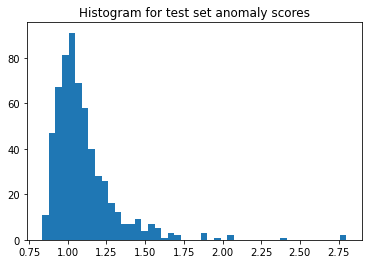

number of n neighbours 20


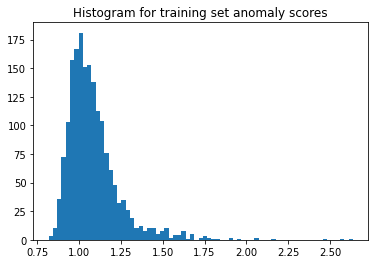

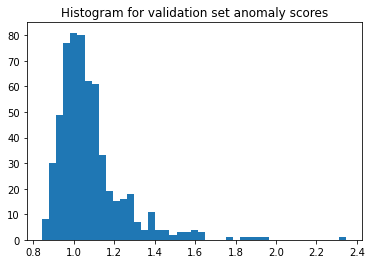

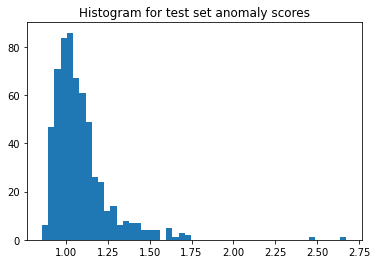

number of n neighbours 30


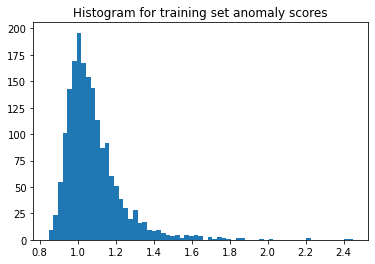

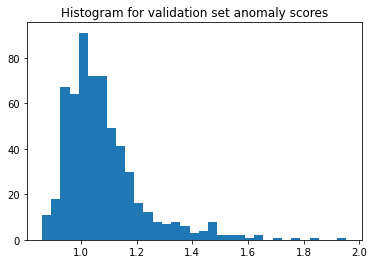

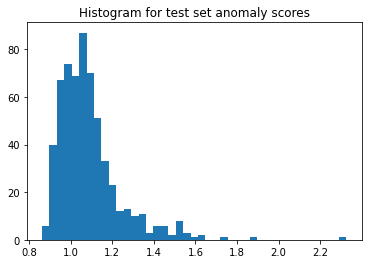

number of n neighbours 40


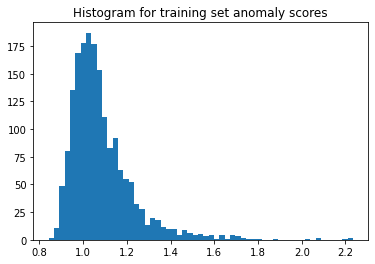

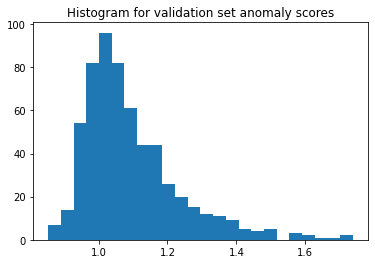

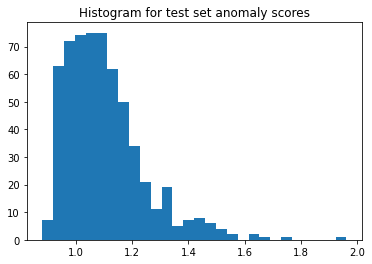

number of n neighbours 50


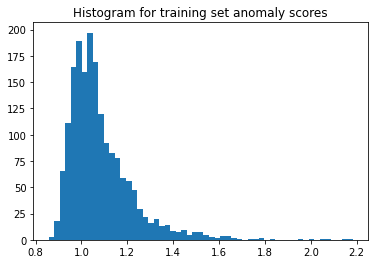

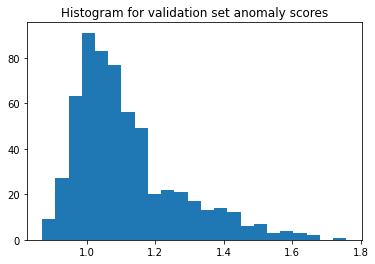

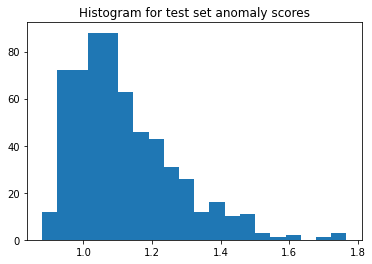

number of n neighbours 100


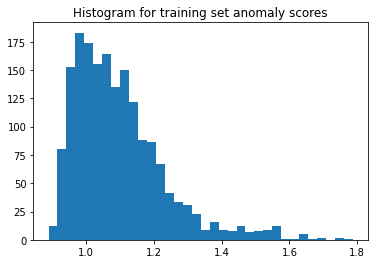

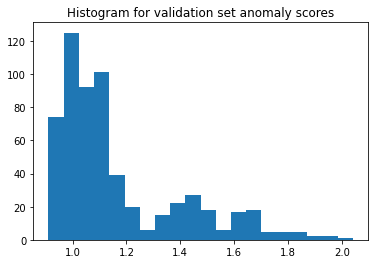

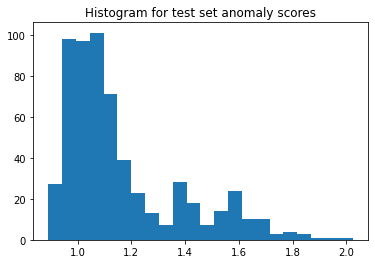

In [159]:
from pyod.models.cof import COF 

#find optimal value for n_neighbours
n_neighbourslist = [10, 20, 30, 40, 50, 100]
for x in n_neighbourslist:
    clf22 = COF(n_neighbors=x, contamination=outlier_ratio)
    clf22.fit(train_arr)
    print('number of n neighbours %d' % x)
    viewOutliers(clf22)

10 n_neighbours seems to give good performance. 

method fast


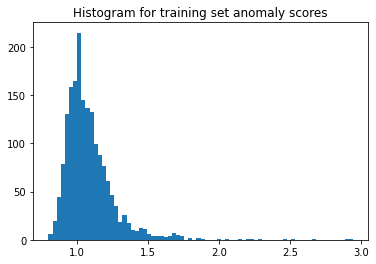

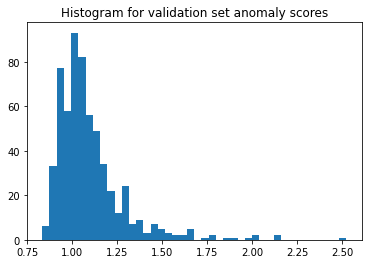

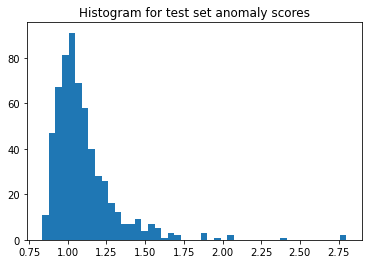

method memory


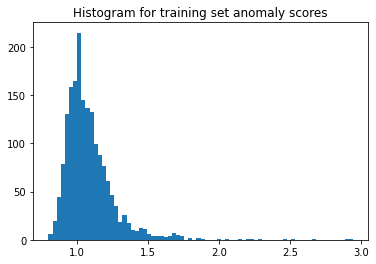

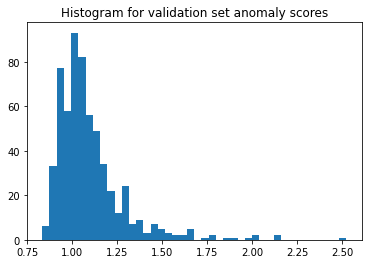

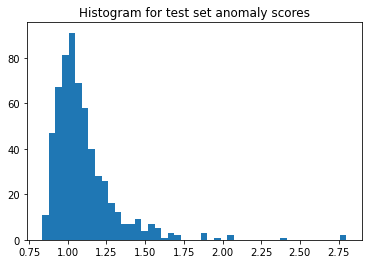

In [160]:
#find optimal value for method
n_neighbourslist = ['fast', 'memory']
for x in n_neighbourslist:
    clf23 = COF(n_neighbors=10, method=x, contamination=outlier_ratio)
    clf23.fit(train_arr)
    print('method %s' % x)
    viewOutliers(clf23)

method does not affect the model performance. I will leave it as default. 

2. Autoencoders

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_140 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_40 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_141 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_41 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_142 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_42 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_143 (Dense)            (None, 2)               

51/51 [==============================] - 0s 2ms/step - loss: 1.0165 - val_loss: 1.0966
Epoch 63/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0147 - val_loss: 1.0960
Epoch 64/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0145 - val_loss: 1.0955
Epoch 65/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0150 - val_loss: 1.0949
Epoch 66/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0136 - val_loss: 1.0944
Epoch 67/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0127 - val_loss: 1.0939
Epoch 68/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0125 - val_loss: 1.0934
Epoch 69/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0115 - val_loss: 1.0929
Epoch 70/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0113 - val_loss: 1.0925
Epoch 71/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0098 - val_loss: 1.0920
Epoch 72/100


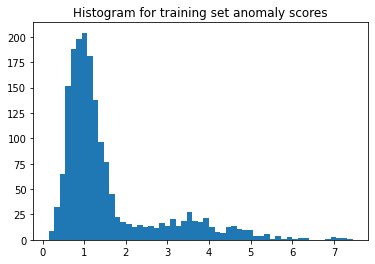

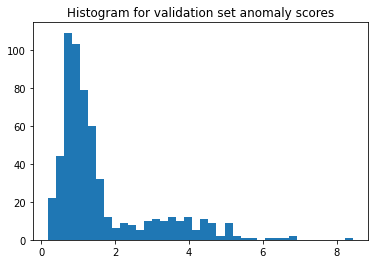

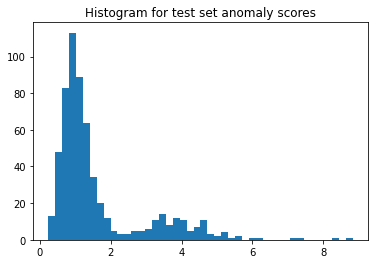

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_46 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_148 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_47 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_149 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_48 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_150 (Dense)            (None, 3)               

51/51 [==============================] - 0s 2ms/step - loss: 1.0082 - val_loss: 1.2082
Epoch 58/100
51/51 [==============================] - 0s 3ms/step - loss: 1.0072 - val_loss: 1.2078
Epoch 59/100
51/51 [==============================] - 0s 3ms/step - loss: 1.0062 - val_loss: 1.2074
Epoch 60/100
51/51 [==============================] - 0s 3ms/step - loss: 1.0053 - val_loss: 1.2070
Epoch 61/100
51/51 [==============================] - 0s 3ms/step - loss: 1.0044 - val_loss: 1.2066
Epoch 62/100
51/51 [==============================] - 0s 3ms/step - loss: 1.0035 - val_loss: 1.2063
Epoch 63/100
51/51 [==============================] - 0s 3ms/step - loss: 1.0027 - val_loss: 1.2059
Epoch 64/100
51/51 [==============================] - 0s 3ms/step - loss: 1.0019 - val_loss: 1.2056
Epoch 65/100
51/51 [==============================] - 0s 3ms/step - loss: 1.0012 - val_loss: 1.2053
Epoch 66/100
51/51 [==============================] - 0s 3ms/step - loss: 1.0004 - val_loss: 1.2051
Epoch 67/100


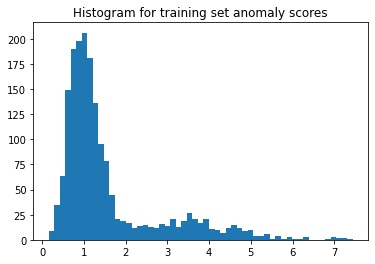

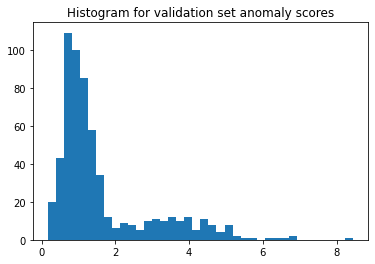

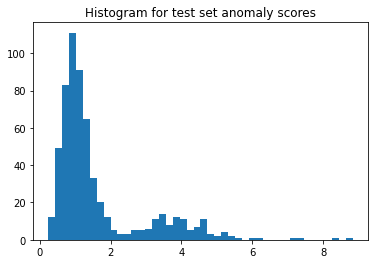

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_54 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_157 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_55 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_158 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_56 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_159 (Dense)            (None, 3)               

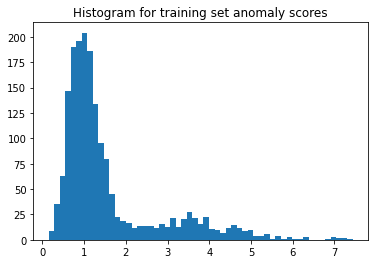

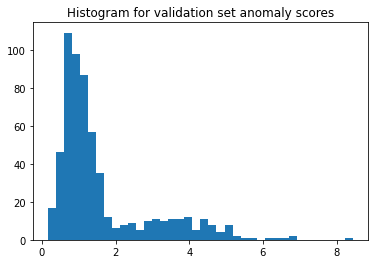

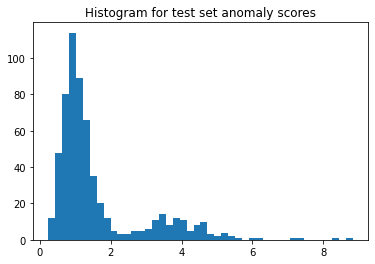

In [165]:
from pyod.models.auto_encoder import AutoEncoder

#find optimal number of hidden neurons
hidden_neuronslist = [[4, 2, 2, 4], [4, 3, 1, 1, 3, 4], [4, 3, 2, 1, 1, 2, 3, 4]]
for x in hidden_neuronslist:
    clf23 = AutoEncoder(hidden_neurons=x, contamination=outlier_ratio)
    clf23.fit(train_arr)
    print("number of hidden layers %d" % len(x))
    viewOutliers(clf23)

The number of hidden layers does not seem to affect the results much. I will just use 3 hidden layers. 

The number of epochs seems too few. Increase the number of epochs to 300 and try out different optimisers.

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_239 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_128 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_240 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_129 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_241 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_130 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_242 (Dense)            (None, 3)               

51/51 [==============================] - 0s 3ms/step - loss: 0.0612 - val_loss: 0.0611
Epoch 58/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0609 - val_loss: 0.0607
Epoch 59/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0604
Epoch 60/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0602 - val_loss: 0.0601
Epoch 61/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0599 - val_loss: 0.0598
Epoch 62/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0597 - val_loss: 0.0595
Epoch 63/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0593
Epoch 64/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0590
Epoch 65/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0588 - val_loss: 0.0587
Epoch 66/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0585
Epoch 67/300


51/51 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0505
Epoch 220/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0504
Epoch 221/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0504
Epoch 222/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0504
Epoch 223/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0504
Epoch 224/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0504
Epoch 225/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0504
Epoch 226/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0504
Epoch 227/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0504
Epoch 228/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0504
Epoc

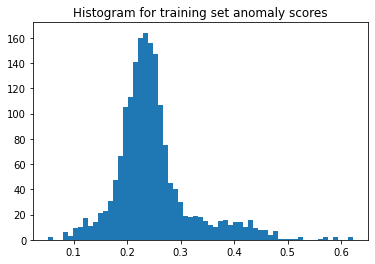

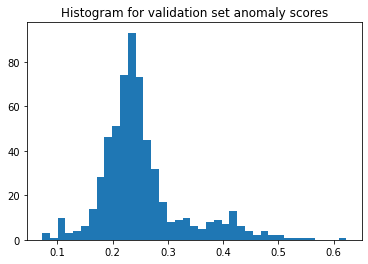

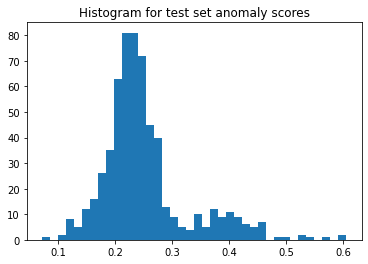

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_248 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_136 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_249 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_137 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_250 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_138 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_251 (Dense)            (None, 3)               

51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0507
Epoch 58/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0507
Epoch 59/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0507
Epoch 60/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0507
Epoch 61/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0507
Epoch 62/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0507
Epoch 63/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0507
Epoch 64/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0507
Epoch 65/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0507
Epoch 66/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0507
Epoch 67/300


51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 220/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0507
Epoch 221/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 222/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0507
Epoch 223/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0507
Epoch 224/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0507
Epoch 225/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0506
Epoch 226/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0507
Epoch 227/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 228/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0507
Epoc

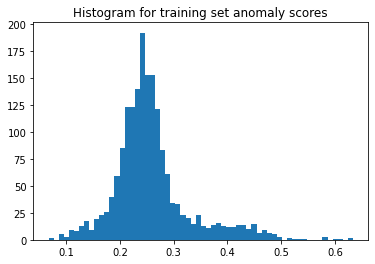

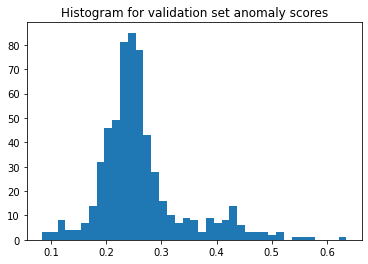

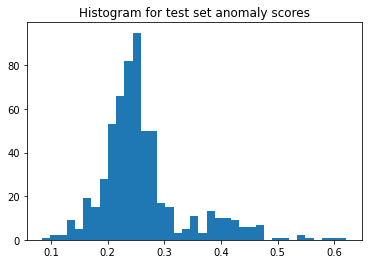

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_257 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_144 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_258 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_145 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_259 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_146 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_260 (Dense)            (None, 3)               

51/51 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0493
Epoch 58/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0493
Epoch 59/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0493
Epoch 60/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0493
Epoch 61/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0492
Epoch 62/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0492
Epoch 63/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0492
Epoch 64/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0492
Epoch 65/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0492
Epoch 66/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0492
Epoch 67/300


51/51 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0491
Epoch 220/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0491
Epoch 221/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0491
Epoch 222/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0491
Epoch 223/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0491
Epoch 224/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0491
Epoch 225/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0491
Epoch 226/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0491
Epoch 227/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0491
Epoch 228/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0491
Epoc

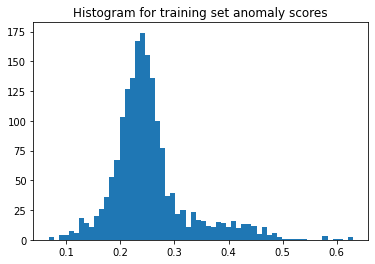

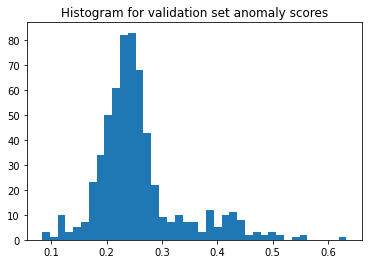

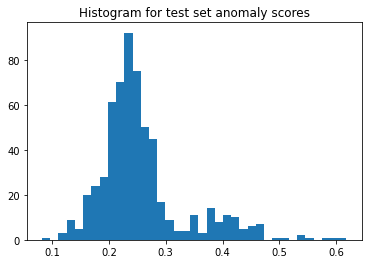

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_266 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_152 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_267 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_153 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_268 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_154 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_269 (Dense)            (None, 3)               

51/51 [==============================] - 0s 2ms/step - loss: 0.1615 - val_loss: 0.1614
Epoch 58/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1614 - val_loss: 0.1613
Epoch 59/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1613 - val_loss: 0.1613
Epoch 60/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1613 - val_loss: 0.1612
Epoch 61/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1612 - val_loss: 0.1611
Epoch 62/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1611 - val_loss: 0.1610
Epoch 63/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1610 - val_loss: 0.1609
Epoch 64/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1609 - val_loss: 0.1608
Epoch 65/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1608 - val_loss: 0.1608
Epoch 66/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1607 - val_loss: 0.1607
Epoch 67/300


51/51 [==============================] - 0s 2ms/step - loss: 0.1455 - val_loss: 0.1456
Epoch 220/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1454 - val_loss: 0.1455
Epoch 221/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1453 - val_loss: 0.1454
Epoch 222/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1452 - val_loss: 0.1453
Epoch 223/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1451 - val_loss: 0.1451
Epoch 224/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1450 - val_loss: 0.1450
Epoch 225/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1449 - val_loss: 0.1449
Epoch 226/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1448 - val_loss: 0.1448
Epoch 227/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1447 - val_loss: 0.1447
Epoch 228/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1446 - val_loss: 0.1446
Epoc

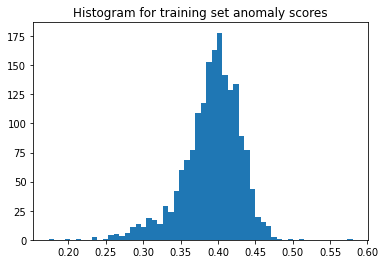

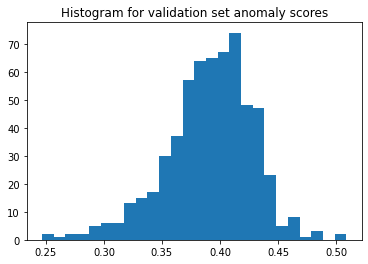

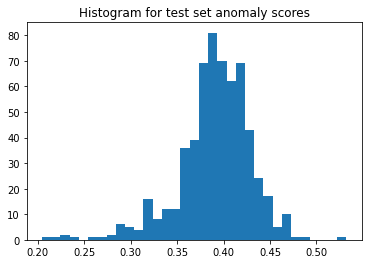

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_275 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_160 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_276 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_161 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_277 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_162 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_278 (Dense)            (None, 3)               

51/51 [==============================] - 0s 2ms/step - loss: 0.1291 - val_loss: 0.1284
Epoch 58/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1290 - val_loss: 0.1282
Epoch 59/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1288 - val_loss: 0.1281
Epoch 60/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1286 - val_loss: 0.1279
Epoch 61/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1286 - val_loss: 0.1278
Epoch 62/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1282 - val_loss: 0.1276
Epoch 63/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1281 - val_loss: 0.1275
Epoch 64/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1279 - val_loss: 0.1273
Epoch 65/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1278 - val_loss: 0.1271
Epoch 66/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1277 - val_loss: 0.1270
Epoch 67/300


51/51 [==============================] - 0s 4ms/step - loss: 0.1133 - val_loss: 0.1127
Epoch 220/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1133 - val_loss: 0.1126
Epoch 221/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1132 - val_loss: 0.1126
Epoch 222/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1132 - val_loss: 0.1125
Epoch 223/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1130 - val_loss: 0.1124
Epoch 224/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1130 - val_loss: 0.1124
Epoch 225/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1130 - val_loss: 0.1123
Epoch 226/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1129 - val_loss: 0.1122
Epoch 227/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1129 - val_loss: 0.1122
Epoch 228/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1127 - val_loss: 0.1121
Epoc

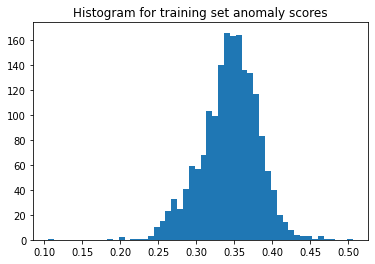

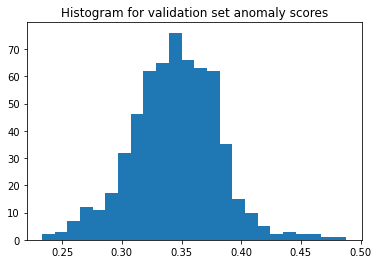

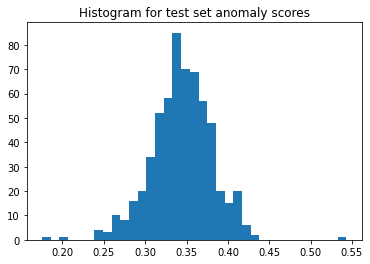

In [172]:
#find a good optimiser 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adagrad

#list of optimisers
sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=False)
rmsprop = RMSprop(learning_rate=0.001,rho=0.9,momentum=0.9,epsilon=1e-07,centered=True)
adam = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
adadelta = Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07)
adagrad = Adagrad(learning_rate=0.001,initial_accumulator_value=0.1,epsilon=1e-07)

optimiserslist = [sgd, rmsprop, adam, adadelta, adagrad]
for x in optimiserslist:
    clf24 = AutoEncoder(hidden_neurons=[4, 3, 1, 1, 3, 4], contamination=outlier_ratio, epochs=300, optimizer=x, random_state=42, preprocessing=False)
    clf24.fit(train_arr)
    print("Index of optimiser %d" % optimiserslist.index(x))
    viewOutliers(clf24)

SGD, Adam, RMSprop seems to give good performance. I will use Adam. 

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_284 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_168 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_285 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_169 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_286 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_170 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_287 (Dense)            (None, 3)               

Epoch 56/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 57/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 58/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 59/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 60/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 61/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 62/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 63/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 64/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 65/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502

Epoch 136/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 137/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 138/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 139/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 140/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 141/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 142/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 143/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 144/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 145/300
102/102 [==============================] - 0s 2ms/step - lo

102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 295/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 296/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 297/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 298/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 299/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Epoch 300/300
102/102 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0504
Batch size 16


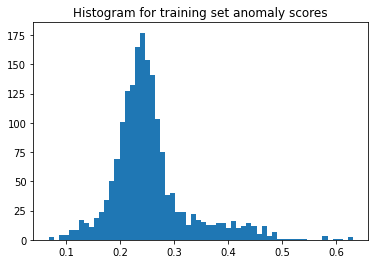

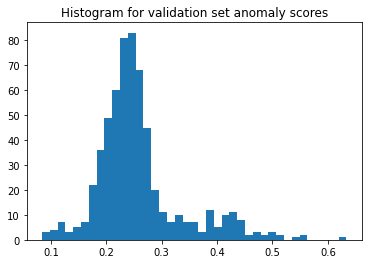

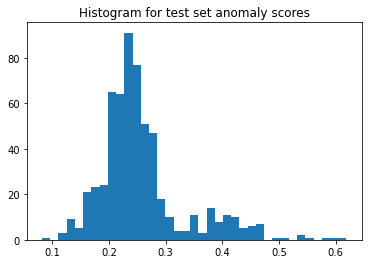

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_293 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_176 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_294 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_177 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_295 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_178 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_296 (Dense)            (None, 3)               

51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 58/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 59/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 60/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 61/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 62/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 63/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 64/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 65/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 66/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 67/300


51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 219/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 220/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 221/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 222/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 223/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 224/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 225/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 226/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 227/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoc

Epoch 299/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 300/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0498
Batch size 32


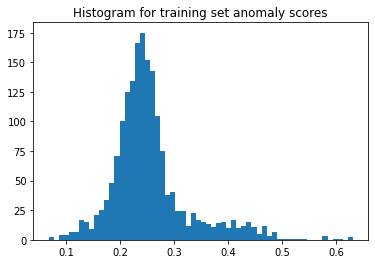

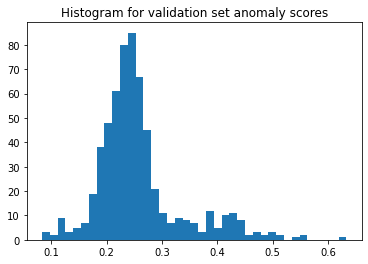

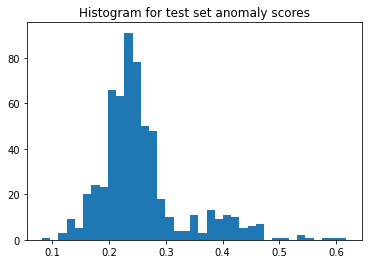

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_302 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_184 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_303 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_185 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_304 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_186 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_305 (Dense)            (None, 3)               

26/26 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0511
Epoch 58/300
26/26 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0511
Epoch 59/300
26/26 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0511
Epoch 60/300
26/26 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0510
Epoch 61/300
26/26 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0510
Epoch 62/300
26/26 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0510
Epoch 63/300
26/26 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0510
Epoch 64/300
26/26 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0509
Epoch 65/300
26/26 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0509
Epoch 66/300
26/26 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0509
Epoch 67/300


26/26 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0507
Epoch 220/300
26/26 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0507
Epoch 221/300
26/26 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0507
Epoch 222/300
26/26 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0507
Epoch 223/300
26/26 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0507
Epoch 224/300
26/26 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0507
Epoch 225/300
26/26 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0507
Epoch 226/300
26/26 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0507
Epoch 227/300
26/26 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0507
Epoch 228/300
26/26 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0507
Epoc

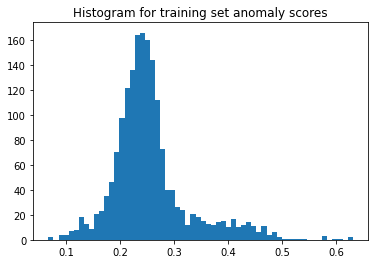

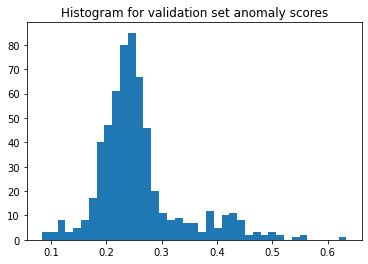

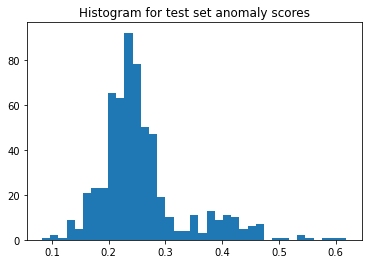

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_311 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_192 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_312 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_193 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_313 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_194 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_314 (Dense)            (None, 3)               

13/13 [==============================] - 0s 4ms/step - loss: 0.0537 - val_loss: 0.0529
Epoch 58/300
13/13 [==============================] - 0s 4ms/step - loss: 0.0536 - val_loss: 0.0527
Epoch 59/300
13/13 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 0.0526
Epoch 60/300
13/13 [==============================] - 0s 4ms/step - loss: 0.0533 - val_loss: 0.0525
Epoch 61/300
13/13 [==============================] - 0s 4ms/step - loss: 0.0532 - val_loss: 0.0523
Epoch 62/300
13/13 [==============================] - 0s 4ms/step - loss: 0.0531 - val_loss: 0.0522
Epoch 63/300
13/13 [==============================] - 0s 4ms/step - loss: 0.0530 - val_loss: 0.0521
Epoch 64/300
13/13 [==============================] - 0s 4ms/step - loss: 0.0529 - val_loss: 0.0520
Epoch 65/300
13/13 [==============================] - 0s 3ms/step - loss: 0.0528 - val_loss: 0.0519
Epoch 66/300
13/13 [==============================] - 0s 4ms/step - loss: 0.0527 - val_loss: 0.0518
Epoch 67/300


13/13 [==============================] - 0s 4ms/step - loss: 0.0503 - val_loss: 0.0490
Epoch 220/300
13/13 [==============================] - 0s 4ms/step - loss: 0.0503 - val_loss: 0.0490
Epoch 221/300
13/13 [==============================] - 0s 4ms/step - loss: 0.0503 - val_loss: 0.0490
Epoch 222/300
13/13 [==============================] - 0s 4ms/step - loss: 0.0503 - val_loss: 0.0490
Epoch 223/300
13/13 [==============================] - 0s 4ms/step - loss: 0.0503 - val_loss: 0.0490
Epoch 224/300
13/13 [==============================] - 0s 4ms/step - loss: 0.0503 - val_loss: 0.0490
Epoch 225/300
13/13 [==============================] - 0s 4ms/step - loss: 0.0503 - val_loss: 0.0490
Epoch 226/300
13/13 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0490
Epoch 227/300
13/13 [==============================] - 0s 4ms/step - loss: 0.0503 - val_loss: 0.0490
Epoch 228/300
13/13 [==============================] - 0s 4ms/step - loss: 0.0503 - val_loss: 0.0490
Epoc

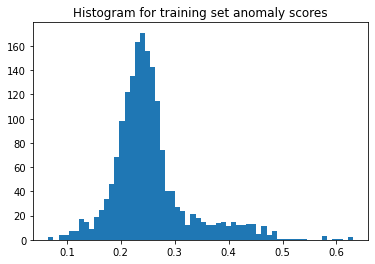

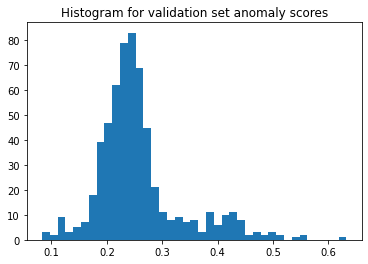

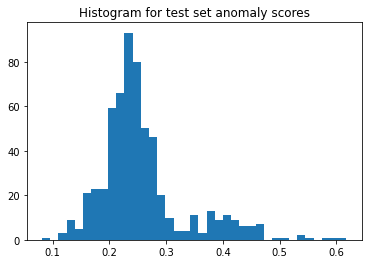

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_320 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_200 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_321 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_201 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_322 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_202 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_323 (Dense)            (None, 3)               

7/7 [==============================] - 0s 7ms/step - loss: 0.0521 - val_loss: 0.0519
Epoch 142/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0521 - val_loss: 0.0518
Epoch 143/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0520 - val_loss: 0.0518
Epoch 144/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0520 - val_loss: 0.0518
Epoch 145/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0520 - val_loss: 0.0517
Epoch 146/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0519 - val_loss: 0.0517
Epoch 147/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0520 - val_loss: 0.0517
Epoch 148/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0519 - val_loss: 0.0517
Epoch 149/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0518 - val_loss: 0.0516
Epoch 150/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0518 - val_loss: 0.0516
Epoch 151/300
7/7 [=====

Epoch 224/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0506 - val_loss: 0.0505
Epoch 225/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0506 - val_loss: 0.0505
Epoch 226/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0506 - val_loss: 0.0505
Epoch 227/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0506 - val_loss: 0.0505
Epoch 228/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0506 - val_loss: 0.0504
Epoch 229/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0506 - val_loss: 0.0504
Epoch 230/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0506 - val_loss: 0.0504
Epoch 231/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0506 - val_loss: 0.0504
Epoch 232/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0506 - val_loss: 0.0504
Epoch 233/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0506 - val_loss: 0.0504
Epoch 234/

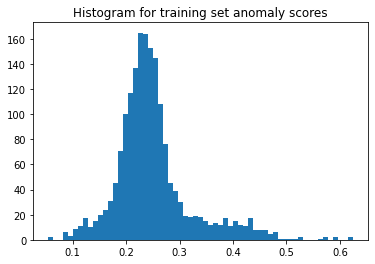

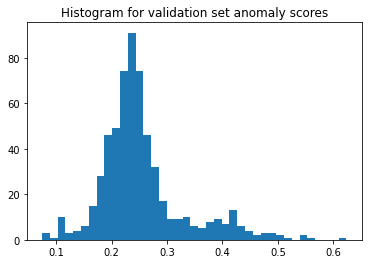

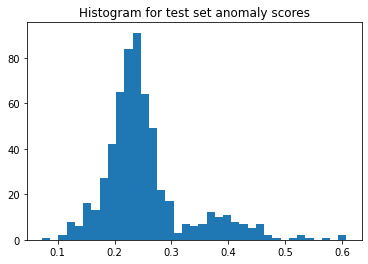

In [173]:
adam = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
batch_sizelist = [16, 32, 64, 128, 256]
for x in batch_sizelist:
    clf25 = AutoEncoder(batch_size=x, hidden_neurons=[4, 3, 1, 1, 3, 4], contamination=outlier_ratio, epochs=300, optimizer=adam, random_state=42, preprocessing=False)
    clf25.fit(train_arr)
    print("Batch size %d" % x)
    viewOutliers(clf25)

Batch sizes of 16, 32, 64, 128 seems to give good results. I will just use the default 32. 

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_329 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_208 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_330 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_209 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_331 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_210 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_332 (Dense)            (None, 3)               

51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 58/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 59/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 60/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 61/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 62/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 63/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 64/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 65/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 66/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 67/300


51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 220/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 221/300
51/51 [==============================] - 0s 4ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 222/300
51/51 [==============================] - 0s 4ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 223/300
51/51 [==============================] - 0s 4ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 224/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 225/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 226/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 227/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 228/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0516
Epoc

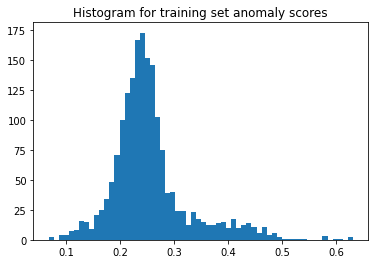

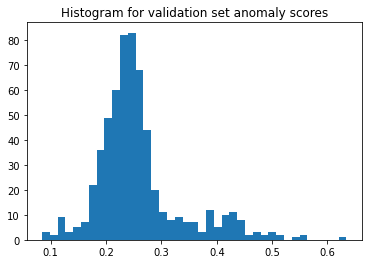

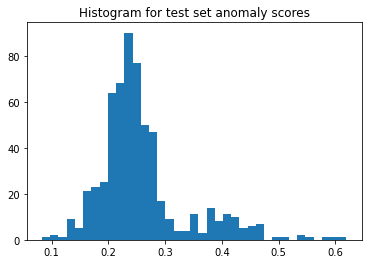

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_338 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_216 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_339 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_217 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_340 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_218 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_341 (Dense)            (None, 3)               

51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0520
Epoch 58/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0520
Epoch 59/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0520
Epoch 60/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0520
Epoch 61/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0520
Epoch 62/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0520
Epoch 63/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0520
Epoch 64/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0520
Epoch 65/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0520
Epoch 66/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0520
Epoch 67/300


51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0521
Epoch 220/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0521
Epoch 221/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0520
Epoch 222/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0520
Epoch 223/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0521
Epoch 224/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0521
Epoch 225/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0521
Epoch 226/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0521
Epoch 227/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0520
Epoch 228/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0521
Epoc

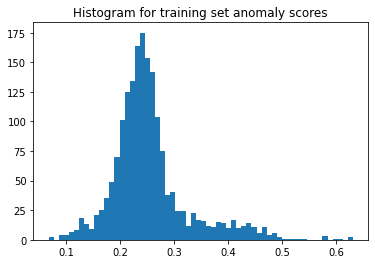

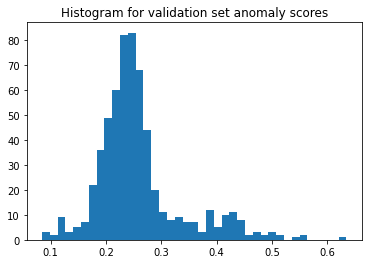

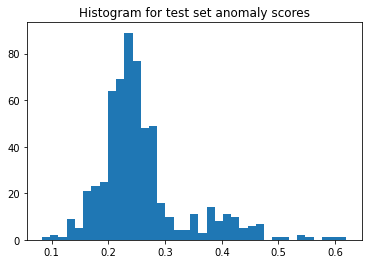

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_347 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_224 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_348 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_225 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_349 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_226 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_350 (Dense)            (None, 3)               

51/51 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0515
Epoch 58/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0515
Epoch 59/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 60/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 61/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 62/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 63/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 64/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 65/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 66/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 67/300


51/51 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 220/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 221/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 222/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 223/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 224/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 225/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 226/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 227/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 228/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0515
Epoc

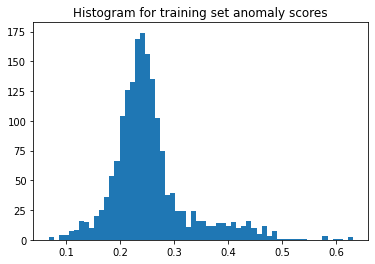

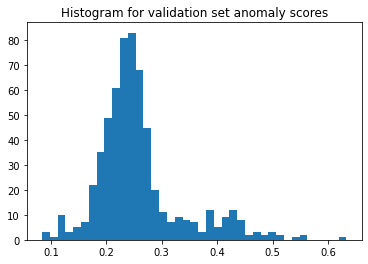

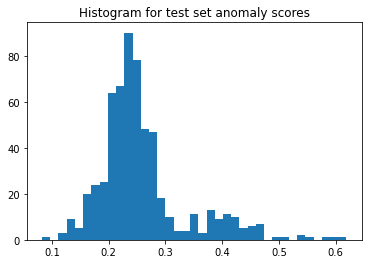

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_356 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_232 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_357 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_233 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_358 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_234 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_359 (Dense)            (None, 3)               

51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0507
Epoch 58/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0507
Epoch 59/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0507
Epoch 60/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0507
Epoch 61/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 62/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 63/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 64/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 65/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 66/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 67/300


51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 220/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 221/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 222/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 223/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 224/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 225/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 226/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 227/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0506
Epoch 228/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0506
Epoc

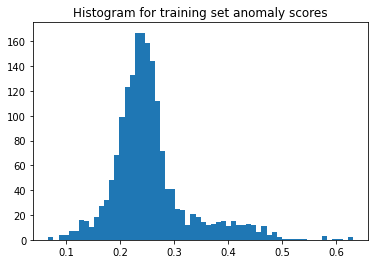

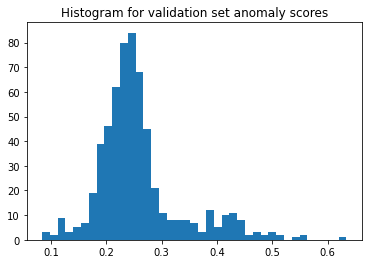

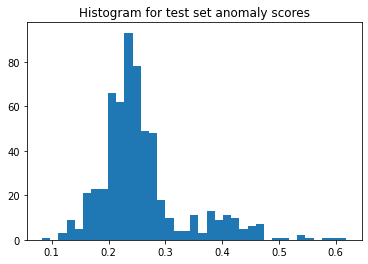

In [174]:
dropout_ratelist = [0.2, 0.4, 0.6, 0.8]
for x in dropout_ratelist:
    clf26 = AutoEncoder(dropout_rate=x, batch_size=32, hidden_neurons=[4, 3, 1, 1, 3, 4], contamination=outlier_ratio, epochs=300, optimizer=adam, random_state=42, preprocessing=False)
    clf26.fit(train_arr)
    print("Dropout rate %f" % x)
    viewOutliers(clf26)

Dropout rate does not seem to affect model performance much. I will use the default 0.2

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_365 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_240 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_366 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_241 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_367 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_242 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_368 (Dense)            (None, 3)               

51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0493
Epoch 58/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0493
Epoch 59/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0493
Epoch 60/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0493
Epoch 61/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0493
Epoch 62/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0493
Epoch 63/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0493
Epoch 64/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0493
Epoch 65/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0493
Epoch 66/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0493
Epoch 67/300


51/51 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0493
Epoch 220/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0492
Epoch 221/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0492
Epoch 222/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0492
Epoch 223/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0492
Epoch 224/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0492
Epoch 225/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0492
Epoch 226/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0492
Epoch 227/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0492
Epoch 228/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0493
Epoc

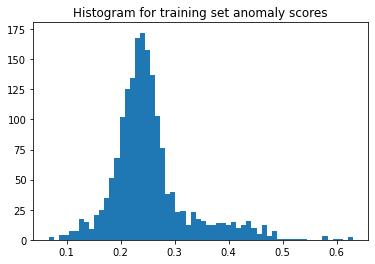

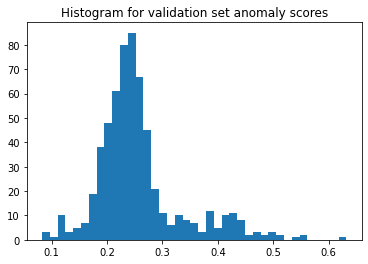

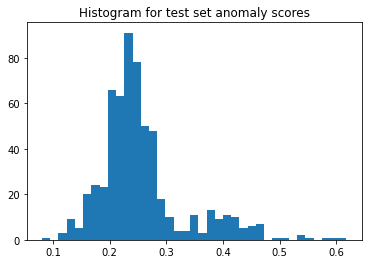

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_374 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_248 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_375 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_249 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_376 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_250 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_377 (Dense)            (None, 3)               

51/51 [==============================] - 0s 3ms/step - loss: 0.0925 - val_loss: 0.0892
Epoch 58/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0924 - val_loss: 0.0891
Epoch 59/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0924 - val_loss: 0.0891
Epoch 60/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0924 - val_loss: 0.0891
Epoch 61/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0923 - val_loss: 0.0890
Epoch 62/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0923 - val_loss: 0.0890
Epoch 63/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0923 - val_loss: 0.0890
Epoch 64/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0923 - val_loss: 0.0890
Epoch 65/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0923 - val_loss: 0.0889
Epoch 66/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0923 - val_loss: 0.0889
Epoch 67/300


51/51 [==============================] - 0s 3ms/step - loss: 0.0921 - val_loss: 0.0888
Epoch 220/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0921 - val_loss: 0.0888
Epoch 221/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0921 - val_loss: 0.0888
Epoch 222/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0921 - val_loss: 0.0888
Epoch 223/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0921 - val_loss: 0.0888
Epoch 224/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0921 - val_loss: 0.0888
Epoch 225/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0921 - val_loss: 0.0888
Epoch 226/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0921 - val_loss: 0.0888
Epoch 227/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0921 - val_loss: 0.0888
Epoch 228/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0921 - val_loss: 0.0888
Epoc

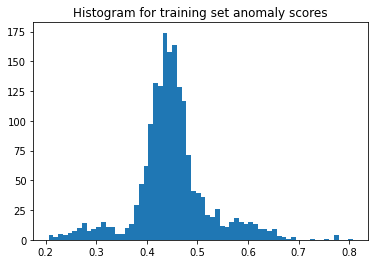

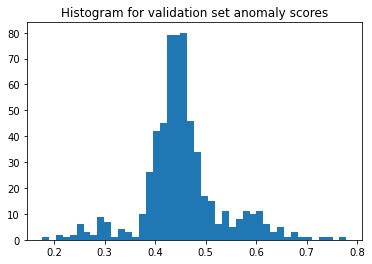

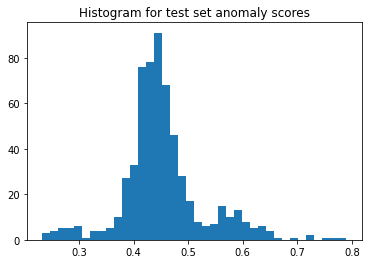

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_383 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_256 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_384 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_257 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_385 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_258 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_386 (Dense)            (None, 3)               

51/51 [==============================] - 0s 3ms/step - loss: 0.1129 - val_loss: 0.1125
Epoch 58/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1128 - val_loss: 0.1124
Epoch 59/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1127 - val_loss: 0.1122
Epoch 60/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1126 - val_loss: 0.1121
Epoch 61/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1125 - val_loss: 0.1120
Epoch 62/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1124 - val_loss: 0.1120
Epoch 63/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1123 - val_loss: 0.1119
Epoch 64/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1122 - val_loss: 0.1118
Epoch 65/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1121 - val_loss: 0.1117
Epoch 66/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1121 - val_loss: 0.1117
Epoch 67/300


51/51 [==============================] - 0s 2ms/step - loss: 0.1113 - val_loss: 0.1110
Epoch 220/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1113 - val_loss: 0.1110
Epoch 221/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1113 - val_loss: 0.1110
Epoch 222/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1113 - val_loss: 0.1110
Epoch 223/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1113 - val_loss: 0.1110
Epoch 224/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1113 - val_loss: 0.1110
Epoch 225/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1113 - val_loss: 0.1110
Epoch 226/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1113 - val_loss: 0.1110
Epoch 227/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1113 - val_loss: 0.1110
Epoch 228/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1113 - val_loss: 0.1110
Epoc

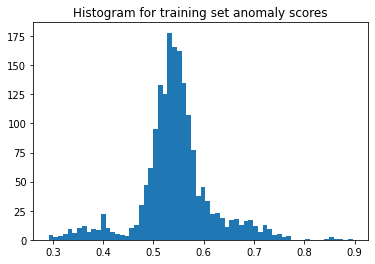

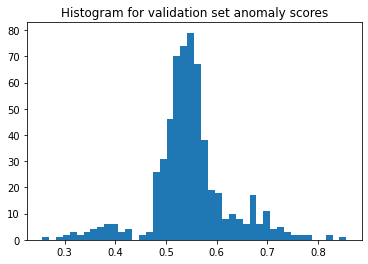

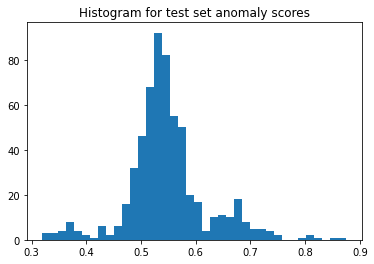

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_392 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_264 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_393 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_265 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_394 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_266 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_395 (Dense)            (None, 3)               

51/51 [==============================] - 0s 2ms/step - loss: 0.1265 - val_loss: 0.1235
Epoch 58/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1262 - val_loss: 0.1233
Epoch 59/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1260 - val_loss: 0.1231
Epoch 60/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1258 - val_loss: 0.1229
Epoch 61/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1256 - val_loss: 0.1227
Epoch 62/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1254 - val_loss: 0.1226
Epoch 63/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1253 - val_loss: 0.1224
Epoch 64/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1251 - val_loss: 0.1222
Epoch 65/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1250 - val_loss: 0.1221
Epoch 66/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1248 - val_loss: 0.1219
Epoch 67/300


51/51 [==============================] - 0s 3ms/step - loss: 0.1228 - val_loss: 0.1199
Epoch 220/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1228 - val_loss: 0.1199
Epoch 221/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1228 - val_loss: 0.1199
Epoch 222/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1228 - val_loss: 0.1199
Epoch 223/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1228 - val_loss: 0.1199
Epoch 224/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1228 - val_loss: 0.1199
Epoch 225/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1228 - val_loss: 0.1199
Epoch 226/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1228 - val_loss: 0.1199
Epoch 227/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1228 - val_loss: 0.1199
Epoch 228/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1228 - val_loss: 0.1199
Epoc

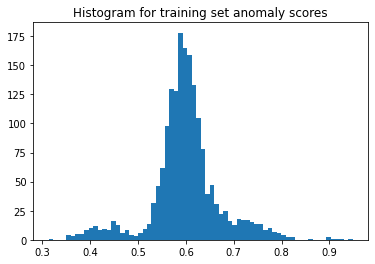

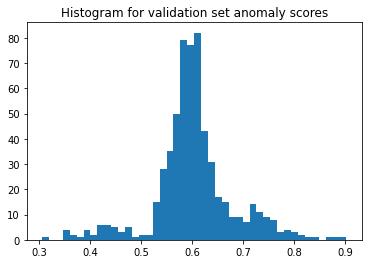

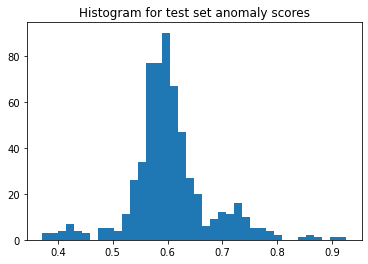

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_401 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_272 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_402 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_273 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_403 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_274 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_404 (Dense)            (None, 3)               

51/51 [==============================] - 0s 2ms/step - loss: 0.1363 - val_loss: 0.1370
Epoch 58/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1359 - val_loss: 0.1367
Epoch 59/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1356 - val_loss: 0.1363
Epoch 60/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1353 - val_loss: 0.1360
Epoch 61/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1350 - val_loss: 0.1357
Epoch 62/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1347 - val_loss: 0.1355
Epoch 63/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1344 - val_loss: 0.1352
Epoch 64/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1341 - val_loss: 0.1350
Epoch 65/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1339 - val_loss: 0.1347
Epoch 66/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1336 - val_loss: 0.1345
Epoch 67/300


51/51 [==============================] - 0s 2ms/step - loss: 0.1297 - val_loss: 0.1309
Epoch 220/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1297 - val_loss: 0.1309
Epoch 221/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1297 - val_loss: 0.1309
Epoch 222/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1297 - val_loss: 0.1309
Epoch 223/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1297 - val_loss: 0.1309
Epoch 224/300
51/51 [==============================] - 0s 3ms/step - loss: 0.1297 - val_loss: 0.1309
Epoch 225/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1297 - val_loss: 0.1309
Epoch 226/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1297 - val_loss: 0.1309
Epoch 227/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1297 - val_loss: 0.1309
Epoch 228/300
51/51 [==============================] - 0s 2ms/step - loss: 0.1297 - val_loss: 0.1309
Epoc

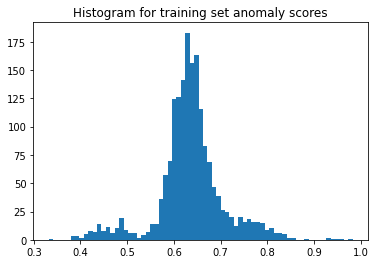

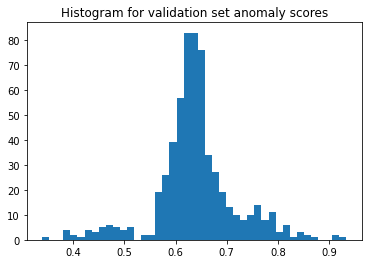

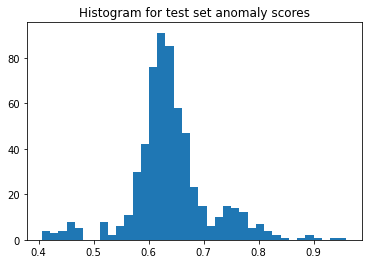

In [175]:
l2_regulariserlist = [0.1, 0.3, 0.5, 0.7, 0.9]
for x in l2_regulariserlist:
    clf27 = AutoEncoder(l2_regularizer=x, dropout_rate=0.2, batch_size=32, hidden_neurons=[4, 3, 1, 1, 3, 4], contamination=outlier_ratio, epochs=300, optimizer=adam, random_state=42, preprocessing=False)
    clf27.fit(train_arr)
    print("l2_regularizer %f" % x)
    viewOutliers(clf27)

l2_regularizer of 0.3 seems to give good results. 

4. DeepSVDD

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
net_output (Dense)           (None, 32)                2080      
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 32)                0         
_________________________________________________________________
tf.math.pow_1 (TFOpLambda)   (None, 32)                0   

Epoch 65/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0318 - val_loss: 0.0318
Epoch 66/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0318
Epoch 67/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0318
Epoch 68/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0318
Epoch 69/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0318
Epoch 70/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0318
Epoch 71/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0318
Epoch 72/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0318 - val_loss: 0.0318
Epoch 73/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0318
Epoch 74/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0318


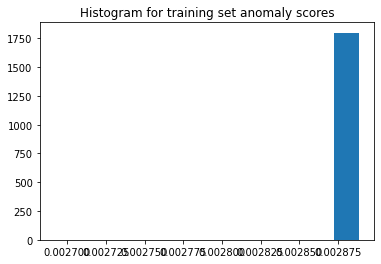

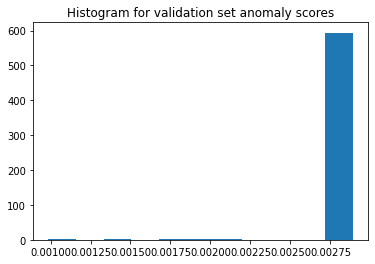

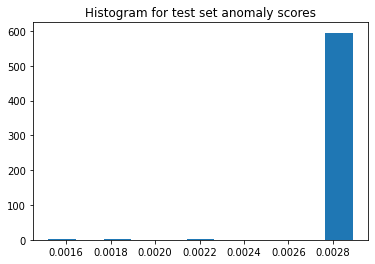

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               1280      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
net_output (Dense)           (None, 32)                2080

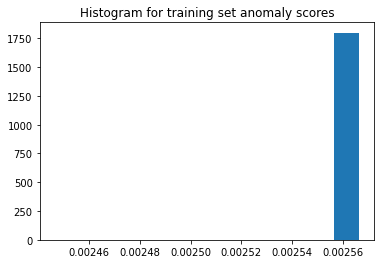

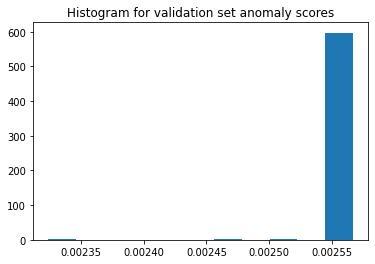

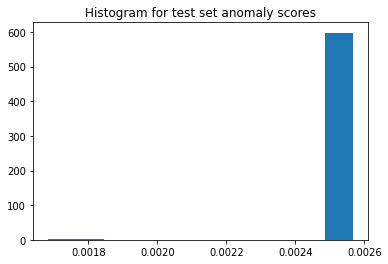

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
net_output (Dense)           (None, 16)                528       
_________________________________________________________________
tf.math.subtract_5 (TFOpLamb (None, 16)                0         
_________________________________________________________________
tf.math.pow_5 (TFOpLambda)   (None, 16)                0   

Epoch 65/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0250 - val_loss: 0.0250
Epoch 66/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0250 - val_loss: 0.0250
Epoch 67/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0250 - val_loss: 0.0250
Epoch 68/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0250 - val_loss: 0.0250
Epoch 69/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0250 - val_loss: 0.0250
Epoch 70/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0250 - val_loss: 0.0250
Epoch 71/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0250 - val_loss: 0.0250
Epoch 72/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0250 - val_loss: 0.0250
Epoch 73/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0250 - val_loss: 0.0250
Epoch 74/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0250 - val_loss: 0.0250


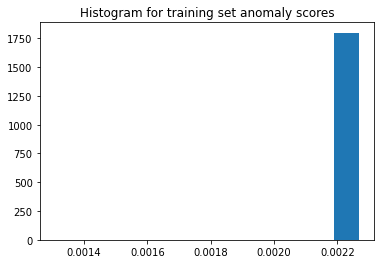

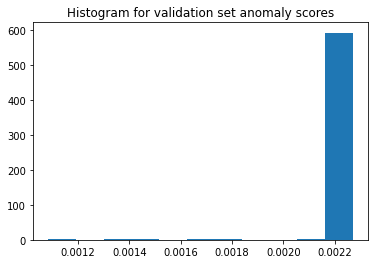

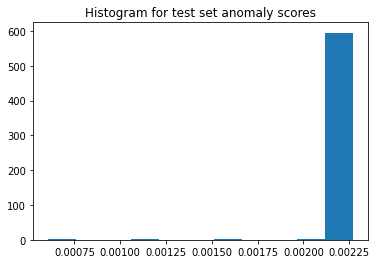

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_17 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
net_output (Dense)           (None, 4)                 68        
_________________________________________________________________
tf.math.subtract_7 (TFOpLamb (None, 4)                 0         
_________________________________________________________________
tf.math.pow_7 (TFOpLambda)   (None, 4)                 0  

Epoch 65/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 66/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 67/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 68/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 69/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 70/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 71/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 72/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 73/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 74/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0037


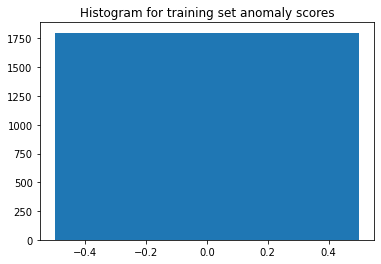

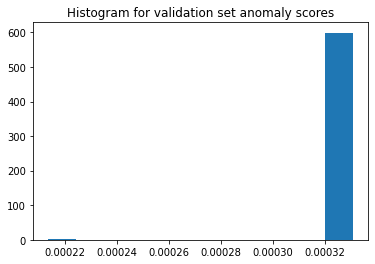

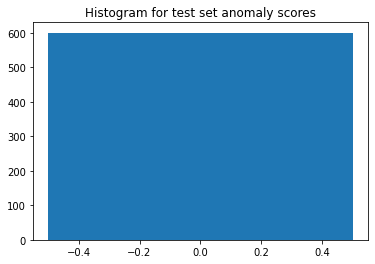

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
net_output (Dense)           (None, 16)                1040      
_________________________________________________________________
tf.math.subtract_9 (TFOpLamb (None, 16)                0         
_________________________________________________________________
tf.math.pow_9 (TFOpLambda)   (None, 16)                0  

Epoch 65/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 66/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 67/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 68/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 69/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 70/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 71/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 72/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 73/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 74/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0140


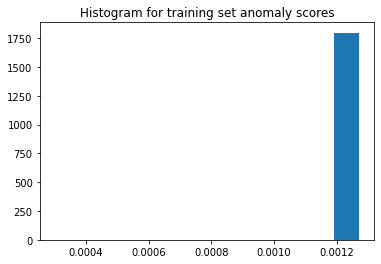

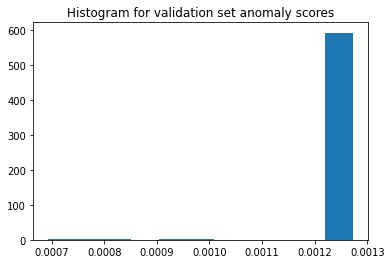

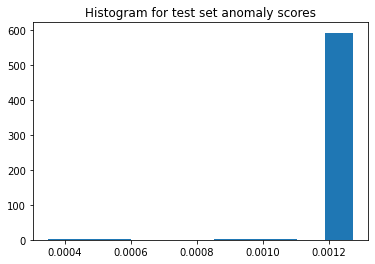

In [25]:
from pyod.models.deep_svdd import DeepSVDD

#test hidden neurons
hidden_neuronslist = [[128, 64, 32], [256, 128, 64, 32], [64, 32, 16], [32, 16, 4], [256, 64, 16]]
for x in hidden_neuronslist:
    clf28 = DeepSVDD(epochs=100, hidden_neurons=x, random_state=42, contamination=outlier_ratio)
    clf28.fit(train_arr)
    print(f'Num hidden neurons {x}')
    viewOutliers(clf28)

[256, 64, 16] seems to give good model performance. 

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
net_output (Dense)           (None, 16)                1040      
_________________________________________________________________
tf.math.subtract_11 (TFOpLam (None, 16)                0         
_________________________________________________________________
tf.math.pow_11 (TFOpLambda)  (None, 16)                0  

Epoch 65/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0152 - val_loss: 0.0154
Epoch 66/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0151 - val_loss: 0.0153
Epoch 67/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0151 - val_loss: 0.0153
Epoch 68/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0151 - val_loss: 0.0153
Epoch 69/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0150 - val_loss: 0.0152
Epoch 70/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0150 - val_loss: 0.0152
Epoch 71/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0150 - val_loss: 0.0152
Epoch 72/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0149 - val_loss: 0.0152
Epoch 73/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0149 - val_loss: 0.0151
Epoch 74/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0149 - val_loss: 0.0151


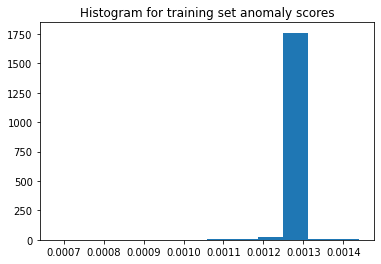

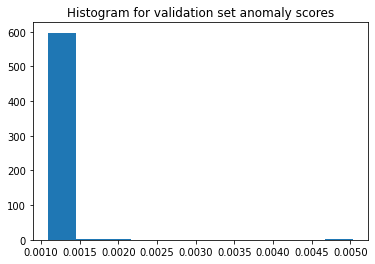

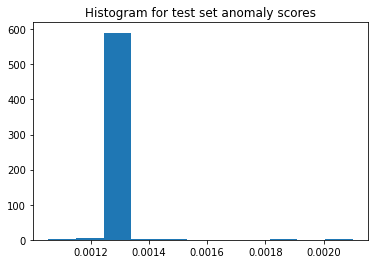

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_29 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
net_output (Dense)           (None, 16)                1040      
_________________________________________________________________
tf.math.subtract_13 (TFOpLam (None, 16)                0         
_________________________________________________________________
tf.math.pow_13 (TFOpLambda)  (None, 16)                0  

Epoch 65/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 66/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 67/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 68/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 69/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 70/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 71/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 72/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 73/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 74/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0140


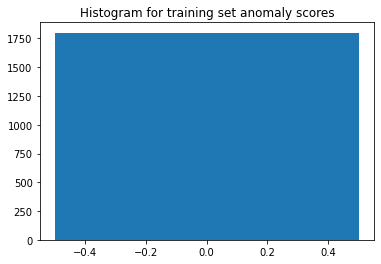

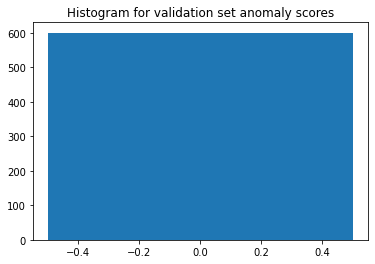

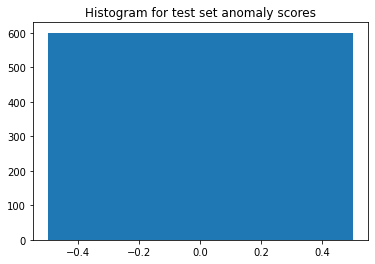

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_32 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_33 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
net_output (Dense)           (None, 16)                1040      
_________________________________________________________________
tf.math.subtract_15 (TFOpLam (None, 16)                0         
_________________________________________________________________
tf.math.pow_15 (TFOpLambda)  (None, 16)                0  

Epoch 65/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 66/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 67/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 68/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 69/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 70/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 71/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 72/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 73/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 74/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0140


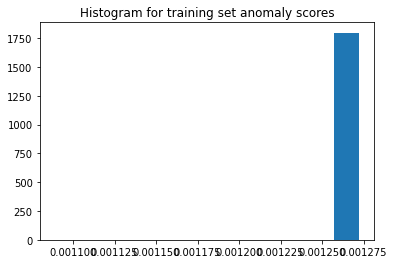

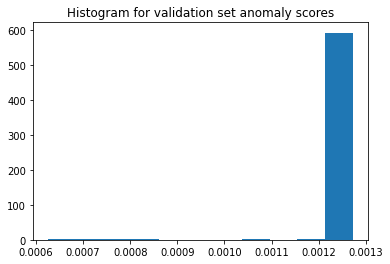

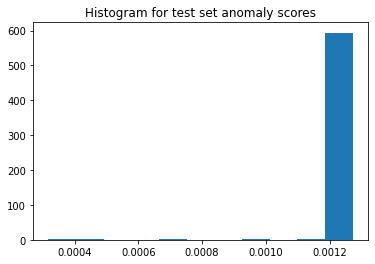

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_37 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
net_output (Dense)           (None, 16)                1040      
_________________________________________________________________
tf.math.subtract_17 (TFOpLam (None, 16)                0         
_________________________________________________________________
tf.math.pow_17 (TFOpLambda)  (None, 16)                0  

Epoch 65/100
51/51 [==============================] - 0s 5ms/step - loss: 0.5430 - val_loss: 0.4736
Epoch 66/100
51/51 [==============================] - 0s 7ms/step - loss: 0.5431 - val_loss: 0.4725
Epoch 67/100
51/51 [==============================] - 0s 7ms/step - loss: 0.5426 - val_loss: 0.4714
Epoch 68/100
51/51 [==============================] - 0s 6ms/step - loss: 0.5437 - val_loss: 0.4703
Epoch 69/100
51/51 [==============================] - 0s 4ms/step - loss: 0.5394 - val_loss: 0.4692
Epoch 70/100
51/51 [==============================] - 0s 4ms/step - loss: 0.5398 - val_loss: 0.4681
Epoch 71/100
51/51 [==============================] - 0s 4ms/step - loss: 0.5346 - val_loss: 0.4671
Epoch 72/100
51/51 [==============================] - 0s 4ms/step - loss: 0.5343 - val_loss: 0.4660
Epoch 73/100
51/51 [==============================] - 0s 7ms/step - loss: 0.5332 - val_loss: 0.4649
Epoch 74/100
51/51 [==============================] - 0s 5ms/step - loss: 0.5326 - val_loss: 0.4638


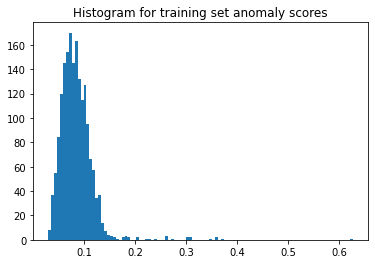

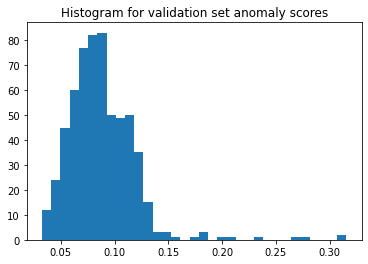

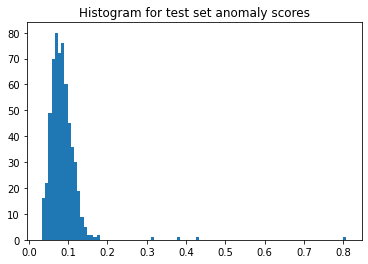

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_40 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_41 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
net_output (Dense)           (None, 16)                1040      
_________________________________________________________________
tf.math.subtract_19 (TFOpLam (None, 16)                0         
_________________________________________________________________
tf.math.pow_19 (TFOpLambda)  (None, 16)                0  

Epoch 65/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0955 - val_loss: 0.0731
Epoch 66/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0943 - val_loss: 0.0720
Epoch 67/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0930 - val_loss: 0.0709
Epoch 68/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0913 - val_loss: 0.0699
Epoch 69/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0901 - val_loss: 0.0689
Epoch 70/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0888 - val_loss: 0.0679
Epoch 71/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0872 - val_loss: 0.0669
Epoch 72/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0862 - val_loss: 0.0660
Epoch 73/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0850 - val_loss: 0.0650
Epoch 74/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0834 - val_loss: 0.0641


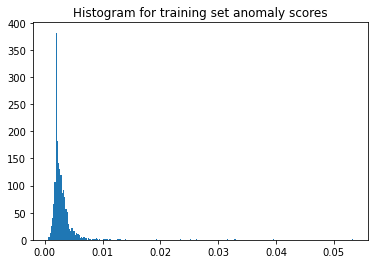

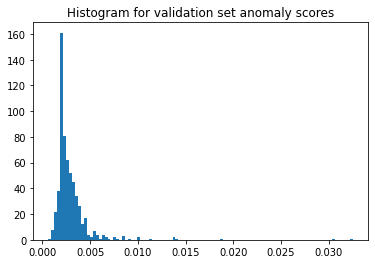

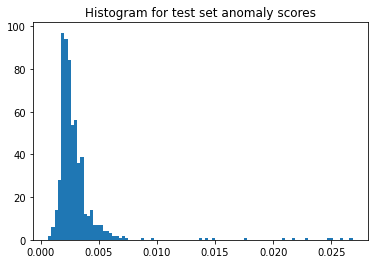

In [27]:
#test optimiser
#find a good optimiser 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adagrad

#list of optimisers
sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=False)
rmsprop = RMSprop(learning_rate=0.001,rho=0.9,momentum=0.9,epsilon=1e-07,centered=True)
adam = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
adadelta = Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07)
adagrad = Adagrad(learning_rate=0.001,initial_accumulator_value=0.1,epsilon=1e-07)

optimiserlist = [sgd, rmsprop, adam, adadelta, adagrad]
for x in optimiserlist:
    clf29 = DeepSVDD(epochs=100, hidden_neurons=[256, 64, 16], optimizer=x, random_state=42, contamination=outlier_ratio)
    clf29.fit(train_arr)
    print('Optimizer %s' % x)
    viewOutliers(clf29)

Adadelta and Adagrad seems to give good results. I will choose adadelta. 

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_44 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_45 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_23 (Dropout)         (None, 16)                0         
_________________________________________________________________
net_output (Dense)           (None, 4)                 68        
_________________________________________________________________
tf.math.subtract_21 (TFOpLam (None, 4)                 0         
_________________________________________________________________
tf.math.pow_21 (TFOpLambda)  (None, 4)                 0  

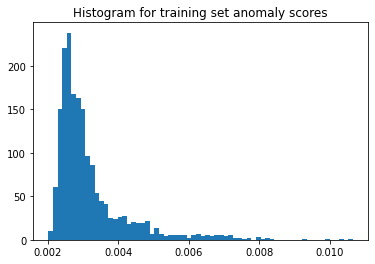

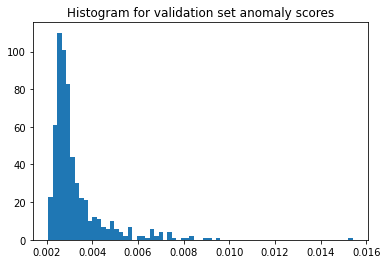

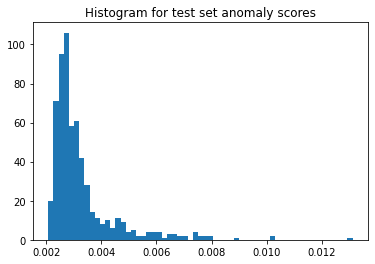

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_48 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_49 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_25 (Dropout)         (None, 16)                0         
_________________________________________________________________
net_output (Dense)           (None, 4)                 68        
_________________________________________________________________
tf.math.subtract_23 (TFOpLam (None, 4)                 0         
_________________________________________________________________
tf.math.pow_23 (TFOpLambda)  (None, 4)                 0  

Epoch 65/100
51/51 [==============================] - 0s 4ms/step - loss: 0.1007 - val_loss: 0.0938
Epoch 66/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0996 - val_loss: 0.0928
Epoch 67/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0985 - val_loss: 0.0919
Epoch 68/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0973 - val_loss: 0.0910
Epoch 69/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0964 - val_loss: 0.0902
Epoch 70/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0953 - val_loss: 0.0893
Epoch 71/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0943 - val_loss: 0.0884
Epoch 72/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0934 - val_loss: 0.0876
Epoch 73/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0927 - val_loss: 0.0868
Epoch 74/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0920 - val_loss: 0.0859


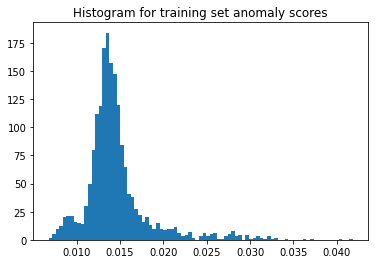

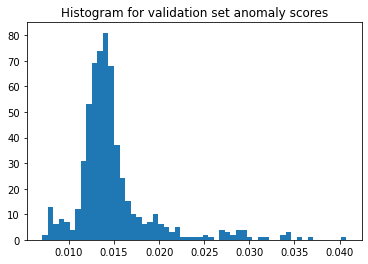

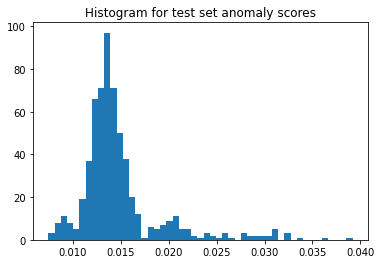

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_52 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_53 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_27 (Dropout)         (None, 16)                0         
_________________________________________________________________
net_output (Dense)           (None, 4)                 68        
_________________________________________________________________
tf.math.subtract_25 (TFOpLam (None, 4)                 0         
_________________________________________________________________
tf.math.pow_25 (TFOpLambda)  (None, 4)                 0  

Epoch 65/100
26/26 [==============================] - 0s 4ms/step - loss: 0.1414 - val_loss: 0.1324
Epoch 66/100
26/26 [==============================] - 0s 4ms/step - loss: 0.1391 - val_loss: 0.1317
Epoch 67/100
26/26 [==============================] - 0s 5ms/step - loss: 0.1377 - val_loss: 0.1309
Epoch 68/100
26/26 [==============================] - 0s 4ms/step - loss: 0.1368 - val_loss: 0.1302
Epoch 69/100
26/26 [==============================] - 0s 4ms/step - loss: 0.1367 - val_loss: 0.1295
Epoch 70/100
26/26 [==============================] - 0s 4ms/step - loss: 0.1367 - val_loss: 0.1287
Epoch 71/100
26/26 [==============================] - 0s 5ms/step - loss: 0.1350 - val_loss: 0.1280
Epoch 72/100
26/26 [==============================] - 0s 6ms/step - loss: 0.1346 - val_loss: 0.1273
Epoch 73/100
26/26 [==============================] - 0s 6ms/step - loss: 0.1346 - val_loss: 0.1266
Epoch 74/100
26/26 [==============================] - 0s 6ms/step - loss: 0.1332 - val_loss: 0.1259


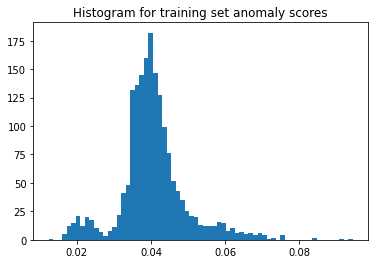

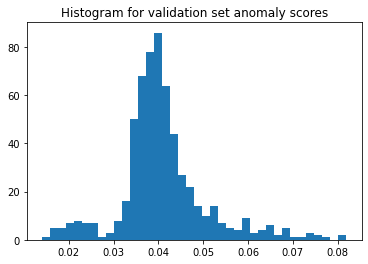

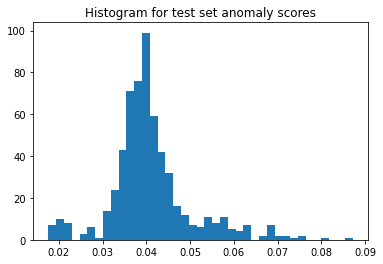

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_56 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_57 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_29 (Dropout)         (None, 16)                0         
_________________________________________________________________
net_output (Dense)           (None, 4)                 68        
_________________________________________________________________
tf.math.subtract_27 (TFOpLam (None, 4)                 0         
_________________________________________________________________
tf.math.pow_27 (TFOpLambda)  (None, 4)                 0  

Epoch 65/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1703 - val_loss: 0.1554
Epoch 66/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1670 - val_loss: 0.1550
Epoch 67/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1672 - val_loss: 0.1546
Epoch 68/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1673 - val_loss: 0.1542
Epoch 69/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1661 - val_loss: 0.1538
Epoch 70/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1679 - val_loss: 0.1533
Epoch 71/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1653 - val_loss: 0.1529
Epoch 72/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1651 - val_loss: 0.1525
Epoch 73/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1651 - val_loss: 0.1521
Epoch 74/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1632 - val_loss: 0.1516


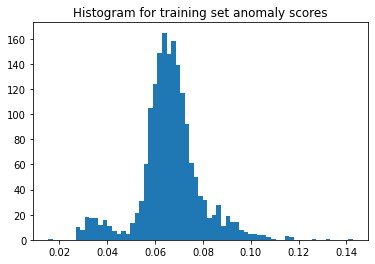

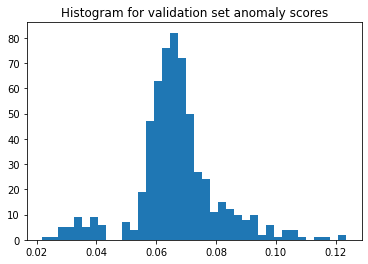

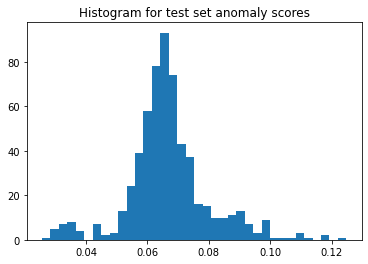

In [28]:
#test batch size
batch_sizelist = [16,32,64,128]
adadelta = Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07)
for x in batch_sizelist:
    clf30 = DeepSVDD(epochs=100, optimizer=adadelta, hidden_neurons=[32, 16, 4], batch_size=x, random_state=42, preprocessing=False, contamination=outlier_ratio)
    clf30.fit(train_arr)
    print('Batch size %d' % x)
    viewOutliers(clf30)

Batch size of 64 seems to give good results. 

5. Multiple-Objective Generative Adversarial Active Learning

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1 of 300

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:
Epoch 2 of 300

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:
Epoch 3 of 300

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:
Epoch 4 of 300

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 index 3:
Epoch 5 of 300

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:

Testing for epoch 5 index 3:
Epoch 6 of 300

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:

Testing for epoch 6 index 3:
Epoch 7 of 300

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:

Testing for epoch 7 index 3:
Epoch 8 of 300

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:

Testing for epoch 8 index 3:
Epoch 9 of 300

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:

Testing for epoch 9 index 3:
Epoch 10 of 300

Testing for epoch 10 index 1:

Testing


Testing for epoch 76 index 3:
Epoch 77 of 300

Testing for epoch 77 index 1:

Testing for epoch 77 index 2:

Testing for epoch 77 index 3:
Epoch 78 of 300

Testing for epoch 78 index 1:

Testing for epoch 78 index 2:

Testing for epoch 78 index 3:
Epoch 79 of 300

Testing for epoch 79 index 1:

Testing for epoch 79 index 2:

Testing for epoch 79 index 3:
Epoch 80 of 300

Testing for epoch 80 index 1:

Testing for epoch 80 index 2:

Testing for epoch 80 index 3:
Epoch 81 of 300

Testing for epoch 81 index 1:

Testing for epoch 81 index 2:

Testing for epoch 81 index 3:
Epoch 82 of 300

Testing for epoch 82 index 1:

Testing for epoch 82 index 2:

Testing for epoch 82 index 3:
Epoch 83 of 300

Testing for epoch 83 index 1:

Testing for epoch 83 index 2:

Testing for epoch 83 index 3:
Epoch 84 of 300

Testing for epoch 84 index 1:

Testing for epoch 84 index 2:

Testing for epoch 84 index 3:
Epoch 85 of 300

Testing for epoch 85 index 1:

Testing for epoch 85 index 2:

Testing for epoch 

16/16 [==============================] - 0s 1ms/step - loss: 0.7370

Testing for epoch 113 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7306

Testing for epoch 113 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7296
Epoch 114 of 300

Testing for epoch 114 index 1:
16/16 [==============================] - 0s 867us/step - loss: 0.7324

Testing for epoch 114 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7318

Testing for epoch 114 index 3:
16/16 [==============================] - 0s 800us/step - loss: 0.7310
Epoch 115 of 300

Testing for epoch 115 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7351

Testing for epoch 115 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7377

Testing for epoch 115 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7400
Epoch 116 of 300

Testing for epoch 116 index 1:
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 1ms/step - loss: 0.7527

Testing for epoch 127 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7588
Epoch 128 of 300

Testing for epoch 128 index 1:
16/16 [==============================] - 0s 867us/step - loss: 0.7615

Testing for epoch 128 index 2:
16/16 [==============================] - 0s 934us/step - loss: 0.7530

Testing for epoch 128 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 0.7588
Epoch 129 of 300

Testing for epoch 129 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7703

Testing for epoch 129 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7630

Testing for epoch 129 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7749
Epoch 130 of 300

Testing for epoch 130 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7643

Testing for epoch 130 index 2:
16/16 [==============================] - 0

16/16 [==============================] - 0s 935us/step - loss: 0.8038

Testing for epoch 141 index 3:
16/16 [==============================] - 0s 934us/step - loss: 0.7945
Epoch 142 of 300

Testing for epoch 142 index 1:
16/16 [==============================] - 0s 865us/step - loss: 0.8054

Testing for epoch 142 index 2:
16/16 [==============================] - 0s 987us/step - loss: 0.7871

Testing for epoch 142 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7989
Epoch 143 of 300

Testing for epoch 143 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8063

Testing for epoch 143 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7984

Testing for epoch 143 index 3:
16/16 [==============================] - 0s 990us/step - loss: 0.8100
Epoch 144 of 300

Testing for epoch 144 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8036

Testing for epoch 144 index 2:
16/16 [==============================] 

16/16 [==============================] - 0s 1ms/step - loss: 0.8354
Epoch 156 of 300

Testing for epoch 156 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8384

Testing for epoch 156 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.8438

Testing for epoch 156 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8473
Epoch 157 of 300

Testing for epoch 157 index 1:
16/16 [==============================] - 0s 955us/step - loss: 0.8607

Testing for epoch 157 index 2:
16/16 [==============================] - 0s 931us/step - loss: 0.8515

Testing for epoch 157 index 3:
16/16 [==============================] - 0s 867us/step - loss: 0.8569
Epoch 158 of 300

Testing for epoch 158 index 1:
16/16 [==============================] - 0s 869us/step - loss: 0.8514

Testing for epoch 158 index 2:
16/16 [==============================] - 0s 903us/step - loss: 0.8530

Testing for epoch 158 index 3:
16/16 [==============================

16/16 [==============================] - 0s 1ms/step - loss: 0.8941
Epoch 170 of 300

Testing for epoch 170 index 1:
16/16 [==============================] - 0s 951us/step - loss: 0.9008

Testing for epoch 170 index 2:
16/16 [==============================] - 0s 802us/step - loss: 0.8934

Testing for epoch 170 index 3:
16/16 [==============================] - 0s 896us/step - loss: 0.9166
Epoch 171 of 300

Testing for epoch 171 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.9024

Testing for epoch 171 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9106

Testing for epoch 171 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8938
Epoch 172 of 300

Testing for epoch 172 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9160

Testing for epoch 172 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9149

Testing for epoch 172 index 3:
16/16 [==============================] - 

16/16 [==============================] - 0s 928us/step - loss: 0.9689
Epoch 184 of 300

Testing for epoch 184 index 1:
16/16 [==============================] - 0s 934us/step - loss: 0.9575

Testing for epoch 184 index 2:
16/16 [==============================] - 0s 899us/step - loss: 0.9781

Testing for epoch 184 index 3:
16/16 [==============================] - 0s 867us/step - loss: 0.9562
Epoch 185 of 300

Testing for epoch 185 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.9705

Testing for epoch 185 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.9919

Testing for epoch 185 index 3:
16/16 [==============================] - 0s 922us/step - loss: 0.9754
Epoch 186 of 300

Testing for epoch 186 index 1:
16/16 [==============================] - ETA: 0s - loss: 1.005 - 0s 976us/step - loss: 0.9674

Testing for epoch 186 index 2:
16/16 [==============================] - 0s 867us/step - loss: 0.9787

Testing for epoch 186 index 3:
16/16 [

16/16 [==============================] - 0s 936us/step - loss: 1.0110
Epoch 198 of 300

Testing for epoch 198 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.0275

Testing for epoch 198 index 2:
16/16 [==============================] - 0s 963us/step - loss: 1.0253

Testing for epoch 198 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.0438
Epoch 199 of 300

Testing for epoch 199 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.0626

Testing for epoch 199 index 2:
16/16 [==============================] - 0s 935us/step - loss: 1.0543

Testing for epoch 199 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.0349
Epoch 200 of 300

Testing for epoch 200 index 1:
16/16 [==============================] - 0s 935us/step - loss: 1.0788

Testing for epoch 200 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.0394

Testing for epoch 200 index 3:
16/16 [============================

16/16 [==============================] - 0s 934us/step - loss: 1.1437
Epoch 212 of 300

Testing for epoch 212 index 1:
16/16 [==============================] - 0s 877us/step - loss: 1.1180

Testing for epoch 212 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.1165

Testing for epoch 212 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.1836
Epoch 213 of 300

Testing for epoch 213 index 1:
16/16 [==============================] - 0s 922us/step - loss: 1.1293

Testing for epoch 213 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.1364

Testing for epoch 213 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0748
Epoch 214 of 300

Testing for epoch 214 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.1563

Testing for epoch 214 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.1407

Testing for epoch 214 index 3:
16/16 [==============================] 

16/16 [==============================] - 0s 999us/step - loss: 1.2122

Testing for epoch 226 index 2:
16/16 [==============================] - 0s 946us/step - loss: 1.2171

Testing for epoch 226 index 3:
16/16 [==============================] - 0s 937us/step - loss: 1.2148
Epoch 227 of 300

Testing for epoch 227 index 1:
16/16 [==============================] - 0s 867us/step - loss: 1.1602

Testing for epoch 227 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 1.2134

Testing for epoch 227 index 3:
16/16 [==============================] - 0s 935us/step - loss: 1.1893
Epoch 228 of 300

Testing for epoch 228 index 1:
16/16 [==============================] - 0s 871us/step - loss: 1.1831

Testing for epoch 228 index 2:
16/16 [==============================] - 0s 913us/step - loss: 1.1987

Testing for epoch 228 index 3:
16/16 [==============================] - 0s 867us/step - loss: 1.2230
Epoch 229 of 300

Testing for epoch 229 index 1:
16/16 [=======================

16/16 [==============================] - 0s 1ms/step - loss: 1.2655

Testing for epoch 240 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.2831

Testing for epoch 240 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.2835
Epoch 241 of 300

Testing for epoch 241 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.3677

Testing for epoch 241 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3056

Testing for epoch 241 index 3:
16/16 [==============================] - 0s 971us/step - loss: 1.3225
Epoch 242 of 300

Testing for epoch 242 index 1:
16/16 [==============================] - 0s 935us/step - loss: 1.2751

Testing for epoch 242 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 1.3121

Testing for epoch 242 index 3:
16/16 [==============================] - 0s 978us/step - loss: 1.2715
Epoch 243 of 300

Testing for epoch 243 index 1:
16/16 [==============================] -


Testing for epoch 254 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3226

Testing for epoch 254 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.4306
Epoch 255 of 300

Testing for epoch 255 index 1:
16/16 [==============================] - 0s 901us/step - loss: 1.3783

Testing for epoch 255 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.3942

Testing for epoch 255 index 3:
16/16 [==============================] - 0s 972us/step - loss: 1.3777
Epoch 256 of 300

Testing for epoch 256 index 1:
16/16 [==============================] - 0s 973us/step - loss: 1.3874

Testing for epoch 256 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.3376

Testing for epoch 256 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.3698
Epoch 257 of 300

Testing for epoch 257 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.4503

Testing for epoch 257 index 2:
16/16

16/16 [==============================] - 0s 933us/step - loss: 1.5104

Testing for epoch 268 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.4466
Epoch 269 of 300

Testing for epoch 269 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.5046

Testing for epoch 269 index 2:
16/16 [==============================] - 0s 950us/step - loss: 1.3805

Testing for epoch 269 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.5112
Epoch 270 of 300

Testing for epoch 270 index 1:
16/16 [==============================] - 0s 868us/step - loss: 1.5020

Testing for epoch 270 index 2:
16/16 [==============================] - ETA: 0s - loss: 1.522 - 0s 936us/step - loss: 1.4836

Testing for epoch 270 index 3:
16/16 [==============================] - 0s 959us/step - loss: 1.4792
Epoch 271 of 300

Testing for epoch 271 index 1:
16/16 [==============================] - 0s 869us/step - loss: 1.4932

Testing for epoch 271 index 2:
16/16 [====

16/16 [==============================] - 0s 933us/step - loss: 1.4923

Testing for epoch 282 index 3:
16/16 [==============================] - 0s 930us/step - loss: 1.5342
Epoch 283 of 300

Testing for epoch 283 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.5204

Testing for epoch 283 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5753

Testing for epoch 283 index 3:
16/16 [==============================] - 0s 935us/step - loss: 1.4801
Epoch 284 of 300

Testing for epoch 284 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.5439

Testing for epoch 284 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5097

Testing for epoch 284 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.5603
Epoch 285 of 300

Testing for epoch 285 index 1:
16/16 [==============================] - 0s 969us/step - loss: 1.5265

Testing for epoch 285 index 2:
16/16 [==============================] 

16/16 [==============================] - 0s 933us/step - loss: 1.6706

Testing for epoch 296 index 3:
16/16 [==============================] - 0s 868us/step - loss: 1.6937
Epoch 297 of 300

Testing for epoch 297 index 1:
16/16 [==============================] - ETA: 0s - loss: 1.519 - 0s 1ms/step - loss: 1.5771

Testing for epoch 297 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.6268

Testing for epoch 297 index 3:
16/16 [==============================] - 0s 930us/step - loss: 1.7255
Epoch 298 of 300

Testing for epoch 298 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.6513

Testing for epoch 298 index 2:
16/16 [==============================] - 0s 867us/step - loss: 1.6334

Testing for epoch 298 index 3:
16/16 [==============================] - 0s 983us/step - loss: 1.6328
Epoch 299 of 300

Testing for epoch 299 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.6145

Testing for epoch 299 index 2:
16/16 [==

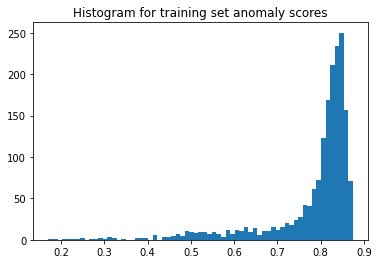

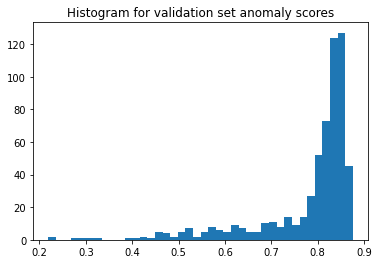

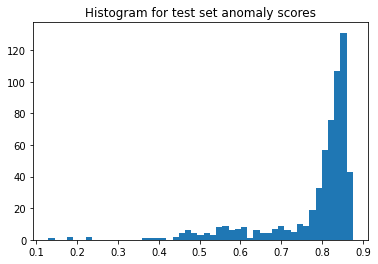

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1 of 300

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:
Epoch 2 of 300

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:
Epoch 3 of 300

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:
Epoch 4 of 300

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 index 3:
Epoch 5 of 300

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:

Testing for epoch 5 index 3:
Epoch 6 of 300

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:

Testing for epoch 6 index 3:
Epoch 7 of 300

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:

Testing for epoch 7 index 3:
Epoch 8 of 300

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:

Testing for epoch 8 index 3:
Epoch 9 of 300

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:

Testing for epoch 9 index 3:
Epoch 10 of 300

Testing for epoch 10 index 1:

Testing


Testing for epoch 76 index 3:
Epoch 77 of 300

Testing for epoch 77 index 1:

Testing for epoch 77 index 2:

Testing for epoch 77 index 3:
Epoch 78 of 300

Testing for epoch 78 index 1:

Testing for epoch 78 index 2:

Testing for epoch 78 index 3:
Epoch 79 of 300

Testing for epoch 79 index 1:

Testing for epoch 79 index 2:

Testing for epoch 79 index 3:
Epoch 80 of 300

Testing for epoch 80 index 1:

Testing for epoch 80 index 2:

Testing for epoch 80 index 3:
Epoch 81 of 300

Testing for epoch 81 index 1:

Testing for epoch 81 index 2:

Testing for epoch 81 index 3:
Epoch 82 of 300

Testing for epoch 82 index 1:

Testing for epoch 82 index 2:

Testing for epoch 82 index 3:
Epoch 83 of 300

Testing for epoch 83 index 1:

Testing for epoch 83 index 2:

Testing for epoch 83 index 3:
Epoch 84 of 300

Testing for epoch 84 index 1:

Testing for epoch 84 index 2:

Testing for epoch 84 index 3:
Epoch 85 of 300

Testing for epoch 85 index 1:

Testing for epoch 85 index 2:

Testing for epoch 

16/16 [==============================] - 0s 970us/step - loss: 0.7264

Testing for epoch 104 index 3:
16/16 [==============================] - ETA: 0s - loss: 0.737 - 0s 1ms/step - loss: 0.7266
Epoch 105 of 300

Testing for epoch 105 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7285

Testing for epoch 105 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7315

Testing for epoch 105 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7324
Epoch 106 of 300

Testing for epoch 106 index 1:
16/16 [==============================] - 0s 969us/step - loss: 0.7289

Testing for epoch 106 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.7329

Testing for epoch 106 index 3:
16/16 [==============================] - 0s 998us/step - loss: 0.7356
Epoch 107 of 300

Testing for epoch 107 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7240

Testing for epoch 107 index 2:
16/16 [==========

16/16 [==============================] - 0s 933us/step - loss: 0.7294

Testing for epoch 113 index 3:
16/16 [==============================] - 0s 934us/step - loss: 0.7362
Epoch 114 of 300

Testing for epoch 114 index 1:
16/16 [==============================] - 0s 868us/step - loss: 0.7311

Testing for epoch 114 index 2:
16/16 [==============================] - 0s 951us/step - loss: 0.7288

Testing for epoch 114 index 3:
16/16 [==============================] - 0s 867us/step - loss: 0.7373
Epoch 115 of 300

Testing for epoch 115 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7361

Testing for epoch 115 index 2:
16/16 [==============================] - ETA: 0s - loss: 0.718 - 0s 934us/step - loss: 0.7339

Testing for epoch 115 index 3:
16/16 [==============================] - 0s 930us/step - loss: 0.7358
Epoch 116 of 300

Testing for epoch 116 index 1:
16/16 [==============================] - 0s 934us/step - loss: 0.7281

Testing for epoch 116 index 2:
16/16 [==

16/16 [==============================] - 0s 1ms/step - loss: 0.7363

Testing for epoch 122 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7445
Epoch 123 of 300

Testing for epoch 123 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7486

Testing for epoch 123 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7463

Testing for epoch 123 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7450
Epoch 124 of 300

Testing for epoch 124 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7383

Testing for epoch 124 index 2:
16/16 [==============================] - 0s 999us/step - loss: 0.7454

Testing for epoch 124 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 0.7495
Epoch 125 of 300

Testing for epoch 125 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.7455

Testing for epoch 125 index 2:
16/16 [==============================] - 0

16/16 [==============================] - 0s 958us/step - loss: 0.7602
Epoch 132 of 300

Testing for epoch 132 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 0.7646

Testing for epoch 132 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.7546

Testing for epoch 132 index 3:
16/16 [==============================] - ETA: 0s - loss: 0.788 - 0s 947us/step - loss: 0.7640
Epoch 133 of 300

Testing for epoch 133 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.7662

Testing for epoch 133 index 2:
16/16 [==============================] - 0s 930us/step - loss: 0.7607

Testing for epoch 133 index 3:
16/16 [==============================] - 0s 933us/step - loss: 0.7619
Epoch 134 of 300

Testing for epoch 134 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7597

Testing for epoch 134 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7654

Testing for epoch 134 index 3:
16/16 [===

16/16 [==============================] - 0s 1ms/step - loss: 0.7757
Epoch 141 of 300

Testing for epoch 141 index 1:
16/16 [==============================] - 0s 935us/step - loss: 0.7811

Testing for epoch 141 index 2:
16/16 [==============================] - 0s 934us/step - loss: 0.7861

Testing for epoch 141 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 0.7810
Epoch 142 of 300

Testing for epoch 142 index 1:
16/16 [==============================] - 0s 936us/step - loss: 0.7740

Testing for epoch 142 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.7812

Testing for epoch 142 index 3:
16/16 [==============================] - 0s 933us/step - loss: 0.7766
Epoch 143 of 300

Testing for epoch 143 index 1:
16/16 [==============================] - 0s 867us/step - loss: 0.7798

Testing for epoch 143 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7881

Testing for epoch 143 index 3:
16/16 [===========================

16/16 [==============================] - 0s 934us/step - loss: 0.8002
Epoch 150 of 300

Testing for epoch 150 index 1:
16/16 [==============================] - 0s 979us/step - loss: 0.7824

Testing for epoch 150 index 2:
16/16 [==============================] - 0s 910us/step - loss: 0.7988

Testing for epoch 150 index 3:
16/16 [==============================] - 0s 902us/step - loss: 0.7977
Epoch 151 of 300

Testing for epoch 151 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.7963

Testing for epoch 151 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8099

Testing for epoch 151 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7974
Epoch 152 of 300

Testing for epoch 152 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8026

Testing for epoch 152 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.8068

Testing for epoch 152 index 3:
16/16 [==============================

16/16 [==============================] - 0s 934us/step - loss: 0.8075

Testing for epoch 159 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 0.8287

Testing for epoch 159 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8254
Epoch 160 of 300

Testing for epoch 160 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.8198

Testing for epoch 160 index 2:
16/16 [==============================] - 0s 800us/step - loss: 0.8231

Testing for epoch 160 index 3:
16/16 [==============================] - 0s 934us/step - loss: 0.8167
Epoch 161 of 300

Testing for epoch 161 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.8162

Testing for epoch 161 index 2:
16/16 [==============================] - 0s 867us/step - loss: 0.8283

Testing for epoch 161 index 3:
16/16 [==============================] - ETA: 0s - loss: 0.917 - 0s 896us/step - loss: 0.8325
Epoch 162 of 300

Testing for epoch 162 index 1:
16/16 [=

16/16 [==============================] - 0s 2ms/step - loss: 0.8476

Testing for epoch 168 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 0.8315

Testing for epoch 168 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8511
Epoch 169 of 300

Testing for epoch 169 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8510

Testing for epoch 169 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8549

Testing for epoch 169 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8500
Epoch 170 of 300

Testing for epoch 170 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8417

Testing for epoch 170 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8367

Testing for epoch 170 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8454
Epoch 171 of 300

Testing for epoch 171 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.8580

Testing for epoch 177 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8672
Epoch 178 of 300

Testing for epoch 178 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8631

Testing for epoch 178 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8661

Testing for epoch 178 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8659
Epoch 179 of 300

Testing for epoch 179 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8733

Testing for epoch 179 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8756

Testing for epoch 179 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8677
Epoch 180 of 300

Testing for epoch 180 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8746

Testing for epoch 180 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.9032
Epoch 187 of 300

Testing for epoch 187 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8911

Testing for epoch 187 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8949

Testing for epoch 187 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9004
Epoch 188 of 300

Testing for epoch 188 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9082

Testing for epoch 188 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9253

Testing for epoch 188 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9320
Epoch 189 of 300

Testing for epoch 189 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9053

Testing for epoch 189 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9085

Testing for epoch 189 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.9180

Testing for epoch 196 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9177

Testing for epoch 196 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9225
Epoch 197 of 300

Testing for epoch 197 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9351

Testing for epoch 197 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9345

Testing for epoch 197 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9344
Epoch 198 of 300

Testing for epoch 198 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9361

Testing for epoch 198 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9360

Testing for epoch 198 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9268
Epoch 199 of 300

Testing for epoch 199 index 1:
16/16 [==============================] - 0s 3ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.9608

Testing for epoch 205 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9832
Epoch 206 of 300

Testing for epoch 206 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9667

Testing for epoch 206 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9433

Testing for epoch 206 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9746
Epoch 207 of 300

Testing for epoch 207 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0016

Testing for epoch 207 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9972

Testing for epoch 207 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9899
Epoch 208 of 300

Testing for epoch 208 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0021

Testing for epoch 208 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.0113
Epoch 215 of 300

Testing for epoch 215 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9871

Testing for epoch 215 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9874

Testing for epoch 215 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0103
Epoch 216 of 300

Testing for epoch 216 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0104

Testing for epoch 216 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0093

Testing for epoch 216 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0077
Epoch 217 of 300

Testing for epoch 217 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0096

Testing for epoch 217 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9857

Testing for epoch 217 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.0097

Testing for epoch 224 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0751

Testing for epoch 224 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0302
Epoch 225 of 300

Testing for epoch 225 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0375

Testing for epoch 225 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0609

Testing for epoch 225 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0386
Epoch 226 of 300

Testing for epoch 226 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0940

Testing for epoch 226 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0462

Testing for epoch 226 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0692
Epoch 227 of 300

Testing for epoch 227 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.1002

Testing for epoch 233 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.1241
Epoch 234 of 300

Testing for epoch 234 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1263

Testing for epoch 234 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0962

Testing for epoch 234 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1129
Epoch 235 of 300

Testing for epoch 235 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0878

Testing for epoch 235 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1103

Testing for epoch 235 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1170
Epoch 236 of 300

Testing for epoch 236 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0917

Testing for epoch 236 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.1501
Epoch 243 of 300

Testing for epoch 243 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1569

Testing for epoch 243 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1344

Testing for epoch 243 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1351
Epoch 244 of 300

Testing for epoch 244 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1545

Testing for epoch 244 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 1.1468

Testing for epoch 244 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1356
Epoch 245 of 300

Testing for epoch 245 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1484

Testing for epoch 245 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1387

Testing for epoch 245 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 1ms/step - loss: 1.2153

Testing for epoch 252 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1729

Testing for epoch 252 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1989
Epoch 253 of 300

Testing for epoch 253 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1711

Testing for epoch 253 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2361

Testing for epoch 253 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2211
Epoch 254 of 300

Testing for epoch 254 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2148

Testing for epoch 254 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2156

Testing for epoch 254 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2047
Epoch 255 of 300

Testing for epoch 255 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.2376

Testing for epoch 261 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2598
Epoch 262 of 300

Testing for epoch 262 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2608

Testing for epoch 262 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2308

Testing for epoch 262 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2592
Epoch 263 of 300

Testing for epoch 263 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2091

Testing for epoch 263 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1916

Testing for epoch 263 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2741
Epoch 264 of 300

Testing for epoch 264 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2502

Testing for epoch 264 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.2311
Epoch 271 of 300

Testing for epoch 271 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2753

Testing for epoch 271 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2764

Testing for epoch 271 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3001
Epoch 272 of 300

Testing for epoch 272 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2581

Testing for epoch 272 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3168

Testing for epoch 272 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3272
Epoch 273 of 300

Testing for epoch 273 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.3446

Testing for epoch 273 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2970

Testing for epoch 273 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.3142

Testing for epoch 280 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3542

Testing for epoch 280 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3192
Epoch 281 of 300

Testing for epoch 281 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.3612

Testing for epoch 281 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3624

Testing for epoch 281 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3219
Epoch 282 of 300

Testing for epoch 282 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4077

Testing for epoch 282 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3373

Testing for epoch 282 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3327
Epoch 283 of 300

Testing for epoch 283 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 1ms/step - loss: 1.3853

Testing for epoch 289 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4162
Epoch 290 of 300

Testing for epoch 290 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.3949

Testing for epoch 290 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4937

Testing for epoch 290 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3990
Epoch 291 of 300

Testing for epoch 291 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.3580

Testing for epoch 291 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3682

Testing for epoch 291 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4183
Epoch 292 of 300

Testing for epoch 292 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.3836

Testing for epoch 292 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.4501
Epoch 299 of 300

Testing for epoch 299 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4363

Testing for epoch 299 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4044

Testing for epoch 299 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3588
Epoch 300 of 300

Testing for epoch 300 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4613

Testing for epoch 300 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4630

Testing for epoch 300 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4493
k value 8


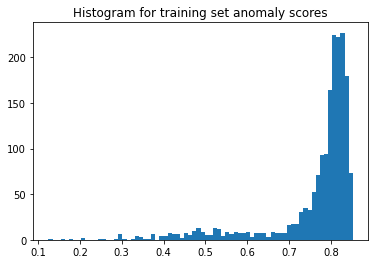

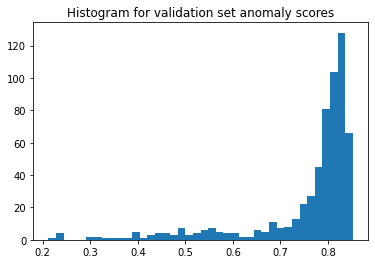

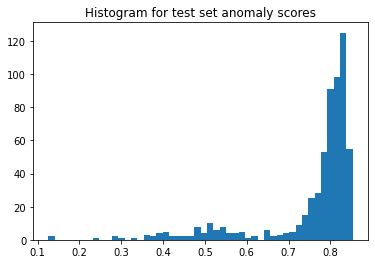

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1 of 300

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:
Epoch 2 of 300

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:
Epoch 3 of 300

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:
Epoch 4 of 300

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 index 3:
Epoch 5 of 300

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:

Testing for epoch 5 index 3:
Epoch 6 of 300

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:

Testing for epoch 6 index 3:
Epoch 7 of 300

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:

Testing for epoch 7 index 3:
Epoch 8 of 300

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:

Testing for epoch 8 index 3:
Epoch 9 of 300

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:

Testing for epoch 9 index 3:
Epoch 10 of 300

Testing for epoch 10 index 1:

Testing


Testing for epoch 76 index 3:
Epoch 77 of 300

Testing for epoch 77 index 1:

Testing for epoch 77 index 2:

Testing for epoch 77 index 3:
Epoch 78 of 300

Testing for epoch 78 index 1:

Testing for epoch 78 index 2:

Testing for epoch 78 index 3:
Epoch 79 of 300

Testing for epoch 79 index 1:

Testing for epoch 79 index 2:

Testing for epoch 79 index 3:
Epoch 80 of 300

Testing for epoch 80 index 1:

Testing for epoch 80 index 2:

Testing for epoch 80 index 3:
Epoch 81 of 300

Testing for epoch 81 index 1:

Testing for epoch 81 index 2:

Testing for epoch 81 index 3:
Epoch 82 of 300

Testing for epoch 82 index 1:

Testing for epoch 82 index 2:

Testing for epoch 82 index 3:
Epoch 83 of 300

Testing for epoch 83 index 1:

Testing for epoch 83 index 2:

Testing for epoch 83 index 3:
Epoch 84 of 300

Testing for epoch 84 index 1:

Testing for epoch 84 index 2:

Testing for epoch 84 index 3:
Epoch 85 of 300

Testing for epoch 85 index 1:

Testing for epoch 85 index 2:

Testing for epoch 

16/16 [==============================] - 0s 2ms/step - loss: 0.8246
Epoch 108 of 300

Testing for epoch 108 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8287

Testing for epoch 108 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8278

Testing for epoch 108 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8386
Epoch 109 of 300

Testing for epoch 109 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8330

Testing for epoch 109 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8375

Testing for epoch 109 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8430
Epoch 110 of 300

Testing for epoch 110 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8363

Testing for epoch 110 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8373

Testing for epoch 110 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.8522

Testing for epoch 115 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8622

Testing for epoch 115 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8593
Epoch 116 of 300

Testing for epoch 116 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8423

Testing for epoch 116 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8624

Testing for epoch 116 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8789
Epoch 117 of 300

Testing for epoch 117 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8707

Testing for epoch 117 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8509

Testing for epoch 117 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8632
Epoch 118 of 300

Testing for epoch 118 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.8738
Epoch 123 of 300

Testing for epoch 123 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8899

Testing for epoch 123 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8774

Testing for epoch 123 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8856
Epoch 124 of 300

Testing for epoch 124 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8865

Testing for epoch 124 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8823

Testing for epoch 124 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 0.8965
Epoch 125 of 300

Testing for epoch 125 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8964

Testing for epoch 125 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8865

Testing for epoch 125 index 3:
16/16 [==============================] - 0s 2m

16/16 [==============================] - 0s 2ms/step - loss: 0.9301

Testing for epoch 130 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9215
Epoch 131 of 300

Testing for epoch 131 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9306

Testing for epoch 131 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9267

Testing for epoch 131 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9318
Epoch 132 of 300

Testing for epoch 132 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9197

Testing for epoch 132 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9244

Testing for epoch 132 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9375
Epoch 133 of 300

Testing for epoch 133 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9531

Testing for epoch 133 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.9530

Testing for epoch 138 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9747

Testing for epoch 138 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 0.9835
Epoch 139 of 300

Testing for epoch 139 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9833

Testing for epoch 139 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9532

Testing for epoch 139 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9864
Epoch 140 of 300

Testing for epoch 140 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9879

Testing for epoch 140 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0119

Testing for epoch 140 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9631
Epoch 141 of 300

Testing for epoch 141 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.0196

Testing for epoch 145 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9993
Epoch 146 of 300

Testing for epoch 146 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9985

Testing for epoch 146 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0146

Testing for epoch 146 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9885
Epoch 147 of 300

Testing for epoch 147 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0409

Testing for epoch 147 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0238

Testing for epoch 147 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0275
Epoch 148 of 300

Testing for epoch 148 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0629

Testing for epoch 148 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.0769

Testing for epoch 153 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0517

Testing for epoch 153 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0665
Epoch 154 of 300

Testing for epoch 154 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0688

Testing for epoch 154 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0587

Testing for epoch 154 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0633
Epoch 155 of 300

Testing for epoch 155 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0827

Testing for epoch 155 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0809

Testing for epoch 155 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1261
Epoch 156 of 300

Testing for epoch 156 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.1120
Epoch 161 of 300

Testing for epoch 161 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1114

Testing for epoch 161 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1328

Testing for epoch 161 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1040
Epoch 162 of 300

Testing for epoch 162 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1176

Testing for epoch 162 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1261

Testing for epoch 162 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1353
Epoch 163 of 300

Testing for epoch 163 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1410

Testing for epoch 163 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1134

Testing for epoch 163 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.1773

Testing for epoch 168 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1563
Epoch 169 of 300

Testing for epoch 169 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.1351

Testing for epoch 169 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1835

Testing for epoch 169 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1929
Epoch 170 of 300

Testing for epoch 170 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1419

Testing for epoch 170 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2132

Testing for epoch 170 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2007
Epoch 171 of 300

Testing for epoch 171 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1538

Testing for epoch 171 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.2252
Epoch 176 of 300

Testing for epoch 176 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2296

Testing for epoch 176 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2363

Testing for epoch 176 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2134
Epoch 177 of 300

Testing for epoch 177 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2753

Testing for epoch 177 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2123

Testing for epoch 177 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2640
Epoch 178 of 300

Testing for epoch 178 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2266

Testing for epoch 178 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2209

Testing for epoch 178 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.2719

Testing for epoch 183 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2767
Epoch 184 of 300

Testing for epoch 184 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.3368

Testing for epoch 184 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3112

Testing for epoch 184 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2708
Epoch 185 of 300

Testing for epoch 185 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2803

Testing for epoch 185 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2956

Testing for epoch 185 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3015
Epoch 186 of 300

Testing for epoch 186 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.3333

Testing for epoch 186 index 2:
16/16 [==============================] - 0s 1ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.3246

Testing for epoch 191 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3331

Testing for epoch 191 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3463
Epoch 192 of 300

Testing for epoch 192 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2912

Testing for epoch 192 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3677

Testing for epoch 192 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3815
Epoch 193 of 300

Testing for epoch 193 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2960

Testing for epoch 193 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4325

Testing for epoch 193 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3513
Epoch 194 of 300

Testing for epoch 194 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.4208
Epoch 199 of 300

Testing for epoch 199 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.4765

Testing for epoch 199 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3290

Testing for epoch 199 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4285
Epoch 200 of 300

Testing for epoch 200 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.3507

Testing for epoch 200 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3866

Testing for epoch 200 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4042
Epoch 201 of 300

Testing for epoch 201 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.3864

Testing for epoch 201 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3842

Testing for epoch 201 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 1ms/step - loss: 1.4059

Testing for epoch 206 index 2:
16/16 [==============================] - 0s 4ms/step - loss: 1.4126

Testing for epoch 206 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4090
Epoch 207 of 300

Testing for epoch 207 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.5256

Testing for epoch 207 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 1.4454

Testing for epoch 207 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4833
Epoch 208 of 300

Testing for epoch 208 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4118

Testing for epoch 208 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.4897

Testing for epoch 208 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4813
Epoch 209 of 300

Testing for epoch 209 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.5127
Epoch 214 of 300

Testing for epoch 214 index 1:
16/16 [==============================] - 0s 4ms/step - loss: 1.5174

Testing for epoch 214 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.5090

Testing for epoch 214 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4993
Epoch 215 of 300

Testing for epoch 215 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4771

Testing for epoch 215 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4655

Testing for epoch 215 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5626
Epoch 216 of 300

Testing for epoch 216 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4822

Testing for epoch 216 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.5570

Testing for epoch 216 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.5399

Testing for epoch 221 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5369
Epoch 222 of 300

Testing for epoch 222 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.5338

Testing for epoch 222 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4779

Testing for epoch 222 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5697
Epoch 223 of 300

Testing for epoch 223 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.6111

Testing for epoch 223 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.5530

Testing for epoch 223 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5842
Epoch 224 of 300

Testing for epoch 224 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.6243

Testing for epoch 224 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.5436

Testing for epoch 229 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.6038

Testing for epoch 229 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5803
Epoch 230 of 300

Testing for epoch 230 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.5379

Testing for epoch 230 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.5238

Testing for epoch 230 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.6299
Epoch 231 of 300

Testing for epoch 231 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.5817

Testing for epoch 231 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 1.6157

Testing for epoch 231 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.6156
Epoch 232 of 300

Testing for epoch 232 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 1ms/step - loss: 1.6037

Testing for epoch 236 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5694
Epoch 237 of 300

Testing for epoch 237 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.5735

Testing for epoch 237 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.6629

Testing for epoch 237 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.6058
Epoch 238 of 300

Testing for epoch 238 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.6703

Testing for epoch 238 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.6151

Testing for epoch 238 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.6589
Epoch 239 of 300

Testing for epoch 239 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.7182

Testing for epoch 239 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.7627

Testing for epoch 244 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.7270

Testing for epoch 244 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.6810
Epoch 245 of 300

Testing for epoch 245 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.7095

Testing for epoch 245 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.6227

Testing for epoch 245 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.7860
Epoch 246 of 300

Testing for epoch 246 index 1:
16/16 [==============================] - 0s 4ms/step - loss: 1.7444

Testing for epoch 246 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.7691

Testing for epoch 246 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.8094
Epoch 247 of 300

Testing for epoch 247 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.7295
Epoch 252 of 300

Testing for epoch 252 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.7475

Testing for epoch 252 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.7166

Testing for epoch 252 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.7900
Epoch 253 of 300

Testing for epoch 253 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 1.7149

Testing for epoch 253 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.7277

Testing for epoch 253 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.7598
Epoch 254 of 300

Testing for epoch 254 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8276

Testing for epoch 254 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.7308

Testing for epoch 254 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.8322

Testing for epoch 259 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.7717
Epoch 260 of 300

Testing for epoch 260 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 1.7552

Testing for epoch 260 index 2:
16/16 [==============================] - 0s 4ms/step - loss: 1.8694

Testing for epoch 260 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.8091
Epoch 261 of 300

Testing for epoch 261 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8466

Testing for epoch 261 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.8264

Testing for epoch 261 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.7824
Epoch 262 of 300

Testing for epoch 262 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8529

Testing for epoch 262 index 2:
16/16 [==============================] - 0s 3ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.8449
Epoch 267 of 300

Testing for epoch 267 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8245

Testing for epoch 267 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.7840

Testing for epoch 267 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.8143
Epoch 268 of 300

Testing for epoch 268 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8731

Testing for epoch 268 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.8062

Testing for epoch 268 index 3:
16/16 [==============================] - 0s 4ms/step - loss: 1.8678
Epoch 269 of 300

Testing for epoch 269 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.9154

Testing for epoch 269 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.8976

Testing for epoch 269 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.7964

Testing for epoch 274 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.9309
Epoch 275 of 300

Testing for epoch 275 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.9111

Testing for epoch 275 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.8409

Testing for epoch 275 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.9337
Epoch 276 of 300

Testing for epoch 276 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8771

Testing for epoch 276 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 1.9072

Testing for epoch 276 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.8923
Epoch 277 of 300

Testing for epoch 277 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8735

Testing for epoch 277 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.9552

Testing for epoch 282 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9912

Testing for epoch 282 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.9535
Epoch 283 of 300

Testing for epoch 283 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.9101

Testing for epoch 283 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9689

Testing for epoch 283 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.9718
Epoch 284 of 300

Testing for epoch 284 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.9987

Testing for epoch 284 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 2.0205

Testing for epoch 284 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.8753
Epoch 285 of 300

Testing for epoch 285 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 2.0625
Epoch 290 of 300

Testing for epoch 290 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8542

Testing for epoch 290 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 2.0752

Testing for epoch 290 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.9962
Epoch 291 of 300

Testing for epoch 291 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 2.0449

Testing for epoch 291 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 2.0868

Testing for epoch 291 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 2.0808
Epoch 292 of 300

Testing for epoch 292 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 2.0801

Testing for epoch 292 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9931

Testing for epoch 292 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 2.0087

Testing for epoch 297 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 2.0393

Testing for epoch 297 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.9323
Epoch 298 of 300

Testing for epoch 298 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 2.0864

Testing for epoch 298 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 2.0981

Testing for epoch 298 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.9976
Epoch 299 of 300

Testing for epoch 299 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 2.1491

Testing for epoch 299 index 2:
16/16 [==============================] - 0s 4ms/step - loss: 2.0391

Testing for epoch 299 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 2.1121
Epoch 300 of 300

Testing for epoch 300 index 1:
16/16 [==============================] - 0s 2ms/s

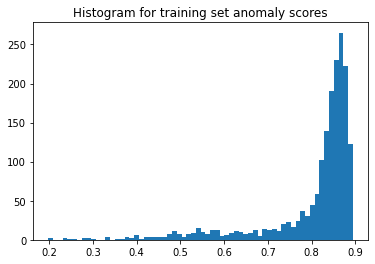

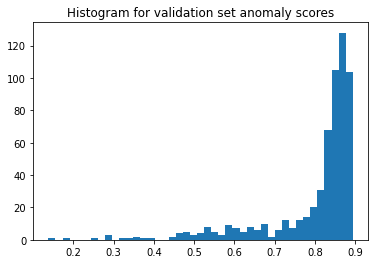

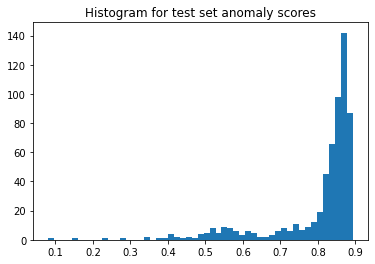

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1 of 300

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:
Epoch 2 of 300

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:
Epoch 3 of 300

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:
Epoch 4 of 300

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 index 3:
Epoch 5 of 300

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:

Testing for epoch 5 index 3:
Epoch 6 of 300

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:

Testing for epoch 6 index 3:
Epoch 7 of 300

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:

Testing for epoch 7 index 3:
Epoch 8 of 300

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:

Testing for epoch 8 index 3:
Epoch 9 of 300

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:

Testing for epoch 9 index 3:
Epoch 10 of 300

Testing for epoch 10 index 1:

Testing


Testing for epoch 76 index 3:
Epoch 77 of 300

Testing for epoch 77 index 1:

Testing for epoch 77 index 2:

Testing for epoch 77 index 3:
Epoch 78 of 300

Testing for epoch 78 index 1:

Testing for epoch 78 index 2:

Testing for epoch 78 index 3:
Epoch 79 of 300

Testing for epoch 79 index 1:

Testing for epoch 79 index 2:

Testing for epoch 79 index 3:
Epoch 80 of 300

Testing for epoch 80 index 1:

Testing for epoch 80 index 2:

Testing for epoch 80 index 3:
Epoch 81 of 300

Testing for epoch 81 index 1:

Testing for epoch 81 index 2:

Testing for epoch 81 index 3:
Epoch 82 of 300

Testing for epoch 82 index 1:

Testing for epoch 82 index 2:

Testing for epoch 82 index 3:
Epoch 83 of 300

Testing for epoch 83 index 1:

Testing for epoch 83 index 2:

Testing for epoch 83 index 3:
Epoch 84 of 300

Testing for epoch 84 index 1:

Testing for epoch 84 index 2:

Testing for epoch 84 index 3:
Epoch 85 of 300

Testing for epoch 85 index 1:

Testing for epoch 85 index 2:

Testing for epoch 

16/16 [==============================] - 0s 2ms/step - loss: 0.7911

Testing for epoch 106 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8056

Testing for epoch 106 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7953
Epoch 107 of 300

Testing for epoch 107 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7995

Testing for epoch 107 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8019

Testing for epoch 107 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8136
Epoch 108 of 300

Testing for epoch 108 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8063

Testing for epoch 108 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8005

Testing for epoch 108 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8128
Epoch 109 of 300

Testing for epoch 109 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.8039

Testing for epoch 112 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8207

Testing for epoch 112 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8183
Epoch 113 of 300

Testing for epoch 113 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8131

Testing for epoch 113 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 0.8264

Testing for epoch 113 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8168
Epoch 114 of 300

Testing for epoch 114 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8266

Testing for epoch 114 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8299

Testing for epoch 114 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8363
Epoch 115 of 300

Testing for epoch 115 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.8297

Testing for epoch 118 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8315

Testing for epoch 118 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8501
Epoch 119 of 300

Testing for epoch 119 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8289

Testing for epoch 119 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8395

Testing for epoch 119 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8379
Epoch 120 of 300

Testing for epoch 120 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8422

Testing for epoch 120 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8439

Testing for epoch 120 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8578
Epoch 121 of 300

Testing for epoch 121 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.8569
Epoch 124 of 300

Testing for epoch 124 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8795

Testing for epoch 124 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8539

Testing for epoch 124 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8676
Epoch 125 of 300

Testing for epoch 125 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8581

Testing for epoch 125 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8686

Testing for epoch 125 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8754
Epoch 126 of 300

Testing for epoch 126 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8958

Testing for epoch 126 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8639

Testing for epoch 126 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.8773
Epoch 130 of 300

Testing for epoch 130 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8948

Testing for epoch 130 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8907

Testing for epoch 130 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8970
Epoch 131 of 300

Testing for epoch 131 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8700

Testing for epoch 131 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9100

Testing for epoch 131 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9029
Epoch 132 of 300

Testing for epoch 132 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9029

Testing for epoch 132 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9105

Testing for epoch 132 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 4ms/step - loss: 0.9114
Epoch 136 of 300

Testing for epoch 136 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9311

Testing for epoch 136 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9152

Testing for epoch 136 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 0.9229
Epoch 137 of 300

Testing for epoch 137 index 1:
16/16 [==============================] - 0s 4ms/step - loss: 0.9289

Testing for epoch 137 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9311

Testing for epoch 137 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9312
Epoch 138 of 300

Testing for epoch 138 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9063

Testing for epoch 138 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 0.9248

Testing for epoch 138 index 3:
16/16 [==============================] - 0s 4ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.9533
Epoch 142 of 300

Testing for epoch 142 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 0.9480

Testing for epoch 142 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9650

Testing for epoch 142 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9757
Epoch 143 of 300

Testing for epoch 143 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9553

Testing for epoch 143 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9729

Testing for epoch 143 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9860
Epoch 144 of 300

Testing for epoch 144 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9688

Testing for epoch 144 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9578


16/16 [==============================] - 0s 2ms/step - loss: 0.9625

Testing for epoch 144 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9790
Epoch 145 of 300

Testing for epoch 145 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9603

Testing for epoch 145 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9516

Testing for epoch 145 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 0.9647
Epoch 146 of 300

Testing for epoch 146 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 0.9771

Testing for epoch 146 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9653

Testing for epoch 146 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 0.9990
Epoch 147 of 300

Testing for epoch 147 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9570

Testing for epoch 147 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 3ms/step - loss: 0.9826

Testing for epoch 150 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0253
Epoch 151 of 300

Testing for epoch 151 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 0.9944

Testing for epoch 151 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0102

Testing for epoch 151 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9856
Epoch 152 of 300

Testing for epoch 152 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0144

Testing for epoch 152 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0344

Testing for epoch 152 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.0256
Epoch 153 of 300

Testing for epoch 153 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 1.0029

Testing for epoch 153 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 4ms/step - loss: 1.0404

Testing for epoch 156 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0417
Epoch 157 of 300

Testing for epoch 157 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9998

Testing for epoch 157 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0453

Testing for epoch 157 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0166
Epoch 158 of 300

Testing for epoch 158 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.0353

Testing for epoch 158 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 1.0466

Testing for epoch 158 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0648
Epoch 159 of 300

Testing for epoch 159 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0633

Testing for epoch 159 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.0916

Testing for epoch 162 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0341
Epoch 163 of 300

Testing for epoch 163 index 1:
16/16 [==============================] - 0s 4ms/step - loss: 1.0630

Testing for epoch 163 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0897

Testing for epoch 163 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0905
Epoch 164 of 300

Testing for epoch 164 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0616

Testing for epoch 164 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 1.1067

Testing for epoch 164 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0800
Epoch 165 of 300

Testing for epoch 165 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 1.0852


16/16 [==============================] - 0s 2ms/step - loss: 1.0934

Testing for epoch 165 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0972

Testing for epoch 165 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0818
Epoch 166 of 300

Testing for epoch 166 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0832

Testing for epoch 166 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1038

Testing for epoch 166 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1029
Epoch 167 of 300

Testing for epoch 167 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1250

Testing for epoch 167 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0702

Testing for epoch 167 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1034
Epoch 168 of 300

Testing for epoch 168 index 1:
16/16 [==============================] - 0s 3ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.1221

Testing for epoch 171 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1227

Testing for epoch 171 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1457
Epoch 172 of 300

Testing for epoch 172 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1195

Testing for epoch 172 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1144

Testing for epoch 172 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1256
Epoch 173 of 300

Testing for epoch 173 index 1:
16/16 [==============================] - 0s 4ms/step - loss: 1.1142

Testing for epoch 173 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 1.1369

Testing for epoch 173 index 3:
16/16 [==============================] - 0s 4ms/step - loss: 1.1044
Epoch 174 of 300

Testing for epoch 174 index 1:
16/16 [==============================] - 0s 3ms/s

16/16 [==============================] - 0s 4ms/step - loss: 1.1754

Testing for epoch 177 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2019

Testing for epoch 177 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1786
Epoch 178 of 300

Testing for epoch 178 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1362

Testing for epoch 178 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1502

Testing for epoch 178 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2174
Epoch 179 of 300

Testing for epoch 179 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1930

Testing for epoch 179 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2248

Testing for epoch 179 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1871
Epoch 180 of 300

Testing for epoch 180 index 1:
16/16 [==============================] - 0s 3ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.1943

Testing for epoch 183 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2202

Testing for epoch 183 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1978
Epoch 184 of 300

Testing for epoch 184 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2311

Testing for epoch 184 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1953

Testing for epoch 184 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.2256
Epoch 185 of 300

Testing for epoch 185 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2002

Testing for epoch 185 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2003

Testing for epoch 185 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2088
Epoch 186 of 300

Testing for epoch 186 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.2116
Epoch 189 of 300

Testing for epoch 189 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 1.2478

Testing for epoch 189 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2507

Testing for epoch 189 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.2454
Epoch 190 of 300

Testing for epoch 190 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 1.1901

Testing for epoch 190 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2659

Testing for epoch 190 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2391
Epoch 191 of 300

Testing for epoch 191 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2444

Testing for epoch 191 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 1.3110

Testing for epoch 191 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.2456
Epoch 195 of 300

Testing for epoch 195 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2950

Testing for epoch 195 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2992

Testing for epoch 195 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3124
Epoch 196 of 300

Testing for epoch 196 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 1.2461

Testing for epoch 196 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2946

Testing for epoch 196 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2633
Epoch 197 of 300

Testing for epoch 197 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2791

Testing for epoch 197 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2618

Testing for epoch 197 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.3486
Epoch 201 of 300

Testing for epoch 201 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.3683

Testing for epoch 201 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3458

Testing for epoch 201 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3107
Epoch 202 of 300

Testing for epoch 202 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.3102

Testing for epoch 202 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2644

Testing for epoch 202 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3387
Epoch 203 of 300

Testing for epoch 203 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 1.3646

Testing for epoch 203 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3288

Testing for epoch 203 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 4ms/step - loss: 1.3417

Testing for epoch 206 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4251
Epoch 207 of 300

Testing for epoch 207 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.3904

Testing for epoch 207 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 1.3566

Testing for epoch 207 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.3488
Epoch 208 of 300

Testing for epoch 208 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4032

Testing for epoch 208 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3706

Testing for epoch 208 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3677
Epoch 209 of 300

Testing for epoch 209 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.3729

Testing for epoch 209 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.4058

Testing for epoch 212 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3761
Epoch 213 of 300

Testing for epoch 213 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4112

Testing for epoch 213 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4294

Testing for epoch 213 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3551
Epoch 214 of 300

Testing for epoch 214 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4113

Testing for epoch 214 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4040

Testing for epoch 214 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3983
Epoch 215 of 300

Testing for epoch 215 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4841

Testing for epoch 215 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.4292

Testing for epoch 218 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4118
Epoch 219 of 300

Testing for epoch 219 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4832

Testing for epoch 219 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4418

Testing for epoch 219 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4662
Epoch 220 of 300

Testing for epoch 220 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4462

Testing for epoch 220 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4171

Testing for epoch 220 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5059
Epoch 221 of 300

Testing for epoch 221 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4712

Testing for epoch 221 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.4389

Testing for epoch 224 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5033
Epoch 225 of 300

Testing for epoch 225 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.5432

Testing for epoch 225 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.5194

Testing for epoch 225 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4634
Epoch 226 of 300

Testing for epoch 226 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4546

Testing for epoch 226 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4967

Testing for epoch 226 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4792
Epoch 227 of 300

Testing for epoch 227 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4780


16/16 [==============================] - 0s 2ms/step - loss: 1.4955

Testing for epoch 227 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4866

Testing for epoch 227 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4668
Epoch 228 of 300

Testing for epoch 228 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.5553

Testing for epoch 228 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.5262

Testing for epoch 228 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5589
Epoch 229 of 300

Testing for epoch 229 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4985

Testing for epoch 229 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4512

Testing for epoch 229 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5542
Epoch 230 of 300

Testing for epoch 230 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 1ms/step - loss: 1.5631

Testing for epoch 233 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.5798

Testing for epoch 233 index 3:
16/16 [==============================] - 0s 5ms/step - loss: 1.5409
Epoch 234 of 300

Testing for epoch 234 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.5447

Testing for epoch 234 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.5685

Testing for epoch 234 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5440
Epoch 235 of 300

Testing for epoch 235 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.5588

Testing for epoch 235 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.6044

Testing for epoch 235 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.5521
Epoch 236 of 300

Testing for epoch 236 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 5ms/step - loss: 1.5810

Testing for epoch 239 index 2:
16/16 [==============================] - 0s 4ms/step - loss: 1.5872

Testing for epoch 239 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5964
Epoch 240 of 300

Testing for epoch 240 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.5503

Testing for epoch 240 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.6210

Testing for epoch 240 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.6454
Epoch 241 of 300

Testing for epoch 241 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.6387

Testing for epoch 241 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.5794

Testing for epoch 241 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.6597
Epoch 242 of 300

Testing for epoch 242 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.6142

Testing for epoch 245 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.6414

Testing for epoch 245 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.6436
Epoch 246 of 300

Testing for epoch 246 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.6365

Testing for epoch 246 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.6496

Testing for epoch 246 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5858
Epoch 247 of 300

Testing for epoch 247 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.6965

Testing for epoch 247 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.6886

Testing for epoch 247 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.6640
Epoch 248 of 300

Testing for epoch 248 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.5731
Epoch 251 of 300

Testing for epoch 251 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.7034

Testing for epoch 251 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.7426

Testing for epoch 251 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.6646
Epoch 252 of 300

Testing for epoch 252 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.6470

Testing for epoch 252 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.6200

Testing for epoch 252 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.7235
Epoch 253 of 300

Testing for epoch 253 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.6546

Testing for epoch 253 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.7322

Testing for epoch 253 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.6424
Epoch 257 of 300

Testing for epoch 257 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.7234

Testing for epoch 257 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.6862

Testing for epoch 257 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.6591
Epoch 258 of 300

Testing for epoch 258 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.7259

Testing for epoch 258 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.7685

Testing for epoch 258 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.7645
Epoch 259 of 300

Testing for epoch 259 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.6625

Testing for epoch 259 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.7727

Testing for epoch 259 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.7607
Epoch 263 of 300

Testing for epoch 263 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.7149

Testing for epoch 263 index 2:
16/16 [==============================] - 0s 5ms/step - loss: 1.7048

Testing for epoch 263 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.8370
Epoch 264 of 300

Testing for epoch 264 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 1.7382

Testing for epoch 264 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.8345

Testing for epoch 264 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.7081
Epoch 265 of 300

Testing for epoch 265 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.6713

Testing for epoch 265 index 2:
16/16 [==============================] - 0s 5ms/step - loss: 1.7634

Testing for epoch 265 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.8360

Testing for epoch 268 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.8160
Epoch 269 of 300

Testing for epoch 269 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8725

Testing for epoch 269 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.7856

Testing for epoch 269 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.7243
Epoch 270 of 300

Testing for epoch 270 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8136

Testing for epoch 270 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.8334

Testing for epoch 270 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.7948
Epoch 271 of 300

Testing for epoch 271 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8631

Testing for epoch 271 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.8310

Testing for epoch 274 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.8019
Epoch 275 of 300

Testing for epoch 275 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8057

Testing for epoch 275 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.7868

Testing for epoch 275 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.9321
Epoch 276 of 300

Testing for epoch 276 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8184

Testing for epoch 276 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.8749

Testing for epoch 276 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.9100
Epoch 277 of 300

Testing for epoch 277 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8669

Testing for epoch 277 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.9346

Testing for epoch 280 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.8348
Epoch 281 of 300

Testing for epoch 281 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8546

Testing for epoch 281 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9033

Testing for epoch 281 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.9661
Epoch 282 of 300

Testing for epoch 282 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 1.8741

Testing for epoch 282 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.8940

Testing for epoch 282 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.8848
Epoch 283 of 300

Testing for epoch 283 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8998

Testing for epoch 283 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.8382

Testing for epoch 286 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.8994
Epoch 287 of 300

Testing for epoch 287 index 1:
16/16 [==============================] - 0s 4ms/step - loss: 1.9355

Testing for epoch 287 index 2:
16/16 [==============================] - 0s 4ms/step - loss: 1.9592

Testing for epoch 287 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.9043
Epoch 288 of 300

Testing for epoch 288 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.9911

Testing for epoch 288 index 2:
16/16 [==============================] - 0s 4ms/step - loss: 1.9164

Testing for epoch 288 index 3:
16/16 [==============================] - 0s 4ms/step - loss: 1.8525
Epoch 289 of 300

Testing for epoch 289 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8883


16/16 [==============================] - 0s 2ms/step - loss: 1.9130

Testing for epoch 289 index 2:
16/16 [==============================] - 0s 5ms/step - loss: 1.9625

Testing for epoch 289 index 3:
16/16 [==============================] - 0s 5ms/step - loss: 2.0040
Epoch 290 of 300

Testing for epoch 290 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.9880

Testing for epoch 290 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 2.0165

Testing for epoch 290 index 3:
16/16 [==============================] - 0s 4ms/step - loss: 2.0161
Epoch 291 of 300

Testing for epoch 291 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8897

Testing for epoch 291 index 2:
16/16 [==============================] - 0s 4ms/step - loss: 1.9292

Testing for epoch 291 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.8846
Epoch 292 of 300

Testing for epoch 292 index 1:
16/16 [==============================] - 0s 3ms/s

16/16 [==============================] - 0s 4ms/step - loss: 1.9477

Testing for epoch 295 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9559

Testing for epoch 295 index 3:
16/16 [==============================] - 0s 5ms/step - loss: 2.0169
Epoch 296 of 300

Testing for epoch 296 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 2.0269

Testing for epoch 296 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9323

Testing for epoch 296 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.9153
Epoch 297 of 300

Testing for epoch 297 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.9285

Testing for epoch 297 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9303

Testing for epoch 297 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.9729
Epoch 298 of 300

Testing for epoch 298 index 1:
16/16 [==============================] - 0s 2ms/s

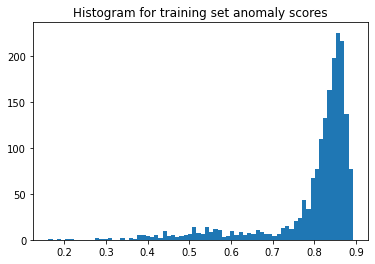

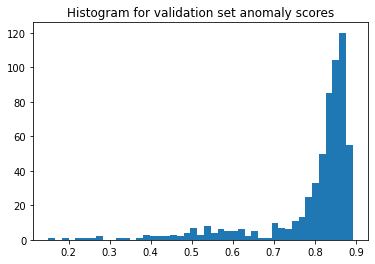

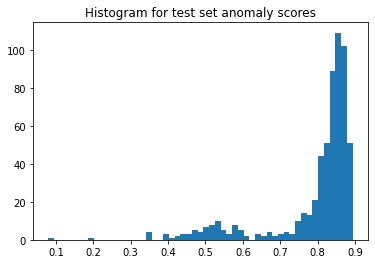

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1 of 300

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:
Epoch 2 of 300

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:
Epoch 3 of 300

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:
Epoch 4 of 300

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 index 3:
Epoch 5 of 300

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:

Testing for epoch 5 index 3:
Epoch 6 of 300

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:

Testing for epoch 6 index 3:
Epoch 7 of 300

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:

Testing for epoch 7 index 3:
Epoch 8 of 300

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:

Testing for epoch 8 index 3:
Epoch 9 of 300

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:

Testing for epoch 9 index 3:
Epoch 10 of 300

Testing for epoch 10 index 1:

Testing


Testing for epoch 76 index 3:
Epoch 77 of 300

Testing for epoch 77 index 1:

Testing for epoch 77 index 2:

Testing for epoch 77 index 3:
Epoch 78 of 300

Testing for epoch 78 index 1:

Testing for epoch 78 index 2:

Testing for epoch 78 index 3:
Epoch 79 of 300

Testing for epoch 79 index 1:

Testing for epoch 79 index 2:

Testing for epoch 79 index 3:
Epoch 80 of 300

Testing for epoch 80 index 1:

Testing for epoch 80 index 2:

Testing for epoch 80 index 3:
Epoch 81 of 300

Testing for epoch 81 index 1:

Testing for epoch 81 index 2:

Testing for epoch 81 index 3:
Epoch 82 of 300

Testing for epoch 82 index 1:

Testing for epoch 82 index 2:

Testing for epoch 82 index 3:
Epoch 83 of 300

Testing for epoch 83 index 1:

Testing for epoch 83 index 2:

Testing for epoch 83 index 3:
Epoch 84 of 300

Testing for epoch 84 index 1:

Testing for epoch 84 index 2:

Testing for epoch 84 index 3:
Epoch 85 of 300

Testing for epoch 85 index 1:

Testing for epoch 85 index 2:

Testing for epoch 

16/16 [==============================] - 0s 2ms/step - loss: 0.7599

Testing for epoch 105 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7562
Epoch 106 of 300

Testing for epoch 106 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7489

Testing for epoch 106 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7494

Testing for epoch 106 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7575
Epoch 107 of 300

Testing for epoch 107 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7547

Testing for epoch 107 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7578

Testing for epoch 107 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7557
Epoch 108 of 300

Testing for epoch 108 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7549


16/16 [==============================] - 0s 2ms/step - loss: 0.7540

Testing for epoch 108 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7576

Testing for epoch 108 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7579
Epoch 109 of 300

Testing for epoch 109 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7593

Testing for epoch 109 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7566

Testing for epoch 109 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7652
Epoch 110 of 300

Testing for epoch 110 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7603

Testing for epoch 110 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7596

Testing for epoch 110 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7605
Epoch 111 of 300

Testing for epoch 111 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.7660

Testing for epoch 113 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7741
Epoch 114 of 300

Testing for epoch 114 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7725

Testing for epoch 114 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7726

Testing for epoch 114 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7753
Epoch 115 of 300

Testing for epoch 115 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7719

Testing for epoch 115 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7741

Testing for epoch 115 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7810
Epoch 116 of 300

Testing for epoch 116 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7784

Testing for epoch 116 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.7804

Testing for epoch 118 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7793
Epoch 119 of 300

Testing for epoch 119 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7886

Testing for epoch 119 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 0.7872

Testing for epoch 119 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7895
Epoch 120 of 300

Testing for epoch 120 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7817

Testing for epoch 120 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7834

Testing for epoch 120 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7929
Epoch 121 of 300

Testing for epoch 121 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7849


16/16 [==============================] - 0s 2ms/step - loss: 0.7847

Testing for epoch 121 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7823

Testing for epoch 121 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7809
Epoch 122 of 300

Testing for epoch 122 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7830

Testing for epoch 122 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 0.7898

Testing for epoch 122 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7908
Epoch 123 of 300

Testing for epoch 123 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7889

Testing for epoch 123 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7905

Testing for epoch 123 index 3:


16/16 [==============================] - 0s 2ms/step - loss: 0.7956
Epoch 124 of 300

Testing for epoch 124 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8021

Testing for epoch 124 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7878

Testing for epoch 124 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7975
Epoch 125 of 300

Testing for epoch 125 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8002

Testing for epoch 125 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8125

Testing for epoch 125 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7957
Epoch 126 of 300

Testing for epoch 126 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8063

Testing for epoch 126 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8039

Testing for epoch 126 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.8099
Epoch 129 of 300

Testing for epoch 129 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7993

Testing for epoch 129 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8131

Testing for epoch 129 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8138
Epoch 130 of 300

Testing for epoch 130 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8139

Testing for epoch 130 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8060

Testing for epoch 130 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8138
Epoch 131 of 300

Testing for epoch 131 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8110

Testing for epoch 131 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8194

Testing for epoch 131 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.8303
Epoch 134 of 300

Testing for epoch 134 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8243

Testing for epoch 134 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8234

Testing for epoch 134 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8264
Epoch 135 of 300

Testing for epoch 135 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8387

Testing for epoch 135 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8239

Testing for epoch 135 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8285
Epoch 136 of 300

Testing for epoch 136 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8354

Testing for epoch 136 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8315


16/16 [==============================] - 0s 2ms/step - loss: 0.8386

Testing for epoch 136 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8294
Epoch 137 of 300

Testing for epoch 137 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8585

Testing for epoch 137 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8510

Testing for epoch 137 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8468
Epoch 138 of 300

Testing for epoch 138 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8446

Testing for epoch 138 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8417

Testing for epoch 138 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8504
Epoch 139 of 300

Testing for epoch 139 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8317


16/16 [==============================] - 0s 2ms/step - loss: 0.8450

Testing for epoch 139 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8389

Testing for epoch 139 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8464
Epoch 140 of 300

Testing for epoch 140 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8481

Testing for epoch 140 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8508

Testing for epoch 140 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8567
Epoch 141 of 300

Testing for epoch 141 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8597

Testing for epoch 141 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8378

Testing for epoch 141 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8519
Epoch 142 of 300

Testing for epoch 142 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.8665

Testing for epoch 144 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8691

Testing for epoch 144 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8758
Epoch 145 of 300

Testing for epoch 145 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8826

Testing for epoch 145 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8740

Testing for epoch 145 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8948
Epoch 146 of 300

Testing for epoch 146 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8815

Testing for epoch 146 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8966

Testing for epoch 146 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8733
Epoch 147 of 300

Testing for epoch 147 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.8863

Testing for epoch 149 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8881
Epoch 150 of 300

Testing for epoch 150 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8934

Testing for epoch 150 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9052

Testing for epoch 150 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9041
Epoch 151 of 300

Testing for epoch 151 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8898

Testing for epoch 151 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8949

Testing for epoch 151 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9020
Epoch 152 of 300

Testing for epoch 152 index 1:


16/16 [==============================] - 0s 2ms/step - loss: 0.8918

Testing for epoch 152 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8944

Testing for epoch 152 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9138
Epoch 153 of 300

Testing for epoch 153 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9152

Testing for epoch 153 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9224

Testing for epoch 153 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9170
Epoch 154 of 300

Testing for epoch 154 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9208

Testing for epoch 154 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9117

Testing for epoch 154 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9235
Epoch 155 of 300

Testing for epoch 155 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.9280

Testing for epoch 157 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9378

Testing for epoch 157 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9162
Epoch 158 of 300

Testing for epoch 158 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9277

Testing for epoch 158 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9359

Testing for epoch 158 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9344
Epoch 159 of 300

Testing for epoch 159 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9451

Testing for epoch 159 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9480

Testing for epoch 159 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9546
Epoch 160 of 300

Testing for epoch 160 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.9510

Testing for epoch 162 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9726

Testing for epoch 162 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9684
Epoch 163 of 300

Testing for epoch 163 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9676

Testing for epoch 163 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9583

Testing for epoch 163 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9611
Epoch 164 of 300

Testing for epoch 164 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9813

Testing for epoch 164 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9631

Testing for epoch 164 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9574
Epoch 165 of 300

Testing for epoch 165 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.0123

Testing for epoch 167 index 3:
16/16 [==============================] - 0s 867us/step - loss: 0.9741
Epoch 168 of 300

Testing for epoch 168 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9843

Testing for epoch 168 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9837

Testing for epoch 168 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9747
Epoch 169 of 300

Testing for epoch 169 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0219

Testing for epoch 169 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9689

Testing for epoch 169 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9832
Epoch 170 of 300

Testing for epoch 170 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0105

Testing for epoch 170 index 2:
16/16 [==============================] - 0s 2ms

16/16 [==============================] - 0s 2ms/step - loss: 1.0113

Testing for epoch 172 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0235
Epoch 173 of 300

Testing for epoch 173 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.0215

Testing for epoch 173 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0003

Testing for epoch 173 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0012
Epoch 174 of 300

Testing for epoch 174 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0032

Testing for epoch 174 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0107

Testing for epoch 174 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0054
Epoch 175 of 300

Testing for epoch 175 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0300


16/16 [==============================] - 0s 2ms/step - loss: 1.0700

Testing for epoch 175 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0227

Testing for epoch 175 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0291
Epoch 176 of 300

Testing for epoch 176 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0682

Testing for epoch 176 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0474

Testing for epoch 176 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0352
Epoch 177 of 300

Testing for epoch 177 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0522

Testing for epoch 177 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0396

Testing for epoch 177 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0156
Epoch 178 of 300

Testing for epoch 178 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.0401

Testing for epoch 180 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0790

Testing for epoch 180 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0789
Epoch 181 of 300

Testing for epoch 181 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0662

Testing for epoch 181 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0842

Testing for epoch 181 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0689
Epoch 182 of 300

Testing for epoch 182 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1055

Testing for epoch 182 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1010

Testing for epoch 182 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0599
Epoch 183 of 300

Testing for epoch 183 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 1ms/step - loss: 1.1035

Testing for epoch 185 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0878
Epoch 186 of 300

Testing for epoch 186 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1100

Testing for epoch 186 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1168

Testing for epoch 186 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1070
Epoch 187 of 300

Testing for epoch 187 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1131

Testing for epoch 187 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0800

Testing for epoch 187 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1233
Epoch 188 of 300

Testing for epoch 188 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.6680


16/16 [==============================] - 0s 2ms/step - loss: 1.1318

Testing for epoch 188 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1020

Testing for epoch 188 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1174
Epoch 189 of 300

Testing for epoch 189 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1173

Testing for epoch 189 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1206

Testing for epoch 189 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1321
Epoch 190 of 300

Testing for epoch 190 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1498

Testing for epoch 190 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1229

Testing for epoch 190 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.1046
Epoch 191 of 300

Testing for epoch 191 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.1647

Testing for epoch 193 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 1.1251

Testing for epoch 193 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.1384
Epoch 194 of 300

Testing for epoch 194 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1716

Testing for epoch 194 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.1307

Testing for epoch 194 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1511
Epoch 195 of 300

Testing for epoch 195 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1952

Testing for epoch 195 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.1173

Testing for epoch 195 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1697
Epoch 196 of 300

Testing for epoch 196 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.1825

Testing for epoch 198 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1716
Epoch 199 of 300

Testing for epoch 199 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1597

Testing for epoch 199 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2172

Testing for epoch 199 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2051
Epoch 200 of 300

Testing for epoch 200 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1702

Testing for epoch 200 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1733

Testing for epoch 200 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1759
Epoch 201 of 300

Testing for epoch 201 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2221

Testing for epoch 201 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.1817

Testing for epoch 203 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1965
Epoch 204 of 300

Testing for epoch 204 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.2051

Testing for epoch 204 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2428

Testing for epoch 204 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2154
Epoch 205 of 300

Testing for epoch 205 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2506

Testing for epoch 205 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2112

Testing for epoch 205 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.2469
Epoch 206 of 300

Testing for epoch 206 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2607

Testing for epoch 206 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.2391

Testing for epoch 208 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2781
Epoch 209 of 300

Testing for epoch 209 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.2840

Testing for epoch 209 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2395

Testing for epoch 209 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2513
Epoch 210 of 300

Testing for epoch 210 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2606

Testing for epoch 210 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2280

Testing for epoch 210 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.2321
Epoch 211 of 300

Testing for epoch 211 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2346


16/16 [==============================] - 0s 2ms/step - loss: 1.2932

Testing for epoch 211 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2894

Testing for epoch 211 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2611
Epoch 212 of 300

Testing for epoch 212 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2763

Testing for epoch 212 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2741

Testing for epoch 212 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.2448
Epoch 213 of 300

Testing for epoch 213 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2861

Testing for epoch 213 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2712

Testing for epoch 213 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2777
Epoch 214 of 300

Testing for epoch 214 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.3177

Testing for epoch 216 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3274
Epoch 217 of 300

Testing for epoch 217 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2866

Testing for epoch 217 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3165

Testing for epoch 217 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3424
Epoch 218 of 300

Testing for epoch 218 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.3096

Testing for epoch 218 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.3205

Testing for epoch 218 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.3300
Epoch 219 of 300

Testing for epoch 219 index 1:
16/16 [==============================] - 0s 895us/step - loss: 1.3588

Testing for epoch 219 index 2:
16/16 [==============================] - 0

16/16 [==============================] - 0s 933us/step - loss: 1.3522

Testing for epoch 221 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3454
Epoch 222 of 300

Testing for epoch 222 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.3537

Testing for epoch 222 index 2:
16/16 [==============================] - 0s 935us/step - loss: 1.4074

Testing for epoch 222 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3678
Epoch 223 of 300

Testing for epoch 223 index 1:
16/16 [==============================] - 0s 934us/step - loss: 1.3883

Testing for epoch 223 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3360

Testing for epoch 223 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3783
Epoch 224 of 300

Testing for epoch 224 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.3874

Testing for epoch 224 index 2:
16/16 [==============================] - 0s

16/16 [==============================] - 0s 1ms/step - loss: 1.3816

Testing for epoch 226 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3466
Epoch 227 of 300

Testing for epoch 227 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.4007

Testing for epoch 227 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3252

Testing for epoch 227 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3507
Epoch 228 of 300

Testing for epoch 228 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 1.4556

Testing for epoch 228 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3780

Testing for epoch 228 index 3:
16/16 [==============================] - 0s 950us/step - loss: 1.4418
Epoch 229 of 300

Testing for epoch 229 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.4496

Testing for epoch 229 index 2:
16/16 [==============================] - 0s 1ms

16/16 [==============================] - 0s 1ms/step - loss: 1.3945

Testing for epoch 231 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.4249
Epoch 232 of 300

Testing for epoch 232 index 1:
16/16 [==============================] - 0s 882us/step - loss: 1.4596

Testing for epoch 232 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.4416

Testing for epoch 232 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.4733
Epoch 233 of 300

Testing for epoch 233 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4050

Testing for epoch 233 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.4370

Testing for epoch 233 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.4662
Epoch 234 of 300

Testing for epoch 234 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.4353

Testing for epoch 234 index 2:
16/16 [==============================] - 0s 9

16/16 [==============================] - 0s 914us/step - loss: 1.5114

Testing for epoch 236 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.4682
Epoch 237 of 300

Testing for epoch 237 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 1.4814

Testing for epoch 237 index 2:
16/16 [==============================] - 0s 867us/step - loss: 1.4809

Testing for epoch 237 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.4666
Epoch 238 of 300

Testing for epoch 238 index 1:
16/16 [==============================] - 0s 935us/step - loss: 1.4993

Testing for epoch 238 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.4968

Testing for epoch 238 index 3:
16/16 [==============================] - 0s 866us/step - loss: 1.4461
Epoch 239 of 300

Testing for epoch 239 index 1:
16/16 [==============================] - 0s 877us/step - loss: 1.4389

Testing for epoch 239 index 2:
16/16 [=========================

16/16 [==============================] - 0s 862us/step - loss: 1.5330

Testing for epoch 241 index 3:
16/16 [==============================] - 0s 909us/step - loss: 1.5492
Epoch 242 of 300

Testing for epoch 242 index 1:
16/16 [==============================] - 0s 934us/step - loss: 1.5403

Testing for epoch 242 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.5656

Testing for epoch 242 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.4944
Epoch 243 of 300

Testing for epoch 243 index 1:
16/16 [==============================] - 0s 895us/step - loss: 1.5220

Testing for epoch 243 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5927

Testing for epoch 243 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.5416
Epoch 244 of 300

Testing for epoch 244 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.5191

Testing for epoch 244 index 2:
16/16 [==============================

16/16 [==============================] - 0s 932us/step - loss: 1.5679

Testing for epoch 246 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.5843
Epoch 247 of 300

Testing for epoch 247 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.5990

Testing for epoch 247 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5259

Testing for epoch 247 index 3:
16/16 [==============================] - 0s 910us/step - loss: 1.5432
Epoch 248 of 300

Testing for epoch 248 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.5987

Testing for epoch 248 index 2:
16/16 [==============================] - 0s 936us/step - loss: 1.5411

Testing for epoch 248 index 3:
16/16 [==============================] - 0s 934us/step - loss: 1.4958
Epoch 249 of 300

Testing for epoch 249 index 1:
16/16 [==============================] - 0s 934us/step - loss: 1.5292

Testing for epoch 249 index 2:
16/16 [==============================

16/16 [==============================] - 0s 976us/step - loss: 1.6662

Testing for epoch 251 index 3:
16/16 [==============================] - 0s 907us/step - loss: 1.6082
Epoch 252 of 300

Testing for epoch 252 index 1:
16/16 [==============================] - 0s 879us/step - loss: 1.5475

Testing for epoch 252 index 2:
16/16 [==============================] - 0s 934us/step - loss: 1.6357

Testing for epoch 252 index 3:
16/16 [==============================] - 0s 800us/step - loss: 1.5693
Epoch 253 of 300

Testing for epoch 253 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.5507

Testing for epoch 253 index 2:
16/16 [==============================] - 0s 935us/step - loss: 1.5656

Testing for epoch 253 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.6041
Epoch 254 of 300

Testing for epoch 254 index 1:
16/16 [==============================] - 0s 914us/step - loss: 1.6085

Testing for epoch 254 index 2:
16/16 [==========================

16/16 [==============================] - 0s 2ms/step - loss: 1.5969

Testing for epoch 256 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.6141
Epoch 257 of 300

Testing for epoch 257 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.6799

Testing for epoch 257 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.6112

Testing for epoch 257 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5791
Epoch 258 of 300

Testing for epoch 258 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.6085

Testing for epoch 258 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.6385

Testing for epoch 258 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5918
Epoch 259 of 300

Testing for epoch 259 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.5946

Testing for epoch 259 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 934us/step - loss: 1.6680
Epoch 262 of 300

Testing for epoch 262 index 1:
16/16 [==============================] - 0s 952us/step - loss: 1.6651

Testing for epoch 262 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.6446

Testing for epoch 262 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.6433
Epoch 263 of 300

Testing for epoch 263 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.7092

Testing for epoch 263 index 2:
16/16 [==============================] - 0s 896us/step - loss: 1.6393

Testing for epoch 263 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.7201
Epoch 264 of 300

Testing for epoch 264 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.6051

Testing for epoch 264 index 2:
16/16 [==============================] - 0s 901us/step - loss: 1.7273

Testing for epoch 264 index 3:
16/16 [==============================] 

16/16 [==============================] - 0s 953us/step - loss: 1.7296
Epoch 267 of 300

Testing for epoch 267 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.7399

Testing for epoch 267 index 2:
16/16 [==============================] - 0s 868us/step - loss: 1.6904

Testing for epoch 267 index 3:
16/16 [==============================] - 0s 800us/step - loss: 1.6470
Epoch 268 of 300

Testing for epoch 268 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.6553

Testing for epoch 268 index 2:
16/16 [==============================] - 0s 867us/step - loss: 1.6667

Testing for epoch 268 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.6996
Epoch 269 of 300

Testing for epoch 269 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.7332

Testing for epoch 269 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.8123

Testing for epoch 269 index 3:
16/16 [============================

16/16 [==============================] - 0s 933us/step - loss: 1.7515
Epoch 272 of 300

Testing for epoch 272 index 1:
16/16 [==============================] - 0s 866us/step - loss: 1.8076

Testing for epoch 272 index 2:
16/16 [==============================] - 0s 934us/step - loss: 1.7635

Testing for epoch 272 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.6832
Epoch 273 of 300

Testing for epoch 273 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.7415

Testing for epoch 273 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 1.7174

Testing for epoch 273 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.7831
Epoch 274 of 300

Testing for epoch 274 index 1:
16/16 [==============================] - 0s 964us/step - loss: 1.6740

Testing for epoch 274 index 2:
16/16 [==============================] - 0s 934us/step - loss: 1.7962

Testing for epoch 274 index 3:
16/16 [========================

16/16 [==============================] - 0s 977us/step - loss: 1.7409
Epoch 277 of 300

Testing for epoch 277 index 1:
16/16 [==============================] - 0s 831us/step - loss: 1.8067

Testing for epoch 277 index 2:
16/16 [==============================] - ETA: 0s - loss: 1.936 - 0s 1000us/step - loss: 1.7237

Testing for epoch 277 index 3:
16/16 [==============================] - 0s 934us/step - loss: 1.7266
Epoch 278 of 300

Testing for epoch 278 index 1:
16/16 [==============================] - ETA: 0s - loss: 1.977 - 0s 931us/step - loss: 1.7849

Testing for epoch 278 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.8441

Testing for epoch 278 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.7791
Epoch 279 of 300

Testing for epoch 279 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.7696

Testing for epoch 279 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.7741

Testing for epoch

16/16 [==============================] - 0s 1ms/step - loss: 1.7877

Testing for epoch 281 index 3:
16/16 [==============================] - 0s 954us/step - loss: 1.7984
Epoch 282 of 300

Testing for epoch 282 index 1:
16/16 [==============================] - 0s 869us/step - loss: 1.8256

Testing for epoch 282 index 2:
16/16 [==============================] - 0s 867us/step - loss: 1.8411

Testing for epoch 282 index 3:
16/16 [==============================] - 0s 801us/step - loss: 1.8327
Epoch 283 of 300

Testing for epoch 283 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.8292

Testing for epoch 283 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.8252

Testing for epoch 283 index 3:
16/16 [==============================] - ETA: 0s - loss: 1.760 - 0s 1000us/step - loss: 1.7695
Epoch 284 of 300

Testing for epoch 284 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.7671

Testing for epoch 284 index 2:
16/16 [=====

16/16 [==============================] - 0s 1ms/step - loss: 1.9671

Testing for epoch 286 index 3:
16/16 [==============================] - 0s 998us/step - loss: 1.8644
Epoch 287 of 300

Testing for epoch 287 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 1.9467

Testing for epoch 287 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.8831

Testing for epoch 287 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.8351
Epoch 288 of 300

Testing for epoch 288 index 1:
16/16 [==============================] - 0s 865us/step - loss: 1.8872

Testing for epoch 288 index 2:
16/16 [==============================] - 0s 905us/step - loss: 1.9051

Testing for epoch 288 index 3:
16/16 [==============================] - 0s 934us/step - loss: 1.9940
Epoch 289 of 300

Testing for epoch 289 index 1:
16/16 [==============================] - 0s 867us/step - loss: 1.8214

Testing for epoch 289 index 2:
16/16 [===========================

16/16 [==============================] - 0s 867us/step - loss: 1.8920

Testing for epoch 291 index 3:
16/16 [==============================] - 0s 935us/step - loss: 1.8964
Epoch 292 of 300

Testing for epoch 292 index 1:
16/16 [==============================] - 0s 800us/step - loss: 1.8351

Testing for epoch 292 index 2:
16/16 [==============================] - 0s 801us/step - loss: 1.8995

Testing for epoch 292 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.9202
Epoch 293 of 300

Testing for epoch 293 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 2.0536

Testing for epoch 293 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.8685

Testing for epoch 293 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.9257
Epoch 294 of 300

Testing for epoch 294 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.8968

Testing for epoch 294 index 2:
16/16 [==============================] 

16/16 [==============================] - 0s 1ms/step - loss: 1.8914

Testing for epoch 296 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.9228
Epoch 297 of 300

Testing for epoch 297 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 1.9441

Testing for epoch 297 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 1.8990

Testing for epoch 297 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.8618
Epoch 298 of 300

Testing for epoch 298 index 1:
16/16 [==============================] - 0s 833us/step - loss: 1.8917

Testing for epoch 298 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.8830

Testing for epoch 298 index 3:
16/16 [==============================] - 0s 934us/step - loss: 1.9003
Epoch 299 of 300

Testing for epoch 299 index 1:
16/16 [==============================] - 0s 869us/step - loss: 1.9226

Testing for epoch 299 index 2:
16/16 [============================

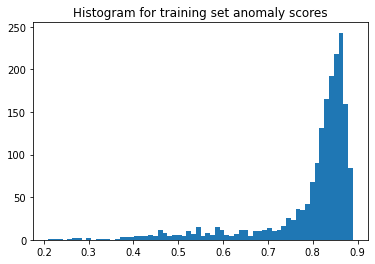

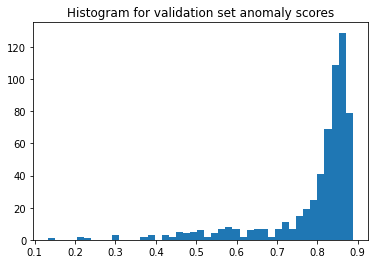

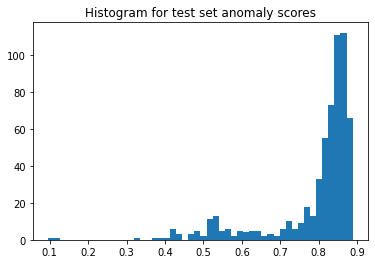

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1 of 300

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:
Epoch 2 of 300

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:
Epoch 3 of 300

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:
Epoch 4 of 300

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 index 3:
Epoch 5 of 300

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:

Testing for epoch 5 index 3:
Epoch 6 of 300

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:

Testing for epoch 6 index 3:
Epoch 7 of 300

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:

Testing for epoch 7 index 3:
Epoch 8 of 300

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:

Testing for epoch 8 index 3:
Epoch 9 of 300

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:

Testing for epoch 9 index 3:
Epoch 10 of 300

Testing for epoch 10 index 1:

Testing


Testing for epoch 76 index 3:
Epoch 77 of 300

Testing for epoch 77 index 1:

Testing for epoch 77 index 2:

Testing for epoch 77 index 3:
Epoch 78 of 300

Testing for epoch 78 index 1:

Testing for epoch 78 index 2:

Testing for epoch 78 index 3:
Epoch 79 of 300

Testing for epoch 79 index 1:

Testing for epoch 79 index 2:

Testing for epoch 79 index 3:
Epoch 80 of 300

Testing for epoch 80 index 1:

Testing for epoch 80 index 2:

Testing for epoch 80 index 3:
Epoch 81 of 300

Testing for epoch 81 index 1:

Testing for epoch 81 index 2:

Testing for epoch 81 index 3:
Epoch 82 of 300

Testing for epoch 82 index 1:

Testing for epoch 82 index 2:

Testing for epoch 82 index 3:
Epoch 83 of 300

Testing for epoch 83 index 1:

Testing for epoch 83 index 2:

Testing for epoch 83 index 3:
Epoch 84 of 300

Testing for epoch 84 index 1:

Testing for epoch 84 index 2:

Testing for epoch 84 index 3:
Epoch 85 of 300

Testing for epoch 85 index 1:

Testing for epoch 85 index 2:

Testing for epoch 

16/16 [==============================] - 0s 1ms/step - loss: 0.7869
Epoch 105 of 300

Testing for epoch 105 index 1:
16/16 [==============================] - ETA: 0s - loss: 0.804 - 0s 1ms/step - loss: 0.7716

Testing for epoch 105 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7794

Testing for epoch 105 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7856
Epoch 106 of 300

Testing for epoch 106 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7880

Testing for epoch 106 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.7834

Testing for epoch 106 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 0.7821
Epoch 107 of 300

Testing for epoch 107 index 1:
16/16 [==============================] - 0s 865us/step - loss: 0.7819

Testing for epoch 107 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7912

Testing for epoch 107 index 3:
16/16 [===========

16/16 [==============================] - 0s 932us/step - loss: 0.7915

Testing for epoch 109 index 2:
16/16 [==============================] - 0s 931us/step - loss: 0.7878

Testing for epoch 109 index 3:
16/16 [==============================] - 0s 941us/step - loss: 0.7973
Epoch 110 of 300

Testing for epoch 110 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7920

Testing for epoch 110 index 2:
16/16 [==============================] - 0s 934us/step - loss: 0.7841

Testing for epoch 110 index 3:
16/16 [==============================] - 0s 867us/step - loss: 0.7827
Epoch 111 of 300

Testing for epoch 111 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8045

Testing for epoch 111 index 2:
16/16 [==============================] - 0s 927us/step - loss: 0.7947

Testing for epoch 111 index 3:
16/16 [==============================] - 0s 932us/step - loss: 0.7988
Epoch 112 of 300

Testing for epoch 112 index 1:
16/16 [============================

16/16 [==============================] - 0s 933us/step - loss: 0.7994

Testing for epoch 113 index 2:
16/16 [==============================] - 0s 996us/step - loss: 0.7988

Testing for epoch 113 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7949
Epoch 114 of 300

Testing for epoch 114 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7940

Testing for epoch 114 index 2:
16/16 [==============================] - 0s 988us/step - loss: 0.8105

Testing for epoch 114 index 3:
16/16 [==============================] - 0s 933us/step - loss: 0.8118
Epoch 115 of 300

Testing for epoch 115 index 1:
16/16 [==============================] - 0s 999us/step - loss: 0.8007

Testing for epoch 115 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.8034

Testing for epoch 115 index 3:
16/16 [==============================] - 0s 866us/step - loss: 0.8105
Epoch 116 of 300

Testing for epoch 116 index 1:
16/16 [============================

16/16 [==============================] - 0s 1ms/step - loss: 0.8006

Testing for epoch 117 index 3:
16/16 [==============================] - 0s 934us/step - loss: 0.8079
Epoch 118 of 300

Testing for epoch 118 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 0.8047

Testing for epoch 118 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8237

Testing for epoch 118 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8162
Epoch 119 of 300

Testing for epoch 119 index 1:
16/16 [==============================] - 0s 949us/step - loss: 0.8154

Testing for epoch 119 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8334

Testing for epoch 119 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8258
Epoch 120 of 300

Testing for epoch 120 index 1:
16/16 [==============================] - 0s 946us/step - loss: 0.8107

Testing for epoch 120 index 2:
16/16 [==============================] -

16/16 [==============================] - 0s 933us/step - loss: 0.8286
Epoch 122 of 300

Testing for epoch 122 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8243

Testing for epoch 122 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8167

Testing for epoch 122 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8258
Epoch 123 of 300

Testing for epoch 123 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8390

Testing for epoch 123 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8213

Testing for epoch 123 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8186
Epoch 124 of 300

Testing for epoch 124 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8394

Testing for epoch 124 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 0.8420

Testing for epoch 124 index 3:
16/16 [==============================] - 0s 

16/16 [==============================] - 0s 933us/step - loss: 0.8449

Testing for epoch 126 index 2:
16/16 [==============================] - 0s 934us/step - loss: 0.8320

Testing for epoch 126 index 3:
16/16 [==============================] - 0s 935us/step - loss: 0.8329
Epoch 127 of 300

Testing for epoch 127 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8374

Testing for epoch 127 index 2:
16/16 [==============================] - ETA: 0s - loss: 0.824 - 0s 1ms/step - loss: 0.8615

Testing for epoch 127 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8309
Epoch 128 of 300

Testing for epoch 128 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8393

Testing for epoch 128 index 2:
16/16 [==============================] - 0s 934us/step - loss: 0.8463

Testing for epoch 128 index 3:
16/16 [==============================] - 0s 933us/step - loss: 0.8436
Epoch 129 of 300

Testing for epoch 129 index 1:
16/16 [========

16/16 [==============================] - 0s 1ms/step - loss: 0.8619

Testing for epoch 130 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.8722

Testing for epoch 130 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8456
Epoch 131 of 300

Testing for epoch 131 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8565

Testing for epoch 131 index 2:
16/16 [==============================] - 0s 934us/step - loss: 0.8550

Testing for epoch 131 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8615
Epoch 132 of 300

Testing for epoch 132 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8720

Testing for epoch 132 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8762

Testing for epoch 132 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8638
Epoch 133 of 300

Testing for epoch 133 index 1:
16/16 [==============================] - 0s 9

16/16 [==============================] - 0s 935us/step - loss: 0.8645

Testing for epoch 134 index 3:
16/16 [==============================] - 0s 933us/step - loss: 0.8673
Epoch 135 of 300

Testing for epoch 135 index 1:
16/16 [==============================] - 0s 931us/step - loss: 0.8667

Testing for epoch 135 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8723

Testing for epoch 135 index 3:
16/16 [==============================] - 0s 931us/step - loss: 0.8671
Epoch 136 of 300

Testing for epoch 136 index 1:
16/16 [==============================] - 0s 900us/step - loss: 0.8887

Testing for epoch 136 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8805

Testing for epoch 136 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8751
Epoch 137 of 300

Testing for epoch 137 index 1:
16/16 [==============================] - 0s 934us/step - loss: 0.8829

Testing for epoch 137 index 2:
16/16 [==============================

16/16 [==============================] - 0s 934us/step - loss: 0.8851
Epoch 139 of 300

Testing for epoch 139 index 1:
16/16 [==============================] - 0s 986us/step - loss: 0.8994

Testing for epoch 139 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 0.8910

Testing for epoch 139 index 3:
16/16 [==============================] - 0s 952us/step - loss: 0.8860
Epoch 140 of 300

Testing for epoch 140 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.8936

Testing for epoch 140 index 2:
16/16 [==============================] - 0s 867us/step - loss: 0.8955

Testing for epoch 140 index 3:
16/16 [==============================] - 0s 967us/step - loss: 0.8823
Epoch 141 of 300

Testing for epoch 141 index 1:
16/16 [==============================] - 0s 875us/step - loss: 0.9009

Testing for epoch 141 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.8977

Testing for epoch 141 index 3:
16/16 [=======================

16/16 [==============================] - 0s 867us/step - loss: 0.9065
Epoch 143 of 300

Testing for epoch 143 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.9222

Testing for epoch 143 index 2:
16/16 [==============================] - 0s 936us/step - loss: 0.9094

Testing for epoch 143 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8965
Epoch 144 of 300

Testing for epoch 144 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9098

Testing for epoch 144 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9159

Testing for epoch 144 index 3:
16/16 [==============================] - 0s 866us/step - loss: 0.8996
Epoch 145 of 300

Testing for epoch 145 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8974

Testing for epoch 145 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9059

Testing for epoch 145 index 3:
16/16 [==============================] - 

16/16 [==============================] - 0s 999us/step - loss: 0.8973

Testing for epoch 147 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9276

Testing for epoch 147 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9188
Epoch 148 of 300

Testing for epoch 148 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9453

Testing for epoch 148 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9383

Testing for epoch 148 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9087
Epoch 149 of 300

Testing for epoch 149 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9318

Testing for epoch 149 index 2:


16/16 [==============================] - 0s 2ms/step - loss: 0.9437

Testing for epoch 149 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9350
Epoch 150 of 300

Testing for epoch 150 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9366

Testing for epoch 150 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9274

Testing for epoch 150 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9222
Epoch 151 of 300

Testing for epoch 151 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9345

Testing for epoch 151 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 0.9218

Testing for epoch 151 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9389
Epoch 152 of 300

Testing for epoch 152 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9288

Testing for epoch 152 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 1ms/step - loss: 0.9735

Testing for epoch 153 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9546
Epoch 154 of 300

Testing for epoch 154 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9623

Testing for epoch 154 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9769

Testing for epoch 154 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9399
Epoch 155 of 300

Testing for epoch 155 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9474

Testing for epoch 155 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9590

Testing for epoch 155 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9523
Epoch 156 of 300

Testing for epoch 156 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9756

Testing for epoch 156 index 2:
16/16 [==============================] - 0s 1ms/s

16/16 [==============================] - 0s 1ms/step - loss: 0.9450
Epoch 158 of 300

Testing for epoch 158 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9669

Testing for epoch 158 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9667

Testing for epoch 158 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9667
Epoch 159 of 300

Testing for epoch 159 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9691

Testing for epoch 159 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9833

Testing for epoch 159 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9792
Epoch 160 of 300

Testing for epoch 160 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9783

Testing for epoch 160 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9981

Testing for epoch 160 index 3:
16/16 [==============================] - 0s 1ms/s

16/16 [==============================] - 0s 1ms/step - loss: 0.9731

Testing for epoch 162 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.0124

Testing for epoch 162 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9879
Epoch 163 of 300

Testing for epoch 163 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9943

Testing for epoch 163 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.0006

Testing for epoch 163 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0004
Epoch 164 of 300

Testing for epoch 164 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9831

Testing for epoch 164 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9970

Testing for epoch 164 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9927
Epoch 165 of 300

Testing for epoch 165 index 1:
16/16 [==============================] - 0s 1ms/s

16/16 [==============================] - 0s 1ms/step - loss: 0.9858

Testing for epoch 166 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0175
Epoch 167 of 300

Testing for epoch 167 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.0147

Testing for epoch 167 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.0458

Testing for epoch 167 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0093
Epoch 168 of 300

Testing for epoch 168 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.0010

Testing for epoch 168 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.0106

Testing for epoch 168 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0212
Epoch 169 of 300

Testing for epoch 169 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.0158

Testing for epoch 169 index 2:
16/16 [==============================] - 0s 1ms/s

16/16 [==============================] - 0s 1ms/step - loss: 1.0370
Epoch 171 of 300

Testing for epoch 171 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.0508

Testing for epoch 171 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.0427

Testing for epoch 171 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9924
Epoch 172 of 300

Testing for epoch 172 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.0443

Testing for epoch 172 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0327

Testing for epoch 172 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0500
Epoch 173 of 300

Testing for epoch 173 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0513

Testing for epoch 173 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.0555

Testing for epoch 173 index 3:
16/16 [==============================] - 0s 1ms/s

16/16 [==============================] - 0s 1ms/step - loss: 1.0729

Testing for epoch 175 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.0539

Testing for epoch 175 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0530
Epoch 176 of 300

Testing for epoch 176 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.0599

Testing for epoch 176 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.0452

Testing for epoch 176 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0669
Epoch 177 of 300

Testing for epoch 177 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.0595

Testing for epoch 177 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.0643

Testing for epoch 177 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.0275
Epoch 178 of 300

Testing for epoch 178 index 1:
16/16 [==============================] - 0s 935

16/16 [==============================] - 0s 1ms/step - loss: 1.0589

Testing for epoch 179 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.1035
Epoch 180 of 300

Testing for epoch 180 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.1103

Testing for epoch 180 index 2:
16/16 [==============================] - 0s 913us/step - loss: 1.0799

Testing for epoch 180 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0973
Epoch 181 of 300

Testing for epoch 181 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.0929

Testing for epoch 181 index 2:
16/16 [==============================] - 0s 982us/step - loss: 1.1103

Testing for epoch 181 index 3:
16/16 [==============================] - 0s 934us/step - loss: 1.1081
Epoch 182 of 300

Testing for epoch 182 index 1:
16/16 [==============================] - 0s 934us/step - loss: 1.0871

Testing for epoch 182 index 2:
16/16 [==============================] - 

16/16 [==============================] - 0s 1ms/step - loss: 1.1290
Epoch 184 of 300

Testing for epoch 184 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 1.1101

Testing for epoch 184 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 1.0893

Testing for epoch 184 index 3:
16/16 [==============================] - 0s 956us/step - loss: 1.1190
Epoch 185 of 300

Testing for epoch 185 index 1:
16/16 [==============================] - 0s 928us/step - loss: 1.1101

Testing for epoch 185 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.1275

Testing for epoch 185 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.1028
Epoch 186 of 300

Testing for epoch 186 index 1:
16/16 [==============================] - 0s 943us/step - loss: 1.1131

Testing for epoch 186 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.1345

Testing for epoch 186 index 3:
16/16 [==============================

16/16 [==============================] - 0s 1ms/step - loss: 1.1377
Epoch 188 of 300

Testing for epoch 188 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.1306

Testing for epoch 188 index 2:
16/16 [==============================] - 0s 868us/step - loss: 1.1198

Testing for epoch 188 index 3:
16/16 [==============================] - 0s 935us/step - loss: 1.1285
Epoch 189 of 300

Testing for epoch 189 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.1680

Testing for epoch 189 index 2:
16/16 [==============================] - 0s 966us/step - loss: 1.1428

Testing for epoch 189 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.1525


16/16 [==============================] - ETA: 0s - loss: 1.291 - 0s 900us/step - loss: 1.1612
Epoch 190 of 300

Testing for epoch 190 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.1562

Testing for epoch 190 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.1826

Testing for epoch 190 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.1523
Epoch 191 of 300

Testing for epoch 191 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.1343

Testing for epoch 191 index 2:
16/16 [==============================] - 0s 884us/step - loss: 1.1416

Testing for epoch 191 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.1398
Epoch 192 of 300

Testing for epoch 192 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.1657

Testing for epoch 192 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.1594

Testing for epoch 192 index 3:
16/16 [==========

16/16 [==============================] - 0s 1ms/step - loss: 1.1290

Testing for epoch 194 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.1967

Testing for epoch 194 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.1632
Epoch 195 of 300

Testing for epoch 195 index 1:
16/16 [==============================] - ETA: 0s - loss: 0.991 - 0s 1000us/step - loss: 1.1577

Testing for epoch 195 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 1.2207

Testing for epoch 195 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.1493
Epoch 196 of 300

Testing for epoch 196 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.1529


16/16 [==============================] - 0s 1ms/step - loss: 1.1750

Testing for epoch 196 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.1670

Testing for epoch 196 index 3:
16/16 [==============================] - 0s 935us/step - loss: 1.1947
Epoch 197 of 300

Testing for epoch 197 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.1414

Testing for epoch 197 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.2264

Testing for epoch 197 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.1857
Epoch 198 of 300

Testing for epoch 198 index 1:
16/16 [==============================] - 0s 965us/step - loss: 1.1873

Testing for epoch 198 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.1683

Testing for epoch 198 index 3:
16/16 [==============================] - 0s 971us/step - loss: 1.1591
Epoch 199 of 300

Testing for epoch 199 index 1:
16/16 [==============================] - 0s

16/16 [==============================] - 0s 1ms/step - loss: 1.1526

Testing for epoch 200 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.1605
Epoch 201 of 300

Testing for epoch 201 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.2034

Testing for epoch 201 index 2:
16/16 [==============================] - 0s 927us/step - loss: 1.2011

Testing for epoch 201 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.1746
Epoch 202 of 300

Testing for epoch 202 index 1:
16/16 [==============================] - 0s 934us/step - loss: 1.2005

Testing for epoch 202 index 2:
16/16 [==============================] - 0s 936us/step - loss: 1.2472

Testing for epoch 202 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.2262
Epoch 203 of 300

Testing for epoch 203 index 1:
16/16 [==============================] - 0s 962us/step - loss: 1.2101

Testing for epoch 203 index 2:
16/16 [==============================] 

16/16 [==============================] - 0s 1ms/step - loss: 1.2520
Epoch 205 of 300

Testing for epoch 205 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.2224

Testing for epoch 205 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.2682

Testing for epoch 205 index 3:
16/16 [==============================] - 0s 964us/step - loss: 1.2413
Epoch 206 of 300

Testing for epoch 206 index 1:
16/16 [==============================] - ETA: 0s - loss: 1.061 - 0s 1ms/step - loss: 1.2585

Testing for epoch 206 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.2273

Testing for epoch 206 index 3:
16/16 [==============================] - 0s 963us/step - loss: 1.2229
Epoch 207 of 300

Testing for epoch 207 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.2548

Testing for epoch 207 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.2684

Testing for epoch 207 index 3:
16/16 [==============

16/16 [==============================] - 0s 1ms/step - loss: 1.2638
Epoch 209 of 300

Testing for epoch 209 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.2565

Testing for epoch 209 index 2:
16/16 [==============================] - 0s 934us/step - loss: 1.2766

Testing for epoch 209 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.2262
Epoch 210 of 300

Testing for epoch 210 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.2631

Testing for epoch 210 index 2:
16/16 [==============================] - 0s 948us/step - loss: 1.2566

Testing for epoch 210 index 3:
16/16 [==============================] - 0s 971us/step - loss: 1.2371
Epoch 211 of 300

Testing for epoch 211 index 1:
16/16 [==============================] - 0s 999us/step - loss: 1.2289

Testing for epoch 211 index 2:
16/16 [==============================] - 0s 935us/step - loss: 1.2811

Testing for epoch 211 index 3:
16/16 [==============================

16/16 [==============================] - 0s 1ms/step - loss: 1.2524

Testing for epoch 213 index 2:
16/16 [==============================] - 0s 970us/step - loss: 1.2466

Testing for epoch 213 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.2359
Epoch 214 of 300

Testing for epoch 214 index 1:
16/16 [==============================] - 0s 999us/step - loss: 1.2736

Testing for epoch 214 index 2:
16/16 [==============================] - 0s 929us/step - loss: 1.2656

Testing for epoch 214 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.2801
Epoch 215 of 300

Testing for epoch 215 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.2573

Testing for epoch 215 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3166

Testing for epoch 215 index 3:
16/16 [==============================] - 0s 934us/step - loss: 1.3622
Epoch 216 of 300

Testing for epoch 216 index 1:
16/16 [==============================] 

16/16 [==============================] - 0s 933us/step - loss: 1.3165

Testing for epoch 217 index 3:
16/16 [==============================] - 0s 867us/step - loss: 1.3053
Epoch 218 of 300

Testing for epoch 218 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.3272

Testing for epoch 218 index 2:
16/16 [==============================] - 0s 868us/step - loss: 1.3165

Testing for epoch 218 index 3:
16/16 [==============================] - 0s 800us/step - loss: 1.3152
Epoch 219 of 300

Testing for epoch 219 index 1:
16/16 [==============================] - 0s 934us/step - loss: 1.2576

Testing for epoch 219 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.2197


16/16 [==============================] - 0s 1ms/step - loss: 1.2828

Testing for epoch 219 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3607
Epoch 220 of 300

Testing for epoch 220 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.2969

Testing for epoch 220 index 2:
16/16 [==============================] - 0s 974us/step - loss: 1.2899

Testing for epoch 220 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3152
Epoch 221 of 300

Testing for epoch 221 index 1:
16/16 [==============================] - 0s 926us/step - loss: 1.2822

Testing for epoch 221 index 2:
16/16 [==============================] - 0s 934us/step - loss: 1.3491

Testing for epoch 221 index 3:


16/16 [==============================] - 0s 1ms/step - loss: 1.2915
Epoch 222 of 300

Testing for epoch 222 index 1:
16/16 [==============================] - 0s 930us/step - loss: 1.3655

Testing for epoch 222 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3299

Testing for epoch 222 index 3:
16/16 [==============================] - 0s 906us/step - loss: 1.3058
Epoch 223 of 300

Testing for epoch 223 index 1:
16/16 [==============================] - 0s 999us/step - loss: 1.3073

Testing for epoch 223 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3316

Testing for epoch 223 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.3280
Epoch 224 of 300

Testing for epoch 224 index 1:
16/16 [==============================] - 0s 960us/step - loss: 1.3305

Testing for epoch 224 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.2921

Testing for epoch 224 index 3:
16/16 [==============================]

16/16 [==============================] - 0s 1ms/step - loss: 1.3383
Epoch 226 of 300

Testing for epoch 226 index 1:
16/16 [==============================] - 0s 934us/step - loss: 1.3675

Testing for epoch 226 index 2:
16/16 [==============================] - 0s 979us/step - loss: 1.3981

Testing for epoch 226 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.3200
Epoch 227 of 300

Testing for epoch 227 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.3999

Testing for epoch 227 index 2:
16/16 [==============================] - 0s 934us/step - loss: 1.3397

Testing for epoch 227 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3141
Epoch 228 of 300

Testing for epoch 228 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.3554

Testing for epoch 228 index 2:
16/16 [==============================] - 0s 932us/step - loss: 1.3855

Testing for epoch 228 index 3:
16/16 [=============================

16/16 [==============================] - 0s 1ms/step - loss: 1.3913

Testing for epoch 230 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3844

Testing for epoch 230 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3730
Epoch 231 of 300

Testing for epoch 231 index 1:
16/16 [==============================] - 0s 975us/step - loss: 1.3572

Testing for epoch 231 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3808

Testing for epoch 231 index 3:
16/16 [==============================] - 0s 935us/step - loss: 1.3613
Epoch 232 of 300

Testing for epoch 232 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.4112

Testing for epoch 232 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3738

Testing for epoch 232 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3814
Epoch 233 of 300

Testing for epoch 233 index 1:
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 800us/step - loss: 1.4117

Testing for epoch 234 index 3:
16/16 [==============================] - 0s 902us/step - loss: 1.3899
Epoch 235 of 300

Testing for epoch 235 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.4809

Testing for epoch 235 index 2:
16/16 [==============================] - 0s 934us/step - loss: 1.3850

Testing for epoch 235 index 3:
16/16 [==============================] - 0s 866us/step - loss: 1.4181
Epoch 236 of 300

Testing for epoch 236 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.4195

Testing for epoch 236 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.3389


16/16 [==============================] - 0s 1ms/step - loss: 1.4133

Testing for epoch 236 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.4106
Epoch 237 of 300

Testing for epoch 237 index 1:
16/16 [==============================] - 0s 998us/step - loss: 1.4673

Testing for epoch 237 index 2:
16/16 [==============================] - 0s 867us/step - loss: 1.4053

Testing for epoch 237 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.4319
Epoch 238 of 300

Testing for epoch 238 index 1:
16/16 [==============================] - 0s 866us/step - loss: 1.3972

Testing for epoch 238 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.4209

Testing for epoch 238 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3884
Epoch 239 of 300

Testing for epoch 239 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.3819

Testing for epoch 239 index 2:
16/16 [==============================] - 0s

16/16 [==============================] - 0s 933us/step - loss: 1.4312
Epoch 241 of 300

Testing for epoch 241 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.4236

Testing for epoch 241 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 1.4310

Testing for epoch 241 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.4318
Epoch 242 of 300

Testing for epoch 242 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.4255

Testing for epoch 242 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.4240

Testing for epoch 242 index 3:
16/16 [==============================] - 0s 934us/step - loss: 1.5152
Epoch 243 of 300

Testing for epoch 243 index 1:
16/16 [==============================] - 0s 866us/step - loss: 1.4265

Testing for epoch 243 index 2:
16/16 [==============================] - 0s 967us/step - loss: 1.4705

Testing for epoch 243 index 3:
16/16 [============================

16/16 [==============================] - 0s 1ms/step - loss: 1.4472

Testing for epoch 245 index 2:
16/16 [==============================] - 0s 980us/step - loss: 1.4816

Testing for epoch 245 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.4720
Epoch 246 of 300

Testing for epoch 246 index 1:
16/16 [==============================] - ETA: 0s - loss: 1.504 - 0s 999us/step - loss: 1.5114

Testing for epoch 246 index 2:
16/16 [==============================] - 0s 944us/step - loss: 1.4807

Testing for epoch 246 index 3:
16/16 [==============================] - 0s 960us/step - loss: 1.4531
Epoch 247 of 300

Testing for epoch 247 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.5013

Testing for epoch 247 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 1.4611

Testing for epoch 247 index 3:
16/16 [==============================] - 0s 918us/step - loss: 1.4709
Epoch 248 of 300

Testing for epoch 248 index 1:
16/16 [=====

16/16 [==============================] - 0s 1ms/step - loss: 1.4875

Testing for epoch 249 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.5266

Testing for epoch 249 index 3:
16/16 [==============================] - 0s 934us/step - loss: 1.4977
Epoch 250 of 300

Testing for epoch 250 index 1:
16/16 [==============================] - 0s 978us/step - loss: 1.4384

Testing for epoch 250 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5606

Testing for epoch 250 index 3:
16/16 [==============================] - 0s 931us/step - loss: 1.4664
Epoch 251 of 300

Testing for epoch 251 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.4909

Testing for epoch 251 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5203

Testing for epoch 251 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.5389
Epoch 252 of 300

Testing for epoch 252 index 1:
16/16 [==============================] - 

16/16 [==============================] - 0s 935us/step - loss: 1.5381

Testing for epoch 253 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.4583
Epoch 254 of 300

Testing for epoch 254 index 1:
16/16 [==============================] - 0s 867us/step - loss: 1.5130

Testing for epoch 254 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.4507

Testing for epoch 254 index 3:
16/16 [==============================] - 0s 999us/step - loss: 1.5228
Epoch 255 of 300

Testing for epoch 255 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.5641

Testing for epoch 255 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5616

Testing for epoch 255 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.4971
Epoch 256 of 300

Testing for epoch 256 index 1:
16/16 [==============================] - 0s 999us/step - loss: 1.5004

Testing for epoch 256 index 2:
16/16 [==============================] 

16/16 [==============================] - 0s 872us/step - loss: 1.5364
Epoch 258 of 300

Testing for epoch 258 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 1.5430

Testing for epoch 258 index 2:
16/16 [==============================] - 0s 827us/step - loss: 1.5763

Testing for epoch 258 index 3:
16/16 [==============================] - 0s 929us/step - loss: 1.5487
Epoch 259 of 300

Testing for epoch 259 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.5848

Testing for epoch 259 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5275

Testing for epoch 259 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3804


16/16 [==============================] - 0s 1ms/step - loss: 1.5183
Epoch 260 of 300

Testing for epoch 260 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.5308

Testing for epoch 260 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5629

Testing for epoch 260 index 3:
16/16 [==============================] - 0s 871us/step - loss: 1.5349
Epoch 261 of 300

Testing for epoch 261 index 1:
16/16 [==============================] - 0s 934us/step - loss: 1.5552

Testing for epoch 261 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.5567

Testing for epoch 261 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.5634
Epoch 262 of 300

Testing for epoch 262 index 1:
16/16 [==============================] - 0s 867us/step - loss: 1.5756

Testing for epoch 262 index 2:
16/16 [==============================] - 0s 999us/step - loss: 1.5741

Testing for epoch 262 index 3:
16/16 [============================

16/16 [==============================] - 0s 968us/step - loss: 1.5717

Testing for epoch 264 index 2:
16/16 [==============================] - 0s 867us/step - loss: 1.5534

Testing for epoch 264 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.5120
Epoch 265 of 300

Testing for epoch 265 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 1.5331

Testing for epoch 265 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5982

Testing for epoch 265 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.7053
Epoch 266 of 300

Testing for epoch 266 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.6299

Testing for epoch 266 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.6017

Testing for epoch 266 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.5925
Epoch 267 of 300

Testing for epoch 267 index 1:
16/16 [==============================]

16/16 [==============================] - 0s 1000us/step - loss: 1.5821

Testing for epoch 268 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.6160

Testing for epoch 268 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.5707
Epoch 269 of 300

Testing for epoch 269 index 1:
16/16 [==============================] - 0s 946us/step - loss: 1.6045

Testing for epoch 269 index 2:
16/16 [==============================] - 0s 910us/step - loss: 1.5640

Testing for epoch 269 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.6535
Epoch 270 of 300

Testing for epoch 270 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 1.5270

Testing for epoch 270 index 2:
16/16 [==============================] - 0s 868us/step - loss: 1.5889

Testing for epoch 270 index 3:
16/16 [==============================] - 0s 935us/step - loss: 1.6577
Epoch 271 of 300

Testing for epoch 271 index 1:
16/16 [============================

16/16 [==============================] - 0s 800us/step - loss: 1.7008

Testing for epoch 272 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.6534
Epoch 273 of 300

Testing for epoch 273 index 1:
16/16 [==============================] - 0s 800us/step - loss: 1.6309

Testing for epoch 273 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.6959

Testing for epoch 273 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.7041
Epoch 274 of 300

Testing for epoch 274 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.5909

Testing for epoch 274 index 2:
16/16 [==============================] - 0s 867us/step - loss: 1.7024

Testing for epoch 274 index 3:
16/16 [==============================] - 0s 870us/step - loss: 1.6896
Epoch 275 of 300

Testing for epoch 275 index 1:
16/16 [==============================] - 0s 934us/step - loss: 1.5813

Testing for epoch 275 index 2:
16/16 [==============================

16/16 [==============================] - 0s 1ms/step - loss: 1.6518
Epoch 277 of 300

Testing for epoch 277 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.6937

Testing for epoch 277 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.6594

Testing for epoch 277 index 3:
16/16 [==============================] - 0s 850us/step - loss: 1.6941
Epoch 278 of 300

Testing for epoch 278 index 1:
16/16 [==============================] - 0s 932us/step - loss: 1.6233

Testing for epoch 278 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.6459

Testing for epoch 278 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.6315


16/16 [==============================] - 0s 958us/step - loss: 1.7330
Epoch 279 of 300

Testing for epoch 279 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.6727

Testing for epoch 279 index 2:
16/16 [==============================] - 0s 983us/step - loss: 1.7130

Testing for epoch 279 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.6885
Epoch 280 of 300

Testing for epoch 280 index 1:
16/16 [==============================] - 0s 865us/step - loss: 1.7251

Testing for epoch 280 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 1.6741

Testing for epoch 280 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.6691
Epoch 281 of 300

Testing for epoch 281 index 1:
16/16 [==============================] - 0s 936us/step - loss: 1.7126

Testing for epoch 281 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.6771

Testing for epoch 281 index 3:
16/16 [=======================

16/16 [==============================] - 0s 1ms/step - loss: 1.7350

Testing for epoch 283 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.7016

Testing for epoch 283 index 3:
16/16 [==============================] - 0s 916us/step - loss: 1.6906
Epoch 284 of 300

Testing for epoch 284 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.7555

Testing for epoch 284 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.8549

Testing for epoch 284 index 3:
16/16 [==============================] - 0s 942us/step - loss: 1.7776
Epoch 285 of 300

Testing for epoch 285 index 1:
16/16 [==============================] - 0s 934us/step - loss: 1.6624


16/16 [==============================] - 0s 1000us/step - loss: 1.7705

Testing for epoch 285 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.7467

Testing for epoch 285 index 3:
16/16 [==============================] - 0s 999us/step - loss: 1.5824
Epoch 286 of 300

Testing for epoch 286 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.6614

Testing for epoch 286 index 2:
16/16 [==============================] - 0s 982us/step - loss: 1.6930

Testing for epoch 286 index 3:
16/16 [==============================] - 0s 955us/step - loss: 1.7116
Epoch 287 of 300

Testing for epoch 287 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.7666

Testing for epoch 287 index 2:
16/16 [==============================] - 0s 947us/step - loss: 1.7452

Testing for epoch 287 index 3:
16/16 [==============================] - 0s 961us/step - loss: 1.7162
Epoch 288 of 300

Testing for epoch 288 index 1:
16/16 [===========================

16/16 [==============================] - 0s 997us/step - loss: 1.7833

Testing for epoch 289 index 3:
16/16 [==============================] - 0s 947us/step - loss: 1.7018
Epoch 290 of 300

Testing for epoch 290 index 1:
16/16 [==============================] - 0s 872us/step - loss: 1.7610

Testing for epoch 290 index 2:
16/16 [==============================] - 0s 995us/step - loss: 1.6866

Testing for epoch 290 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.7982
Epoch 291 of 300

Testing for epoch 291 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 1.7106

Testing for epoch 291 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.7144

Testing for epoch 291 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.7526
Epoch 292 of 300

Testing for epoch 292 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.7666

Testing for epoch 292 index 2:
16/16 [==========================

16/16 [==============================] - 0s 1ms/step - loss: 1.7764

Testing for epoch 293 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.6357
Epoch 294 of 300

Testing for epoch 294 index 1:
16/16 [==============================] - 0s 999us/step - loss: 1.7541

Testing for epoch 294 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.8765

Testing for epoch 294 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.8805
Epoch 295 of 300

Testing for epoch 295 index 1:
16/16 [==============================] - 0s 868us/step - loss: 1.7906

Testing for epoch 295 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.8165

Testing for epoch 295 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.7566
Epoch 296 of 300

Testing for epoch 296 index 1:
16/16 [==============================] - 0s 873us/step - loss: 1.8356

Testing for epoch 296 index 2:
16/16 [==============================] - 0s

16/16 [==============================] - 0s 1ms/step - loss: 1.7937
Epoch 298 of 300

Testing for epoch 298 index 1:
16/16 [==============================] - 0s 800us/step - loss: 1.7878

Testing for epoch 298 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.7881

Testing for epoch 298 index 3:
16/16 [==============================] - 0s 932us/step - loss: 1.7690
Epoch 299 of 300

Testing for epoch 299 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.8572

Testing for epoch 299 index 2:
16/16 [==============================] - 0s 994us/step - loss: 1.7993

Testing for epoch 299 index 3:
16/16 [==============================] - 0s 868us/step - loss: 1.8951


Epoch 300 of 300

Testing for epoch 300 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.8141

Testing for epoch 300 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.8500

Testing for epoch 300 index 3:
16/16 [==============================] - 0s 966us/step - loss: 1.7753
k value 18


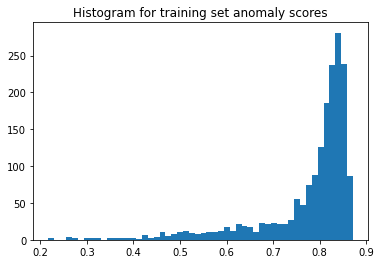

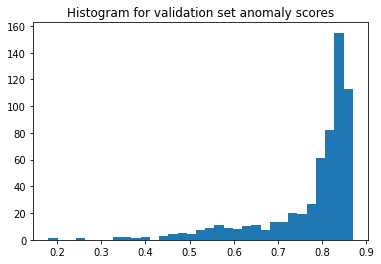

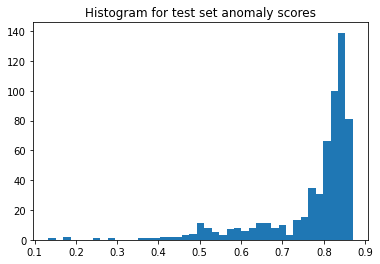

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1 of 300

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:
Epoch 2 of 300

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:
Epoch 3 of 300

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:
Epoch 4 of 300

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 index 3:
Epoch 5 of 300

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:

Testing for epoch 5 index 3:
Epoch 6 of 300

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:

Testing for epoch 6 index 3:
Epoch 7 of 300

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:

Testing for epoch 7 index 3:
Epoch 8 of 300

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:

Testing for epoch 8 index 3:
Epoch 9 of 300

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:

Testing for epoch 9 index 3:
Epoch 10 of 300

Testing for epoch 10 index 1:

Testing


Testing for epoch 76 index 3:
Epoch 77 of 300

Testing for epoch 77 index 1:

Testing for epoch 77 index 2:

Testing for epoch 77 index 3:
Epoch 78 of 300

Testing for epoch 78 index 1:

Testing for epoch 78 index 2:

Testing for epoch 78 index 3:
Epoch 79 of 300

Testing for epoch 79 index 1:

Testing for epoch 79 index 2:

Testing for epoch 79 index 3:
Epoch 80 of 300

Testing for epoch 80 index 1:

Testing for epoch 80 index 2:

Testing for epoch 80 index 3:
Epoch 81 of 300

Testing for epoch 81 index 1:

Testing for epoch 81 index 2:

Testing for epoch 81 index 3:
Epoch 82 of 300

Testing for epoch 82 index 1:

Testing for epoch 82 index 2:

Testing for epoch 82 index 3:
Epoch 83 of 300

Testing for epoch 83 index 1:

Testing for epoch 83 index 2:

Testing for epoch 83 index 3:
Epoch 84 of 300

Testing for epoch 84 index 1:

Testing for epoch 84 index 2:

Testing for epoch 84 index 3:
Epoch 85 of 300

Testing for epoch 85 index 1:

Testing for epoch 85 index 2:

Testing for epoch 

16/16 [==============================] - 0s 1ms/step - loss: 0.7932

Testing for epoch 104 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7859
Epoch 105 of 300

Testing for epoch 105 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7867

Testing for epoch 105 index 2:
16/16 [==============================] - 0s 995us/step - loss: 0.7853

Testing for epoch 105 index 3:
16/16 [==============================] - 0s 896us/step - loss: 0.7837
Epoch 106 of 300

Testing for epoch 106 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.7996

Testing for epoch 106 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.7885

Testing for epoch 106 index 3:
16/16 [==============================] - 0s 954us/step - loss: 0.7929
Epoch 107 of 300

Testing for epoch 107 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7970

Testing for epoch 107 index 2:
16/16 [==============================] 

16/16 [==============================] - 0s 933us/step - loss: 0.7954

Testing for epoch 108 index 2:
16/16 [==============================] - 0s 867us/step - loss: 0.7939

Testing for epoch 108 index 3:
16/16 [==============================] - 0s 935us/step - loss: 0.7940
Epoch 109 of 300

Testing for epoch 109 index 1:
16/16 [==============================] - 0s 867us/step - loss: 0.8057

Testing for epoch 109 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.7994

Testing for epoch 109 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8051
Epoch 110 of 300

Testing for epoch 110 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 0.8063

Testing for epoch 110 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8055

Testing for epoch 110 index 3:
16/16 [==============================] - 0s 964us/step - loss: 0.8002
Epoch 111 of 300

Testing for epoch 111 index 1:
16/16 [===========================

16/16 [==============================] - 0s 1ms/step - loss: 0.7975

Testing for epoch 112 index 2:
16/16 [==============================] - 0s 951us/step - loss: 0.8114

Testing for epoch 112 index 3:
16/16 [==============================] - ETA: 0s - loss: 0.823 - 0s 935us/step - loss: 0.8097
Epoch 113 of 300

Testing for epoch 113 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8102

Testing for epoch 113 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8106

Testing for epoch 113 index 3:
16/16 [==============================] - 0s 934us/step - loss: 0.8176
Epoch 114 of 300

Testing for epoch 114 index 1:
16/16 [==============================] - 0s 938us/step - loss: 0.8080

Testing for epoch 114 index 2:
16/16 [==============================] - ETA: 0s - loss: 0.853 - 0s 933us/step - loss: 0.8235

Testing for epoch 114 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8075
Epoch 115 of 300

Testing for epoch 115 

16/16 [==============================] - 0s 933us/step - loss: 0.8153
Epoch 116 of 300

Testing for epoch 116 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8304

Testing for epoch 116 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 0.8237

Testing for epoch 116 index 3:
16/16 [==============================] - 0s 934us/step - loss: 0.8119
Epoch 117 of 300

Testing for epoch 117 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8293

Testing for epoch 117 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.8124

Testing for epoch 117 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 0.8175
Epoch 118 of 300

Testing for epoch 118 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8279

Testing for epoch 118 index 2:
16/16 [==============================] - 0s 936us/step - loss: 0.8278

Testing for epoch 118 index 3:
16/16 [============================

16/16 [==============================] - 0s 900us/step - loss: 0.8276

Testing for epoch 119 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8331
Epoch 120 of 300

Testing for epoch 120 index 1:
16/16 [==============================] - 0s 876us/step - loss: 0.8381

Testing for epoch 120 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8434

Testing for epoch 120 index 3:
16/16 [==============================] - 0s 836us/step - loss: 0.8347
Epoch 121 of 300

Testing for epoch 121 index 1:
16/16 [==============================] - 0s 947us/step - loss: 0.8425

Testing for epoch 121 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.8331

Testing for epoch 121 index 3:
16/16 [==============================] - 0s 961us/step - loss: 0.8443
Epoch 122 of 300

Testing for epoch 122 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8394

Testing for epoch 122 index 2:
16/16 [==============================

16/16 [==============================] - 0s 1000us/step - loss: 0.8442

Testing for epoch 123 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.8458

Testing for epoch 123 index 3:
16/16 [==============================] - 0s 899us/step - loss: 0.8570
Epoch 124 of 300

Testing for epoch 124 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.8514

Testing for epoch 124 index 2:
16/16 [==============================] - 0s 935us/step - loss: 0.8521

Testing for epoch 124 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 0.8505
Epoch 125 of 300

Testing for epoch 125 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8505

Testing for epoch 125 index 2:
16/16 [==============================] - 0s 996us/step - loss: 0.8519

Testing for epoch 125 index 3:
16/16 [==============================] - 0s 935us/step - loss: 0.8623
Epoch 126 of 300

Testing for epoch 126 index 1:
16/16 [========================

16/16 [==============================] - 0s 1ms/step - loss: 0.8654

Testing for epoch 127 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 0.8505

Testing for epoch 127 index 3:
16/16 [==============================] - ETA: 0s - loss: 0.823 - 0s 1ms/step - loss: 0.8693
Epoch 128 of 300

Testing for epoch 128 index 1:
16/16 [==============================] - 0s 869us/step - loss: 0.8613

Testing for epoch 128 index 2:
16/16 [==============================] - 0s 896us/step - loss: 0.8691

Testing for epoch 128 index 3:
16/16 [==============================] - 0s 954us/step - loss: 0.8636
Epoch 129 of 300

Testing for epoch 129 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.8658

Testing for epoch 129 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8754

Testing for epoch 129 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8772
Epoch 130 of 300

Testing for epoch 130 index 1:
16/16 [=======

16/16 [==============================] - 0s 934us/step - loss: 0.8856
Epoch 131 of 300

Testing for epoch 131 index 1:
16/16 [==============================] - 0s 885us/step - loss: 0.8867

Testing for epoch 131 index 2:
16/16 [==============================] - ETA: 0s - loss: 0.857 - 0s 933us/step - loss: 0.8583

Testing for epoch 131 index 3:
16/16 [==============================] - 0s 902us/step - loss: 0.8840
Epoch 132 of 300

Testing for epoch 132 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8810

Testing for epoch 132 index 2:
16/16 [==============================] - 0s 999us/step - loss: 0.8850

Testing for epoch 132 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8789
Epoch 133 of 300

Testing for epoch 133 index 1:
16/16 [==============================] - 0s 853us/step - loss: 0.8945

Testing for epoch 133 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8963

Testing for epoch 133 index 3:
16/16 [======

16/16 [==============================] - ETA: 0s - loss: 0.885 - 0s 933us/step - loss: 0.9082

Testing for epoch 134 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8860
Epoch 135 of 300

Testing for epoch 135 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9136

Testing for epoch 135 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9190

Testing for epoch 135 index 3:
16/16 [==============================] - 0s 934us/step - loss: 0.9066
Epoch 136 of 300

Testing for epoch 136 index 1:
16/16 [==============================] - 0s 867us/step - loss: 0.9218

Testing for epoch 136 index 2:
16/16 [==============================] - ETA: 0s - loss: 0.939 - 0s 974us/step - loss: 0.9253

Testing for epoch 136 index 3:
16/16 [==============================] - 0s 926us/step - loss: 0.9074
Epoch 137 of 300

Testing for epoch 137 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9172

Testing for epoch 137 

16/16 [==============================] - 0s 933us/step - loss: 0.9015

Testing for epoch 138 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9404
Epoch 139 of 300

Testing for epoch 139 index 1:
16/16 [==============================] - 0s 891us/step - loss: 0.9285

Testing for epoch 139 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.9148

Testing for epoch 139 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9281
Epoch 140 of 300

Testing for epoch 140 index 1:
16/16 [==============================] - 0s 935us/step - loss: 0.9248

Testing for epoch 140 index 2:
16/16 [==============================] - 0s 954us/step - loss: 0.9403

Testing for epoch 140 index 3:
16/16 [==============================] - 0s 936us/step - loss: 0.9216
Epoch 141 of 300

Testing for epoch 141 index 1:
16/16 [==============================] - 0s 934us/step - loss: 0.9307

Testing for epoch 141 index 2:
16/16 [============================

16/16 [==============================] - 0s 1ms/step - loss: 0.9419

Testing for epoch 142 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9502

Testing for epoch 142 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9642
Epoch 143 of 300

Testing for epoch 143 index 1:
16/16 [==============================] - 0s 999us/step - loss: 0.9478

Testing for epoch 143 index 2:
16/16 [==============================] - 0s 936us/step - loss: 0.9451

Testing for epoch 143 index 3:
16/16 [==============================] - 0s 966us/step - loss: 0.9606
Epoch 144 of 300

Testing for epoch 144 index 1:
16/16 [==============================] - 0s 962us/step - loss: 0.8778


16/16 [==============================] - 0s 1ms/step - loss: 0.9390

Testing for epoch 144 index 2:
16/16 [==============================] - 0s 907us/step - loss: 0.9552

Testing for epoch 144 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9421
Epoch 145 of 300

Testing for epoch 145 index 1:
16/16 [==============================] - 0s 934us/step - loss: 0.9495

Testing for epoch 145 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9577

Testing for epoch 145 index 3:
16/16 [==============================] - ETA: 0s - loss: 0.914 - 0s 933us/step - loss: 0.9527
Epoch 146 of 300

Testing for epoch 146 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9640

Testing for epoch 146 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.9822

Testing for epoch 146 index 3:
16/16 [==============================] - 0s 908us/step - loss: 0.9760
Epoch 147 of 300

Testing for epoch 147 index 1:
16/16 [========

16/16 [==============================] - 0s 1ms/step - loss: 0.9836
Epoch 148 of 300

Testing for epoch 148 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9701

Testing for epoch 148 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.9751

Testing for epoch 148 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 0.9826
Epoch 149 of 300

Testing for epoch 149 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.9671

Testing for epoch 149 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 0.9874

Testing for epoch 149 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9600
Epoch 150 of 300

Testing for epoch 150 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9961

Testing for epoch 150 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9840

Testing for epoch 150 index 3:
16/16 [==============================] 

16/16 [==============================] - ETA: 0s - loss: 0.984 - 0s 934us/step - loss: 1.0029

Testing for epoch 151 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0003
Epoch 152 of 300

Testing for epoch 152 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9750

Testing for epoch 152 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.0073

Testing for epoch 152 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0147
Epoch 153 of 300

Testing for epoch 153 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.0239

Testing for epoch 153 index 2:
16/16 [==============================] - 0s 990us/step - loss: 1.0173

Testing for epoch 153 index 3:
16/16 [==============================] - 0s 949us/step - loss: 1.0036
Epoch 154 of 300

Testing for epoch 154 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.0388

Testing for epoch 154 index 2:
16/16 [============

16/16 [==============================] - 0s 1ms/step - loss: 1.0228

Testing for epoch 155 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0185
Epoch 156 of 300

Testing for epoch 156 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 1.0027

Testing for epoch 156 index 2:
16/16 [==============================] - 0s 975us/step - loss: 1.0166

Testing for epoch 156 index 3:
16/16 [==============================] - 0s 889us/step - loss: 1.0266
Epoch 157 of 300

Testing for epoch 157 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.0269

Testing for epoch 157 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.0161

Testing for epoch 157 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0269
Epoch 158 of 300

Testing for epoch 158 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.0575

Testing for epoch 158 index 2:
16/16 [==============================] -

16/16 [==============================] - 0s 933us/step - loss: 1.0147

Testing for epoch 159 index 2:
16/16 [==============================] - 0s 936us/step - loss: 1.0379

Testing for epoch 159 index 3:
16/16 [==============================] - 0s 999us/step - loss: 1.0451
Epoch 160 of 300

Testing for epoch 160 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.0505

Testing for epoch 160 index 2:
16/16 [==============================] - 0s 935us/step - loss: 1.0390

Testing for epoch 160 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0359
Epoch 161 of 300

Testing for epoch 161 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 1.0388

Testing for epoch 161 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 1.0327

Testing for epoch 161 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0396
Epoch 162 of 300

Testing for epoch 162 index 1:
16/16 [============================

16/16 [==============================] - 0s 865us/step - loss: 1.0714

Testing for epoch 163 index 2:
16/16 [==============================] - 0s 995us/step - loss: 1.0815

Testing for epoch 163 index 3:
16/16 [==============================] - 0s 913us/step - loss: 1.0770
Epoch 164 of 300

Testing for epoch 164 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.0652

Testing for epoch 164 index 2:
16/16 [==============================] - 0s 920us/step - loss: 1.0680

Testing for epoch 164 index 3:
16/16 [==============================] - 0s 956us/step - loss: 1.0933
Epoch 165 of 300

Testing for epoch 165 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.0330

Testing for epoch 165 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.0736

Testing for epoch 165 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0672
Epoch 166 of 300

Testing for epoch 166 index 1:
16/16 [============================

16/16 [==============================] - 0s 971us/step - loss: 1.1036
Epoch 167 of 300

Testing for epoch 167 index 1:
16/16 [==============================] - 0s 993us/step - loss: 1.0863

Testing for epoch 167 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.0937

Testing for epoch 167 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0924
Epoch 168 of 300

Testing for epoch 168 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.1093

Testing for epoch 168 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.1164

Testing for epoch 168 index 3:
16/16 [==============================] - 0s 982us/step - loss: 1.1140
Epoch 169 of 300

Testing for epoch 169 index 1:
16/16 [==============================] - 0s 865us/step - loss: 1.1059

Testing for epoch 169 index 2:
16/16 [==============================] - 0s 931us/step - loss: 1.0823

Testing for epoch 169 index 3:
16/16 [==============================] 

16/16 [==============================] - 0s 912us/step - loss: 1.1191
Epoch 171 of 300

Testing for epoch 171 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.1436

Testing for epoch 171 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.1237

Testing for epoch 171 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.1294
Epoch 172 of 300

Testing for epoch 172 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.1175

Testing for epoch 172 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.0926

Testing for epoch 172 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.1508
Epoch 173 of 300

Testing for epoch 173 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.1075

Testing for epoch 173 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.1336

Testing for epoch 173 index 3:
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 933us/step - loss: 1.1608

Testing for epoch 174 index 3:
16/16 [==============================] - 0s 934us/step - loss: 1.1819
Epoch 175 of 300

Testing for epoch 175 index 1:
16/16 [==============================] - 0s 966us/step - loss: 1.1579

Testing for epoch 175 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.1751

Testing for epoch 175 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.1647
Epoch 176 of 300

Testing for epoch 176 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.1795

Testing for epoch 176 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.1631

Testing for epoch 176 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.1406
Epoch 177 of 300

Testing for epoch 177 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.1449

Testing for epoch 177 index 2:
16/16 [==============================

16/16 [==============================] - 0s 1ms/step - loss: 1.1993

Testing for epoch 178 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.1770
Epoch 179 of 300

Testing for epoch 179 index 1:
16/16 [==============================] - 0s 926us/step - loss: 1.1905

Testing for epoch 179 index 2:
16/16 [==============================] - 0s 868us/step - loss: 1.2043

Testing for epoch 179 index 3:
16/16 [==============================] - 0s 932us/step - loss: 1.1629
Epoch 180 of 300

Testing for epoch 180 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.1903

Testing for epoch 180 index 2:
16/16 [==============================] - 0s 868us/step - loss: 1.2301

Testing for epoch 180 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.1628
Epoch 181 of 300

Testing for epoch 181 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.1769

Testing for epoch 181 index 2:
16/16 [==============================] - 

16/16 [==============================] - 0s 954us/step - loss: 1.1734

Testing for epoch 182 index 2:
16/16 [==============================] - 0s 934us/step - loss: 1.1983

Testing for epoch 182 index 3:
16/16 [==============================] - 0s 934us/step - loss: 1.1875
Epoch 183 of 300

Testing for epoch 183 index 1:
16/16 [==============================] - 0s 937us/step - loss: 1.1835

Testing for epoch 183 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.2103

Testing for epoch 183 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.2181
Epoch 184 of 300

Testing for epoch 184 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.2159

Testing for epoch 184 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.1767

Testing for epoch 184 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.2122
Epoch 185 of 300

Testing for epoch 185 index 1:
16/16 [=============================

16/16 [==============================] - 0s 1ms/step - loss: 1.2256
Epoch 186 of 300

Testing for epoch 186 index 1:
16/16 [==============================] - 0s 970us/step - loss: 1.2424

Testing for epoch 186 index 2:
16/16 [==============================] - 0s 912us/step - loss: 1.2614

Testing for epoch 186 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.2752
Epoch 187 of 300

Testing for epoch 187 index 1:
16/16 [==============================] - 0s 934us/step - loss: 1.2740

Testing for epoch 187 index 2:
16/16 [==============================] - 0s 935us/step - loss: 1.2386

Testing for epoch 187 index 3:
16/16 [==============================] - 0s 936us/step - loss: 1.1633


16/16 [==============================] - 0s 929us/step - loss: 1.2251
Epoch 188 of 300

Testing for epoch 188 index 1:
16/16 [==============================] - ETA: 0s - loss: 1.268 - 0s 934us/step - loss: 1.2442

Testing for epoch 188 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.2783

Testing for epoch 188 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.2665
Epoch 189 of 300

Testing for epoch 189 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.2505

Testing for epoch 189 index 2:
16/16 [==============================] - 0s 943us/step - loss: 1.2367

Testing for epoch 189 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.2323
Epoch 190 of 300

Testing for epoch 190 index 1:
16/16 [==============================] - 0s 970us/step - loss: 1.2484

Testing for epoch 190 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.2582

Testing for epoch 190 index 3:
16/16 [==========

16/16 [==============================] - 0s 1ms/step - loss: 1.2397

Testing for epoch 191 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.3076
Epoch 192 of 300

Testing for epoch 192 index 1:
16/16 [==============================] - 0s 893us/step - loss: 1.2672

Testing for epoch 192 index 2:
16/16 [==============================] - 0s 869us/step - loss: 1.2968

Testing for epoch 192 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.3036
Epoch 193 of 300

Testing for epoch 193 index 1:
16/16 [==============================] - 0s 922us/step - loss: 1.2985

Testing for epoch 193 index 2:
16/16 [==============================] - 0s 960us/step - loss: 1.2346


16/16 [==============================] - 0s 933us/step - loss: 1.2808

Testing for epoch 193 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.2730
Epoch 194 of 300

Testing for epoch 194 index 1:
16/16 [==============================] - 0s 971us/step - loss: 1.2985

Testing for epoch 194 index 2:
16/16 [==============================] - 0s 998us/step - loss: 1.2913

Testing for epoch 194 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.2564
Epoch 195 of 300

Testing for epoch 195 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.3115

Testing for epoch 195 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.2961

Testing for epoch 195 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3183
Epoch 196 of 300

Testing for epoch 196 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.3281

Testing for epoch 196 index 2:
16/16 [==============================]

16/16 [==============================] - 0s 1ms/step - loss: 1.3022

Testing for epoch 197 index 3:
16/16 [==============================] - 0s 975us/step - loss: 1.3128
Epoch 198 of 300

Testing for epoch 198 index 1:
16/16 [==============================] - 0s 934us/step - loss: 1.3236

Testing for epoch 198 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3270

Testing for epoch 198 index 3:
16/16 [==============================] - 0s 923us/step - loss: 1.3462
Epoch 199 of 300

Testing for epoch 199 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.3112


16/16 [==============================] - 0s 949us/step - loss: 1.3434

Testing for epoch 199 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3028

Testing for epoch 199 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3036
Epoch 200 of 300

Testing for epoch 200 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.3556

Testing for epoch 200 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3186

Testing for epoch 200 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3744
Epoch 201 of 300

Testing for epoch 201 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.3720

Testing for epoch 201 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.3661

Testing for epoch 201 index 3:
16/16 [==============================] - 0s 866us/step - loss: 1.4039
Epoch 202 of 300

Testing for epoch 202 index 1:
16/16 [==============================] 

16/16 [==============================] - 0s 1ms/step - loss: 1.3464

Testing for epoch 203 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3454

Testing for epoch 203 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3828
Epoch 204 of 300

Testing for epoch 204 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.3658

Testing for epoch 204 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.4182

Testing for epoch 204 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3761
Epoch 205 of 300

Testing for epoch 205 index 1:


16/16 [==============================] - 0s 1ms/step - loss: 1.3504

Testing for epoch 205 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3771

Testing for epoch 205 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.4000
Epoch 206 of 300

Testing for epoch 206 index 1:
16/16 [==============================] - 0s 928us/step - loss: 1.3897

Testing for epoch 206 index 2:
16/16 [==============================] - 0s 987us/step - loss: 1.3607

Testing for epoch 206 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3779
Epoch 207 of 300

Testing for epoch 207 index 1:
16/16 [==============================] - 0s 940us/step - loss: 1.3537

Testing for epoch 207 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.4298

Testing for epoch 207 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.3662
Epoch 208 of 300

Testing for epoch 208 index 1:
16/16 [==============================] -

16/16 [==============================] - 0s 1ms/step - loss: 1.3871
Epoch 209 of 300

Testing for epoch 209 index 1:
16/16 [==============================] - 0s 918us/step - loss: 1.3894

Testing for epoch 209 index 2:
16/16 [==============================] - 0s 934us/step - loss: 1.3858

Testing for epoch 209 index 3:
16/16 [==============================] - 0s 967us/step - loss: 1.3912
Epoch 210 of 300

Testing for epoch 210 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.4336

Testing for epoch 210 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3965

Testing for epoch 210 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.4680
Epoch 211 of 300

Testing for epoch 211 index 1:
16/16 [==============================] - 0s 934us/step - loss: 1.4459

Testing for epoch 211 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.3714

Testing for epoch 211 index 3:
16/16 [=============================

16/16 [==============================] - 0s 2ms/step - loss: 1.3980
Epoch 213 of 300

Testing for epoch 213 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.5159

Testing for epoch 213 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5093

Testing for epoch 213 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.4425
Epoch 214 of 300

Testing for epoch 214 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.4001

Testing for epoch 214 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.4176

Testing for epoch 214 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.4359
Epoch 215 of 300

Testing for epoch 215 index 1:
16/16 [==============================] - 0s 935us/step - loss: 1.4770

Testing for epoch 215 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.4881

Testing for epoch 215 index 3:
16/16 [==============================] - 0s 999

16/16 [==============================] - 0s 1ms/step - loss: 1.4689

Testing for epoch 216 index 3:
16/16 [==============================] - 0s 932us/step - loss: 1.4491
Epoch 217 of 300

Testing for epoch 217 index 1:
16/16 [==============================] - 0s 935us/step - loss: 1.4782

Testing for epoch 217 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.4629

Testing for epoch 217 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4890
Epoch 218 of 300

Testing for epoch 218 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.5243

Testing for epoch 218 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.4931

Testing for epoch 218 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.4944
Epoch 219 of 300

Testing for epoch 219 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.4634

Testing for epoch 219 index 2:
16/16 [==============================] 

16/16 [==============================] - 0s 973us/step - loss: 1.5442

Testing for epoch 220 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.4749
Epoch 221 of 300

Testing for epoch 221 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.5055

Testing for epoch 221 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.4994

Testing for epoch 221 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.5237
Epoch 222 of 300

Testing for epoch 222 index 1:
16/16 [==============================] - 0s 969us/step - loss: 1.5193

Testing for epoch 222 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5358

Testing for epoch 222 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.5151
Epoch 223 of 300

Testing for epoch 223 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.5480

Testing for epoch 223 index 2:
16/16 [==============================] - 0s 9

16/16 [==============================] - 0s 1ms/step - loss: 1.5059

Testing for epoch 224 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.4982

Testing for epoch 224 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.5357
Epoch 225 of 300

Testing for epoch 225 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.5193

Testing for epoch 225 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.4961

Testing for epoch 225 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.6108
Epoch 226 of 300

Testing for epoch 226 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.5778

Testing for epoch 226 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5302

Testing for epoch 226 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.5896
Epoch 227 of 300

Testing for epoch 227 index 1:
16/16 [==============================] - 0s 

16/16 [==============================] - 0s 1ms/step - loss: 1.5709

Testing for epoch 228 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5738

Testing for epoch 228 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.6010
Epoch 229 of 300

Testing for epoch 229 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.6304

Testing for epoch 229 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.6147

Testing for epoch 229 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.5730
Epoch 230 of 300

Testing for epoch 230 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.6471

Testing for epoch 230 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5799

Testing for epoch 230 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.5839
Epoch 231 of 300

Testing for epoch 231 index 1:
16/16 [==============================] - 

16/16 [==============================] - 0s 867us/step - loss: 1.5394
Epoch 232 of 300

Testing for epoch 232 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.6261

Testing for epoch 232 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5788

Testing for epoch 232 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.5753
Epoch 233 of 300

Testing for epoch 233 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.6312

Testing for epoch 233 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5778

Testing for epoch 233 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.5674
Epoch 234 of 300

Testing for epoch 234 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.5900

Testing for epoch 234 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5951

Testing for epoch 234 index 3:
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 937us/step - loss: 1.6033
Epoch 236 of 300

Testing for epoch 236 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.5511

Testing for epoch 236 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 1.6077

Testing for epoch 236 index 3:
16/16 [==============================] - 0s 950us/step - loss: 1.6287
Epoch 237 of 300

Testing for epoch 237 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.6083

Testing for epoch 237 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.6822

Testing for epoch 237 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.6029
Epoch 238 of 300

Testing for epoch 238 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.6340

Testing for epoch 238 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.6538

Testing for epoch 238 index 3:
16/16 [==============================] -

16/16 [==============================] - 0s 1ms/step - loss: 1.6776

Testing for epoch 239 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.6448
Epoch 240 of 300

Testing for epoch 240 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.6638

Testing for epoch 240 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 1.6069

Testing for epoch 240 index 3:
16/16 [==============================] - 0s 961us/step - loss: 1.6766
Epoch 241 of 300

Testing for epoch 241 index 1:
16/16 [==============================] - 0s 928us/step - loss: 1.6701

Testing for epoch 241 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.6641

Testing for epoch 241 index 3:
16/16 [==============================] - 0s 993us/step - loss: 1.6229
Epoch 242 of 300

Testing for epoch 242 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.6833

Testing for epoch 242 index 2:
16/16 [==============================]

16/16 [==============================] - ETA: 0s - loss: 1.441 - 0s 936us/step - loss: 1.6600

Testing for epoch 243 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.7449

Testing for epoch 243 index 3:
16/16 [==============================] - 0s 835us/step - loss: 1.6916
Epoch 244 of 300

Testing for epoch 244 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.7388

Testing for epoch 244 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 1.7375

Testing for epoch 244 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.6771
Epoch 245 of 300

Testing for epoch 245 index 1:
16/16 [==============================] - ETA: 0s - loss: 1.359 - 0s 1000us/step - loss: 1.6922

Testing for epoch 245 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.7178

Testing for epoch 245 index 3:
16/16 [==============================] - 0s 936us/step - loss: 1.7515
Epoch 246 of 300

Testing for epoc

16/16 [==============================] - 0s 867us/step - loss: 1.7316
Epoch 247 of 300

Testing for epoch 247 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.7264

Testing for epoch 247 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.6811

Testing for epoch 247 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.6876
Epoch 248 of 300

Testing for epoch 248 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.7016

Testing for epoch 248 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.6857

Testing for epoch 248 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.7109
Epoch 249 of 300

Testing for epoch 249 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 1.7338

Testing for epoch 249 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.7495

Testing for epoch 249 index 3:
16/16 [==============================] - 0s 

16/16 [==============================] - 0s 933us/step - loss: 1.7085
Epoch 251 of 300

Testing for epoch 251 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 1.7974

Testing for epoch 251 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.6433

Testing for epoch 251 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.7609
Epoch 252 of 300

Testing for epoch 252 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.6874

Testing for epoch 252 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.7891

Testing for epoch 252 index 3:
16/16 [==============================] - 0s 918us/step - loss: 1.7276
Epoch 253 of 300

Testing for epoch 253 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.7162

Testing for epoch 253 index 2:
16/16 [==============================] - 0s 866us/step - loss: 1.8213

Testing for epoch 253 index 3:
16/16 [==============================]

16/16 [==============================] - 0s 1ms/step - loss: 1.7748

Testing for epoch 254 index 3:
16/16 [==============================] - 0s 934us/step - loss: 1.8562
Epoch 255 of 300

Testing for epoch 255 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 1.8311

Testing for epoch 255 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.6720

Testing for epoch 255 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.7750
Epoch 256 of 300

Testing for epoch 256 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8125

Testing for epoch 256 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.8280

Testing for epoch 256 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.8075
Epoch 257 of 300

Testing for epoch 257 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8683

Testing for epoch 257 index 2:
16/16 [==============================] - 0s 2ms

16/16 [==============================] - 0s 2ms/step - loss: 1.7331

Testing for epoch 258 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.7918
Epoch 259 of 300

Testing for epoch 259 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8876

Testing for epoch 259 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.8150

Testing for epoch 259 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.9151
Epoch 260 of 300

Testing for epoch 260 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8485

Testing for epoch 260 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.8568

Testing for epoch 260 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.7829
Epoch 261 of 300

Testing for epoch 261 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8175

Testing for epoch 261 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.7935

Testing for epoch 262 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.8598
Epoch 263 of 300

Testing for epoch 263 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.7908

Testing for epoch 263 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.7983

Testing for epoch 263 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.8230
Epoch 264 of 300

Testing for epoch 264 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8396

Testing for epoch 264 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.8189

Testing for epoch 264 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.8435
Epoch 265 of 300

Testing for epoch 265 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8417

Testing for epoch 265 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.8884

Testing for epoch 266 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.7843

Testing for epoch 266 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.8897
Epoch 267 of 300

Testing for epoch 267 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.9606

Testing for epoch 267 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.8285

Testing for epoch 267 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.9299
Epoch 268 of 300

Testing for epoch 268 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.8773

Testing for epoch 268 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.8619

Testing for epoch 268 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.8092
Epoch 269 of 300

Testing for epoch 269 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 1ms/step - loss: 1.8866

Testing for epoch 270 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9783

Testing for epoch 270 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.8677
Epoch 271 of 300

Testing for epoch 271 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.9679

Testing for epoch 271 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9148

Testing for epoch 271 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.8222
Epoch 272 of 300

Testing for epoch 272 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.9141

Testing for epoch 272 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9071

Testing for epoch 272 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.8579
Epoch 273 of 300

Testing for epoch 273 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.9229

Testing for epoch 274 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.8714

Testing for epoch 274 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.9173
Epoch 275 of 300

Testing for epoch 275 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.9754

Testing for epoch 275 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.8690

Testing for epoch 275 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 2.0188
Epoch 276 of 300

Testing for epoch 276 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.9416

Testing for epoch 276 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9490

Testing for epoch 276 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.9500
Epoch 277 of 300

Testing for epoch 277 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 2.0098
Epoch 278 of 300

Testing for epoch 278 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 2.0004

Testing for epoch 278 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 2.0392

Testing for epoch 278 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.9419
Epoch 279 of 300

Testing for epoch 279 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.9339

Testing for epoch 279 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9709

Testing for epoch 279 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 2.0822
Epoch 280 of 300

Testing for epoch 280 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.9802

Testing for epoch 280 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9860

Testing for epoch 280 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.9268
Epoch 282 of 300

Testing for epoch 282 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 2.0500

Testing for epoch 282 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9418

Testing for epoch 282 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 2.0397
Epoch 283 of 300

Testing for epoch 283 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 2.0408

Testing for epoch 283 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9917

Testing for epoch 283 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.8692
Epoch 284 of 300

Testing for epoch 284 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.9559

Testing for epoch 284 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9368

Testing for epoch 284 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 3ms/step - loss: 2.1028
Epoch 286 of 300

Testing for epoch 286 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.9916

Testing for epoch 286 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9714

Testing for epoch 286 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 2.0163
Epoch 287 of 300

Testing for epoch 287 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 2.0043

Testing for epoch 287 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 2.0551

Testing for epoch 287 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 2.0394
Epoch 288 of 300

Testing for epoch 288 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 2.0588

Testing for epoch 288 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9708

Testing for epoch 288 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.9992
Epoch 290 of 300

Testing for epoch 290 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 2.0284

Testing for epoch 290 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.9789

Testing for epoch 290 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.9893
Epoch 291 of 300

Testing for epoch 291 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 2.0002

Testing for epoch 291 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 2.0915

Testing for epoch 291 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 2.1094
Epoch 292 of 300

Testing for epoch 292 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 2.0801

Testing for epoch 292 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 2.1077

Testing for epoch 292 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 2.0708

Testing for epoch 293 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 2.0611
Epoch 294 of 300

Testing for epoch 294 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 2.1453

Testing for epoch 294 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 2.1362

Testing for epoch 294 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 2.0108
Epoch 295 of 300

Testing for epoch 295 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 2.0876

Testing for epoch 295 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 2.1058

Testing for epoch 295 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 2.1101
Epoch 296 of 300

Testing for epoch 296 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 2.1795

Testing for epoch 296 index 2:
16/16 [==============================] - 0s 2m

16/16 [==============================] - 0s 2ms/step - loss: 2.0901

Testing for epoch 297 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 2.0118
Epoch 298 of 300

Testing for epoch 298 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 2.1041

Testing for epoch 298 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 2.1063

Testing for epoch 298 index 3:
16/16 [==============================] - 0s 866us/step - loss: 2.1269
Epoch 299 of 300

Testing for epoch 299 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 2.1228

Testing for epoch 299 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 2.1162

Testing for epoch 299 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 2.2154
Epoch 300 of 300

Testing for epoch 300 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 2.1071

Testing for epoch 300 index 2:
16/16 [==============================] - 0s 2ms

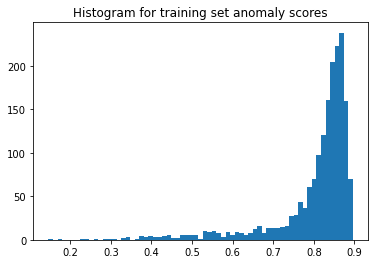

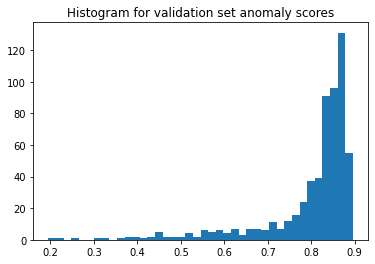

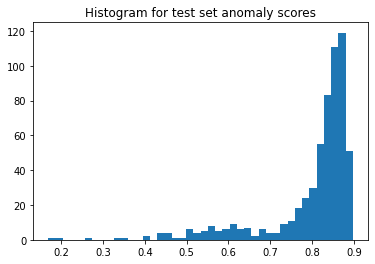

In [26]:
from pyod.models.mo_gaal import MO_GAAL

#find optimal number of generators
k_list = [5, 8, 10, 13, 15, 18, 20]
for x in k_list:
    clf31 = MO_GAAL(k=x, stop_epochs=100, contamination=outlier_ratio)
    clf31.fit(train_arr)
    print('k value %d' % x)
    viewOutliers(clf31)

k=10 seems to give good results. 

Use SUOD to combine the different models 

In [27]:
from pyod.models.suod import SUOD
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adam

from pyod.models.deep_svdd import DeepSVDD
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.cof import COF
from pyod.models.mo_gaal import MO_GAAL

adadelta = Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07)
adam = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)

#initialise group of heterogeneous OD models 
base_estimators = [
    AutoEncoder(l2_regularizer=0.3, dropout_rate=0.2, batch_size=32, hidden_neurons=[4, 3, 1, 1, 3, 4], contamination=outlier_ratio, epochs=300, optimizer=adam, random_state=42, preprocessing=False),
    DeepSVDD(epochs=100, optimizer=adadelta, hidden_neurons=[32, 16, 4], batch_size=64, random_state=42, preprocessing=False, contamination=outlier_ratio),
    MO_GAAL(k=10, stop_epochs=100, contamination=outlier_ratio)
]

#initialise SUOD with module flags
clf32=SUOD(base_estimators=base_estimators, rp_flag_global=True, approx_clf=RandomForestRegressor(), bps_flag=True, approx_flag_global=True)

#evaluate 
clf32.fit(train_arr)
train_scores = clf32.decision_function(train_arr)
val_scores = clf32.decision_function(val_arr)
test_scores = clf32.decision_function(test_arr)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1

51/51 [==============================] - 0s 8ms/step - loss: 0.0956 - val_loss: 0.0962
Epoch 58/300
51/51 [==============================] - 0s 8ms/step - loss: 0.0953 - val_loss: 0.0960
Epoch 59/300
51/51 [==============================] - 0s 8ms/step - loss: 0.0951 - val_loss: 0.0958
Epoch 60/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0949 - val_loss: 0.0955
Epoch 61/300
51/51 [==============================] - 0s 4ms/step - loss: 0.0946 - val_loss: 0.0953
Epoch 62/300
51/51 [==============================] - 0s 4ms/step - loss: 0.0945 - val_loss: 0.0951
Epoch 63/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0943 - val_loss: 0.0950
Epoch 64/300
51/51 [==============================] - 0s 4ms/step - loss: 0.0940 - val_loss: 0.0948
Epoch 65/300
51/51 [==============================] - 0s 4ms/step - loss: 0.0939 - val_loss: 0.0946
Epoch 66/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0937 - val_loss: 0.0945
Epoch 67/300


51/51 [==============================] - 0s 4ms/step - loss: 0.0917 - val_loss: 0.0926
Epoch 220/300
51/51 [==============================] - 0s 8ms/step - loss: 0.0917 - val_loss: 0.0926
Epoch 221/300
51/51 [==============================] - 0s 4ms/step - loss: 0.0917 - val_loss: 0.0926
Epoch 222/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0917 - val_loss: 0.0926
Epoch 223/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0917 - val_loss: 0.0926
Epoch 224/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0917 - val_loss: 0.0926
Epoch 225/300
51/51 [==============================] - 0s 4ms/step - loss: 0.0917 - val_loss: 0.0926
Epoch 226/300
51/51 [==============================] - 0s 4ms/step - loss: 0.0917 - val_loss: 0.0926
Epoch 227/300
51/51 [==============================] - 0s 5ms/step - loss: 0.0917 - val_loss: 0.0926
Epoch 228/300
51/51 [==============================] - 0s 7ms/step - loss: 0.0917 - val_loss: 0.0926
Epoc

26/26 [==============================] - 0s 5ms/step - loss: 0.1421 - val_loss: 0.1321
Epoch 65/100
26/26 [==============================] - 0s 5ms/step - loss: 0.1420 - val_loss: 0.1313
Epoch 66/100
26/26 [==============================] - 0s 4ms/step - loss: 0.1392 - val_loss: 0.1306
Epoch 67/100
26/26 [==============================] - 0s 4ms/step - loss: 0.1387 - val_loss: 0.1299
Epoch 68/100
26/26 [==============================] - 0s 4ms/step - loss: 0.1377 - val_loss: 0.1291
Epoch 69/100
26/26 [==============================] - 0s 3ms/step - loss: 0.1370 - val_loss: 0.1284
Epoch 70/100
26/26 [==============================] - 0s 4ms/step - loss: 0.1367 - val_loss: 0.1277
Epoch 71/100
26/26 [==============================] - 0s 4ms/step - loss: 0.1354 - val_loss: 0.1270
Epoch 72/100
26/26 [==============================] - 0s 4ms/step - loss: 0.1351 - val_loss: 0.1263
Epoch 73/100
26/26 [==============================] - 0s 4ms/step - loss: 0.1349 - val_loss: 0.1256
Epoch 74/100



Testing for epoch 15 index 3:
Epoch 16 of 300

Testing for epoch 16 index 1:

Testing for epoch 16 index 2:

Testing for epoch 16 index 3:
Epoch 17 of 300

Testing for epoch 17 index 1:

Testing for epoch 17 index 2:

Testing for epoch 17 index 3:
Epoch 18 of 300

Testing for epoch 18 index 1:

Testing for epoch 18 index 2:

Testing for epoch 18 index 3:
Epoch 19 of 300

Testing for epoch 19 index 1:

Testing for epoch 19 index 2:

Testing for epoch 19 index 3:
Epoch 20 of 300

Testing for epoch 20 index 1:

Testing for epoch 20 index 2:

Testing for epoch 20 index 3:
Epoch 21 of 300

Testing for epoch 21 index 1:

Testing for epoch 21 index 2:

Testing for epoch 21 index 3:
Epoch 22 of 300

Testing for epoch 22 index 1:

Testing for epoch 22 index 2:

Testing for epoch 22 index 3:
Epoch 23 of 300

Testing for epoch 23 index 1:

Testing for epoch 23 index 2:

Testing for epoch 23 index 3:
Epoch 24 of 300

Testing for epoch 24 index 1:

Testing for epoch 24 index 2:

Testing for epoch 

Epoch 91 of 300

Testing for epoch 91 index 1:

Testing for epoch 91 index 2:

Testing for epoch 91 index 3:
Epoch 92 of 300

Testing for epoch 92 index 1:

Testing for epoch 92 index 2:

Testing for epoch 92 index 3:
Epoch 93 of 300

Testing for epoch 93 index 1:

Testing for epoch 93 index 2:

Testing for epoch 93 index 3:
Epoch 94 of 300

Testing for epoch 94 index 1:

Testing for epoch 94 index 2:

Testing for epoch 94 index 3:
Epoch 95 of 300

Testing for epoch 95 index 1:

Testing for epoch 95 index 2:

Testing for epoch 95 index 3:
Epoch 96 of 300

Testing for epoch 96 index 1:

Testing for epoch 96 index 2:

Testing for epoch 96 index 3:
Epoch 97 of 300

Testing for epoch 97 index 1:

Testing for epoch 97 index 2:

Testing for epoch 97 index 3:
Epoch 98 of 300

Testing for epoch 98 index 1:

Testing for epoch 98 index 2:

Testing for epoch 98 index 3:
Epoch 99 of 300

Testing for epoch 99 index 1:

Testing for epoch 99 index 2:

Testing for epoch 99 index 3:
Epoch 100 of 300

T

16/16 [==============================] - 0s 2ms/step - loss: 0.7375

Testing for epoch 108 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7388
Epoch 109 of 300

Testing for epoch 109 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7421

Testing for epoch 109 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7420

Testing for epoch 109 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7467
Epoch 110 of 300

Testing for epoch 110 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7447

Testing for epoch 110 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7424

Testing for epoch 110 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7397
Epoch 111 of 300

Testing for epoch 111 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7496

Testing for epoch 111 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.7481
Epoch 116 of 300

Testing for epoch 116 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7492

Testing for epoch 116 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7586

Testing for epoch 116 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7482
Epoch 117 of 300

Testing for epoch 117 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7518

Testing for epoch 117 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7585

Testing for epoch 117 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7568
Epoch 118 of 300

Testing for epoch 118 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7524

Testing for epoch 118 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7548

Testing for epoch 118 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.7656

Testing for epoch 123 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7719
Epoch 124 of 300

Testing for epoch 124 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7655

Testing for epoch 124 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7686

Testing for epoch 124 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 0.7735
Epoch 125 of 300

Testing for epoch 125 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7623

Testing for epoch 125 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7690

Testing for epoch 125 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7669
Epoch 126 of 300

Testing for epoch 126 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7676

Testing for epoch 126 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.7744

Testing for epoch 127 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7779
Epoch 128 of 300

Testing for epoch 128 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7651

Testing for epoch 128 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7688

Testing for epoch 128 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7800
Epoch 129 of 300

Testing for epoch 129 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7746

Testing for epoch 129 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7784

Testing for epoch 129 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7828
Epoch 130 of 300

Testing for epoch 130 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7772

Testing for epoch 130 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.7816
Epoch 135 of 300

Testing for epoch 135 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7921

Testing for epoch 135 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7857

Testing for epoch 135 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.7858
Epoch 136 of 300

Testing for epoch 136 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7885

Testing for epoch 136 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.7831

Testing for epoch 136 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8055
Epoch 137 of 300

Testing for epoch 137 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.7871

Testing for epoch 137 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7904

Testing for epoch 137 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.8109

Testing for epoch 142 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 0.8156
Epoch 143 of 300

Testing for epoch 143 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8142

Testing for epoch 143 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8223

Testing for epoch 143 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8000
Epoch 144 of 300

Testing for epoch 144 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8165

Testing for epoch 144 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8136

Testing for epoch 144 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8039
Epoch 145 of 300

Testing for epoch 145 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8110

Testing for epoch 145 index 2:
16/16 [==============================] - 0s 1ms/s

16/16 [==============================] - 0s 1ms/step - loss: 0.8107

Testing for epoch 146 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8228

Testing for epoch 146 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8116
Epoch 147 of 300

Testing for epoch 147 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8188

Testing for epoch 147 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8176

Testing for epoch 147 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8204
Epoch 148 of 300

Testing for epoch 148 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8221

Testing for epoch 148 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8131

Testing for epoch 148 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8329
Epoch 149 of 300

Testing for epoch 149 index 1:
16/16 [==============================] - 0s 933us

16/16 [==============================] - 0s 2ms/step - loss: 0.8413
Epoch 154 of 300

Testing for epoch 154 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8296

Testing for epoch 154 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8427

Testing for epoch 154 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8335
Epoch 155 of 300

Testing for epoch 155 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8445

Testing for epoch 155 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8396

Testing for epoch 155 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8321
Epoch 156 of 300

Testing for epoch 156 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8502

Testing for epoch 156 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8336

Testing for epoch 156 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.8574
Epoch 158 of 300

Testing for epoch 158 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8517

Testing for epoch 158 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8592

Testing for epoch 158 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8518
Epoch 159 of 300

Testing for epoch 159 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8743

Testing for epoch 159 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8657

Testing for epoch 159 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8723
Epoch 160 of 300

Testing for epoch 160 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8509

Testing for epoch 160 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8588

Testing for epoch 160 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.8791

Testing for epoch 165 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8881

Testing for epoch 165 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8812
Epoch 166 of 300

Testing for epoch 166 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8677

Testing for epoch 166 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.8905

Testing for epoch 166 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8687
Epoch 167 of 300

Testing for epoch 167 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.8784

Testing for epoch 167 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8882

Testing for epoch 167 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9007
Epoch 168 of 300

Testing for epoch 168 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.9103
Epoch 173 of 300

Testing for epoch 173 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9176

Testing for epoch 173 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9084

Testing for epoch 173 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.8982
Epoch 174 of 300

Testing for epoch 174 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9099

Testing for epoch 174 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 0.9067

Testing for epoch 174 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9193
Epoch 175 of 300

Testing for epoch 175 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9204

Testing for epoch 175 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9087

Testing for epoch 175 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 3ms/step - loss: 0.9320

Testing for epoch 180 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9566
Epoch 181 of 300

Testing for epoch 181 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 0.9458

Testing for epoch 181 index 2:
16/16 [==============================] - ETA: 0s - loss: 0.953 - 0s 2ms/step - loss: 0.9379

Testing for epoch 181 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9290
Epoch 182 of 300

Testing for epoch 182 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9425

Testing for epoch 182 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9612

Testing for epoch 182 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9493
Epoch 183 of 300

Testing for epoch 183 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9556

Testing for epoch 183 index 2:
16/16 [==================

16/16 [==============================] - 0s 2ms/step - loss: 0.9676

Testing for epoch 184 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9524

Testing for epoch 184 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9527
Epoch 185 of 300

Testing for epoch 185 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 0.9702

Testing for epoch 185 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9879

Testing for epoch 185 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9562
Epoch 186 of 300

Testing for epoch 186 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9429

Testing for epoch 186 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 0.9965

Testing for epoch 186 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9346
Epoch 187 of 300

Testing for epoch 187 index 1:
16/16 [==============================] - 0s 2m

16/16 [==============================] - 0s 2ms/step - loss: 0.9452

Testing for epoch 188 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9849

Testing for epoch 188 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9794
Epoch 189 of 300

Testing for epoch 189 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9464

Testing for epoch 189 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9827

Testing for epoch 189 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9686
Epoch 190 of 300

Testing for epoch 190 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 0.9698

Testing for epoch 190 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 0.9755

Testing for epoch 190 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 0.9978
Epoch 191 of 300

Testing for epoch 191 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.0012

Testing for epoch 195 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0212
Epoch 196 of 300

Testing for epoch 196 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0011

Testing for epoch 196 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0211

Testing for epoch 196 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0112
Epoch 197 of 300

Testing for epoch 197 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0140

Testing for epoch 197 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0285

Testing for epoch 197 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0157
Epoch 198 of 300

Testing for epoch 198 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0082

Testing for epoch 198 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.0461

Testing for epoch 203 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0549

Testing for epoch 203 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0718
Epoch 204 of 300

Testing for epoch 204 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0663

Testing for epoch 204 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.0825

Testing for epoch 204 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0412
Epoch 205 of 300

Testing for epoch 205 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0627

Testing for epoch 205 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0863

Testing for epoch 205 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0577
Epoch 206 of 300

Testing for epoch 206 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.0791
Epoch 211 of 300

Testing for epoch 211 index 1:
16/16 [==============================] - 0s 3ms/step - loss: 1.0948

Testing for epoch 211 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1154

Testing for epoch 211 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.0947
Epoch 212 of 300

Testing for epoch 212 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1196

Testing for epoch 212 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.0537

Testing for epoch 212 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1293
Epoch 213 of 300

Testing for epoch 213 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.0593

Testing for epoch 213 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1215

Testing for epoch 213 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.1506

Testing for epoch 218 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1615
Epoch 219 of 300

Testing for epoch 219 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1058

Testing for epoch 219 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1543

Testing for epoch 219 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1138
Epoch 220 of 300

Testing for epoch 220 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1533

Testing for epoch 220 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1636

Testing for epoch 220 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.1514
Epoch 221 of 300

Testing for epoch 221 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1738

Testing for epoch 221 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.1722
Epoch 226 of 300

Testing for epoch 226 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1767

Testing for epoch 226 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2031

Testing for epoch 226 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2320
Epoch 227 of 300

Testing for epoch 227 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1889

Testing for epoch 227 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2319

Testing for epoch 227 index 3:
16/16 [==============================] - 0s 934us/step - loss: 1.1891
Epoch 228 of 300

Testing for epoch 228 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.1915

Testing for epoch 228 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.1671

Testing for epoch 228 index 3:
16/16 [==============================] - 0s 2ms

16/16 [==============================] - 0s 2ms/step - loss: 1.2253

Testing for epoch 233 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2385
Epoch 234 of 300

Testing for epoch 234 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2344

Testing for epoch 234 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2268

Testing for epoch 234 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.2274
Epoch 235 of 300

Testing for epoch 235 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2206

Testing for epoch 235 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2409

Testing for epoch 235 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2450
Epoch 236 of 300

Testing for epoch 236 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2692

Testing for epoch 236 index 2:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.2836

Testing for epoch 241 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2747

Testing for epoch 241 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3068
Epoch 242 of 300

Testing for epoch 242 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2663

Testing for epoch 242 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2449

Testing for epoch 242 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3338
Epoch 243 of 300

Testing for epoch 243 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.2430

Testing for epoch 243 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 1.3047

Testing for epoch 243 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.2773
Epoch 244 of 300

Testing for epoch 244 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.3345
Epoch 249 of 300

Testing for epoch 249 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.3096

Testing for epoch 249 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3016

Testing for epoch 249 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3367
Epoch 250 of 300

Testing for epoch 250 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.3354

Testing for epoch 250 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3199

Testing for epoch 250 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3858
Epoch 251 of 300

Testing for epoch 251 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.3110

Testing for epoch 251 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.2924

Testing for epoch 251 index 3:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.4118

Testing for epoch 256 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3706

Testing for epoch 256 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4020
Epoch 257 of 300

Testing for epoch 257 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4253

Testing for epoch 257 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.3289

Testing for epoch 257 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3792
Epoch 258 of 300

Testing for epoch 258 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.3853

Testing for epoch 258 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.3747

Testing for epoch 258 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3528
Epoch 259 of 300

Testing for epoch 259 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 966us/step - loss: 1.4084
Epoch 264 of 300

Testing for epoch 264 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4093

Testing for epoch 264 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4790

Testing for epoch 264 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3639
Epoch 265 of 300

Testing for epoch 265 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4107

Testing for epoch 265 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4120

Testing for epoch 265 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.3856
Epoch 266 of 300

Testing for epoch 266 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4584

Testing for epoch 266 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4013

Testing for epoch 266 index 3:
16/16 [==============================] - 0s 2ms

16/16 [==============================] - 0s 2ms/step - loss: 1.3911

Testing for epoch 271 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5051
Epoch 272 of 300

Testing for epoch 272 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4825

Testing for epoch 272 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4387

Testing for epoch 272 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4703
Epoch 273 of 300

Testing for epoch 273 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.4521

Testing for epoch 273 index 2:
16/16 [==============================] - 0s 3ms/step - loss: 1.4351

Testing for epoch 273 index 3:
16/16 [==============================] - 0s 3ms/step - loss: 1.5270
Epoch 274 of 300

Testing for epoch 274 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.4344

Testing for epoch 274 index 2:
16/16 [==============================] - 0s 2ms

16/16 [==============================] - 0s 2ms/step - loss: 1.5059

Testing for epoch 279 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4115

Testing for epoch 279 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.4874
Epoch 280 of 300

Testing for epoch 280 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.5815

Testing for epoch 280 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.5896

Testing for epoch 280 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5672
Epoch 281 of 300

Testing for epoch 281 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.5292

Testing for epoch 281 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.4899

Testing for epoch 281 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.5807
Epoch 282 of 300

Testing for epoch 282 index 1:
16/16 [==============================] - 0s 2ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.5107

Testing for epoch 286 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5603
Epoch 287 of 300

Testing for epoch 287 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.5500

Testing for epoch 287 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.6129

Testing for epoch 287 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5558
Epoch 288 of 300

Testing for epoch 288 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.5608

Testing for epoch 288 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.5799

Testing for epoch 288 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.5527
Epoch 289 of 300

Testing for epoch 289 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.5050

Testing for epoch 289 index 2:
16/16 [==============================] - 0s 1ms/s

16/16 [==============================] - 0s 2ms/step - loss: 1.5944

Testing for epoch 294 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.5673

Testing for epoch 294 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.6228
Epoch 295 of 300

Testing for epoch 295 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.6266

Testing for epoch 295 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.6420

Testing for epoch 295 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.6252
Epoch 296 of 300

Testing for epoch 296 index 1:
16/16 [==============================] - 0s 2ms/step - loss: 1.5927

Testing for epoch 296 index 2:
16/16 [==============================] - 0s 2ms/step - loss: 1.6629

Testing for epoch 296 index 3:
16/16 [==============================] - 0s 2ms/step - loss: 1.6258
Epoch 297 of 300

Testing for epoch 297 index 1:
16/16 [==============================] - 0s 2ms/s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 29.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


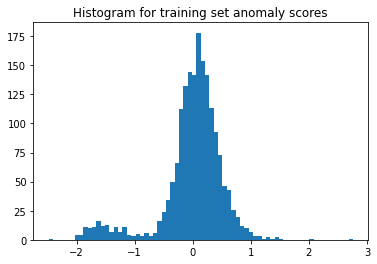

In [31]:
plt.hist(train_scores, bins='auto')
plt.title("Histogram for training set anomaly scores")
plt.show()

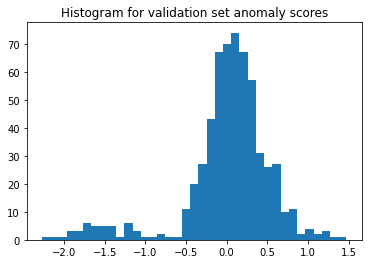

In [32]:
plt.hist(val_scores, bins='auto')
plt.title("Histogram for validation set anomaly scores")
plt.show()

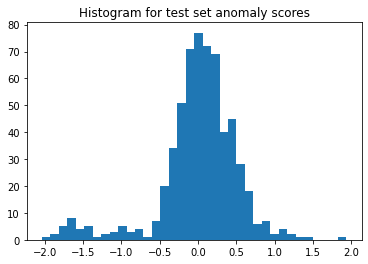

In [33]:
plt.hist(test_scores, bins='auto')
plt.title("Histogram for test set anomaly scores")
plt.show()

Using Locally Selective Combination of Parallel Outlier Ensembles

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 4)                 20        
_________________________________________________________________
dropout_10 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_36 (Dense)             (None, 4)                 20        
_________________________________________________________________
dropout_11 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 4)                 20        
_________________________________________________________________
dropout_12 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_38 (Dense)             (None, 3)               

51/51 [==============================] - 0s 3ms/step - loss: 0.0919 - val_loss: 0.0911
Epoch 138/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0919 - val_loss: 0.0911
Epoch 139/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0919 - val_loss: 0.0911
Epoch 140/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0919 - val_loss: 0.0911
Epoch 141/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0919 - val_loss: 0.0911
Epoch 142/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0919 - val_loss: 0.0911
Epoch 143/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0919 - val_loss: 0.0911
Epoch 144/300
51/51 [==============================] - 0s 3ms/step - loss: 0.0919 - val_loss: 0.0911
Epoch 145/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0919 - val_loss: 0.0911
Epoch 146/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0919 - val_loss: 0.0911
Epoc

51/51 [==============================] - 0s 2ms/step - loss: 0.0919 - val_loss: 0.0911
Epoch 300/300
51/51 [==============================] - 0s 2ms/step - loss: 0.0919 - val_loss: 0.0911
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_46 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_47 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_19 (Dropout)         (None, 16)                0         
_________________________________________________________________
net_output (Dense)           (None, 4)                 68        
_________________________________________________________________
tf

26/26 [==============================] - 0s 2ms/step - loss: 0.0698 - val_loss: 0.0695
Epoch 64/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0691
Epoch 65/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0693 - val_loss: 0.0688
Epoch 66/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0689 - val_loss: 0.0684
Epoch 67/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0684 - val_loss: 0.0681
Epoch 68/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0680 - val_loss: 0.0678
Epoch 69/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0679 - val_loss: 0.0674
Epoch 70/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0679 - val_loss: 0.0671
Epoch 71/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0668
Epoch 72/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0664
Epoch 73/100


Epoch 42 of 300

Testing for epoch 42 index 1:

Testing for epoch 42 index 2:

Testing for epoch 42 index 3:
Epoch 43 of 300

Testing for epoch 43 index 1:

Testing for epoch 43 index 2:

Testing for epoch 43 index 3:
Epoch 44 of 300

Testing for epoch 44 index 1:

Testing for epoch 44 index 2:

Testing for epoch 44 index 3:
Epoch 45 of 300

Testing for epoch 45 index 1:

Testing for epoch 45 index 2:

Testing for epoch 45 index 3:
Epoch 46 of 300

Testing for epoch 46 index 1:

Testing for epoch 46 index 2:

Testing for epoch 46 index 3:
Epoch 47 of 300

Testing for epoch 47 index 1:

Testing for epoch 47 index 2:

Testing for epoch 47 index 3:
Epoch 48 of 300

Testing for epoch 48 index 1:

Testing for epoch 48 index 2:

Testing for epoch 48 index 3:
Epoch 49 of 300

Testing for epoch 49 index 1:

Testing for epoch 49 index 2:

Testing for epoch 49 index 3:
Epoch 50 of 300

Testing for epoch 50 index 1:

Testing for epoch 50 index 2:

Testing for epoch 50 index 3:
Epoch 51 of 300

Te

16/16 [==============================] - 0s 866us/step - loss: 0.7385
Epoch 106 of 300

Testing for epoch 106 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7448

Testing for epoch 106 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7394

Testing for epoch 106 index 3:
16/16 [==============================] - 0s 944us/step - loss: 0.7480
Epoch 107 of 300

Testing for epoch 107 index 1:
16/16 [==============================] - 0s 934us/step - loss: 0.7357

Testing for epoch 107 index 2:
16/16 [==============================] - 0s 935us/step - loss: 0.7487

Testing for epoch 107 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7428
Epoch 108 of 300

Testing for epoch 108 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.7486

Testing for epoch 108 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.7389

Testing for epoch 108 index 3:
16/16 [==============================

16/16 [==============================] - 0s 868us/step - loss: 0.7415

Testing for epoch 113 index 2:
16/16 [==============================] - 0s 908us/step - loss: 0.7507

Testing for epoch 113 index 3:
16/16 [==============================] - 0s 910us/step - loss: 0.7525
Epoch 114 of 300

Testing for epoch 114 index 1:
16/16 [==============================] - 0s 950us/step - loss: 0.7633

Testing for epoch 114 index 2:
16/16 [==============================] - 0s 994us/step - loss: 0.7683

Testing for epoch 114 index 3:
16/16 [==============================] - 0s 935us/step - loss: 0.7516
Epoch 115 of 300

Testing for epoch 115 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.7512

Testing for epoch 115 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.7448

Testing for epoch 115 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 0.7582
Epoch 116 of 300

Testing for epoch 116 index 1:
16/16 [=======================

16/16 [==============================] - 0s 867us/step - loss: 0.7529
Epoch 117 of 300

Testing for epoch 117 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 0.7586

Testing for epoch 117 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 0.7508

Testing for epoch 117 index 3:
16/16 [==============================] - 0s 933us/step - loss: 0.7647
Epoch 118 of 300

Testing for epoch 118 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7658

Testing for epoch 118 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7607

Testing for epoch 118 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7574
Epoch 119 of 300

Testing for epoch 119 index 1:
16/16 [==============================] - 0s 978us/step - loss: 0.7647

Testing for epoch 119 index 2:
16/16 [==============================] - 0s 867us/step - loss: 0.7528

Testing for epoch 119 index 3:
16/16 [============================


Testing for epoch 120 index 3:
16/16 [==============================] - 0s 932us/step - loss: 0.7689
Epoch 121 of 300

Testing for epoch 121 index 1:
16/16 [==============================] - 0s 932us/step - loss: 0.7677

Testing for epoch 121 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.7741

Testing for epoch 121 index 3:
16/16 [==============================] - 0s 932us/step - loss: 0.7759
Epoch 122 of 300

Testing for epoch 122 index 1:
16/16 [==============================] - 0s 869us/step - loss: 0.7671

Testing for epoch 122 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7576

Testing for epoch 122 index 3:
16/16 [==============================] - 0s 866us/step - loss: 0.7636
Epoch 123 of 300

Testing for epoch 123 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7665

Testing for epoch 123 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7743

Testing for epoch 123 index 3:
16/16

16/16 [==============================] - 0s 936us/step - loss: 0.7724

Testing for epoch 124 index 3:
16/16 [==============================] - 0s 866us/step - loss: 0.7760
Epoch 125 of 300

Testing for epoch 125 index 1:
16/16 [==============================] - 0s 956us/step - loss: 0.7707

Testing for epoch 125 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7893

Testing for epoch 125 index 3:
16/16 [==============================] - 0s 866us/step - loss: 0.7729
Epoch 126 of 300

Testing for epoch 126 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7768

Testing for epoch 126 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7894

Testing for epoch 126 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7913
Epoch 127 of 300

Testing for epoch 127 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.7859

Testing for epoch 127 index 2:
16/16 [==============================] - 

16/16 [==============================] - 0s 802us/step - loss: 0.8015
Epoch 132 of 300

Testing for epoch 132 index 1:
16/16 [==============================] - 0s 932us/step - loss: 0.7930

Testing for epoch 132 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.8030

Testing for epoch 132 index 3:
16/16 [==============================] - 0s 950us/step - loss: 0.7911
Epoch 133 of 300

Testing for epoch 133 index 1:
16/16 [==============================] - 0s 869us/step - loss: 0.7874

Testing for epoch 133 index 2:
16/16 [==============================] - 0s 935us/step - loss: 0.8039

Testing for epoch 133 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.7912
Epoch 134 of 300

Testing for epoch 134 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8131

Testing for epoch 134 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7872

Testing for epoch 134 index 3:
16/16 [==============================

16/16 [==============================] - 0s 1000us/step - loss: 0.8171

Testing for epoch 139 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.7954

Testing for epoch 139 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8197
Epoch 140 of 300

Testing for epoch 140 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8157

Testing for epoch 140 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.8061

Testing for epoch 140 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8248
Epoch 141 of 300

Testing for epoch 141 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8104

Testing for epoch 141 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8103

Testing for epoch 141 index 3:
16/16 [==============================] - 0s 977us/step - loss: 0.8256
Epoch 142 of 300

Testing for epoch 142 index 1:
16/16 [==============================] - 0

16/16 [==============================] - 0s 969us/step - loss: 0.8307
Epoch 143 of 300

Testing for epoch 143 index 1:
16/16 [==============================] - 0s 999us/step - loss: 0.8180

Testing for epoch 143 index 2:
16/16 [==============================] - 0s 992us/step - loss: 0.8331

Testing for epoch 143 index 3:
16/16 [==============================] - 0s 932us/step - loss: 0.8263
Epoch 144 of 300

Testing for epoch 144 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.8315

Testing for epoch 144 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8214

Testing for epoch 144 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8337
Epoch 145 of 300

Testing for epoch 145 index 1:
16/16 [==============================] - 0s 935us/step - loss: 0.8316

Testing for epoch 145 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.8380

Testing for epoch 145 index 3:
16/16 [==============================

16/16 [==============================] - 0s 937us/step - loss: 0.8458

Testing for epoch 150 index 3:
16/16 [==============================] - 0s 934us/step - loss: 0.8382
Epoch 151 of 300

Testing for epoch 151 index 1:
16/16 [==============================] - 0s 867us/step - loss: 0.8356

Testing for epoch 151 index 2:
16/16 [==============================] - 0s 935us/step - loss: 0.8455

Testing for epoch 151 index 3:
16/16 [==============================] - 0s 933us/step - loss: 0.8430
Epoch 152 of 300

Testing for epoch 152 index 1:
16/16 [==============================] - 0s 799us/step - loss: 0.8574

Testing for epoch 152 index 2:
16/16 [==============================] - 0s 816us/step - loss: 0.8705

Testing for epoch 152 index 3:
16/16 [==============================] - 0s 866us/step - loss: 0.8569
Epoch 153 of 300

Testing for epoch 153 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.8702

Testing for epoch 153 index 2:
16/16 [==========================

16/16 [==============================] - 0s 933us/step - loss: 0.8702
Epoch 158 of 300

Testing for epoch 158 index 1:
16/16 [==============================] - 0s 865us/step - loss: 0.8837

Testing for epoch 158 index 2:
16/16 [==============================] - 0s 839us/step - loss: 0.8940

Testing for epoch 158 index 3:
16/16 [==============================] - 0s 933us/step - loss: 0.8751
Epoch 159 of 300

Testing for epoch 159 index 1:
16/16 [==============================] - 0s 868us/step - loss: 0.9014

Testing for epoch 159 index 2:
16/16 [==============================] - 0s 939us/step - loss: 0.8839

Testing for epoch 159 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.8904
Epoch 160 of 300

Testing for epoch 160 index 1:
16/16 [==============================] - 0s 866us/step - loss: 0.8878

Testing for epoch 160 index 2:
16/16 [==============================] - 0s 935us/step - loss: 0.8864

Testing for epoch 160 index 3:
16/16 [==========================

16/16 [==============================] - 0s 1ms/step - loss: 0.8969

Testing for epoch 165 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9126

Testing for epoch 165 index 3:
16/16 [==============================] - 0s 893us/step - loss: 0.9070
Epoch 166 of 300

Testing for epoch 166 index 1:
16/16 [==============================] - 0s 867us/step - loss: 0.8884

Testing for epoch 166 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 0.9121

Testing for epoch 166 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9141
Epoch 167 of 300

Testing for epoch 167 index 1:
16/16 [==============================] - 0s 866us/step - loss: 0.9300

Testing for epoch 167 index 2:
16/16 [==============================] - 0s 936us/step - loss: 0.9172

Testing for epoch 167 index 3:
16/16 [==============================] - 0s 934us/step - loss: 0.9267
Epoch 168 of 300

Testing for epoch 168 index 1:
16/16 [=============================

16/16 [==============================] - 0s 800us/step - loss: 0.9553

Testing for epoch 172 index 3:
16/16 [==============================] - ETA: 0s - loss: 0.949 - 0s 1ms/step - loss: 0.9609
Epoch 173 of 300

Testing for epoch 173 index 1:
16/16 [==============================] - 0s 866us/step - loss: 0.9349

Testing for epoch 173 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9268

Testing for epoch 173 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9322
Epoch 174 of 300

Testing for epoch 174 index 1:
16/16 [==============================] - 0s 928us/step - loss: 0.9525

Testing for epoch 174 index 2:
16/16 [==============================] - 0s 933us/step - loss: 0.9231

Testing for epoch 174 index 3:
16/16 [==============================] - 0s 958us/step - loss: 0.9473
Epoch 175 of 300

Testing for epoch 175 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9381

Testing for epoch 175 index 2:
16/16 [========

16/16 [==============================] - 0s 867us/step - loss: 0.9615

Testing for epoch 176 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 0.9851
Epoch 177 of 300

Testing for epoch 177 index 1:
16/16 [==============================] - 0s 933us/step - loss: 0.9808

Testing for epoch 177 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9749

Testing for epoch 177 index 3:
16/16 [==============================] - 0s 926us/step - loss: 0.9654
Epoch 178 of 300

Testing for epoch 178 index 1:
16/16 [==============================] - 0s 937us/step - loss: 0.9447

Testing for epoch 178 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9830

Testing for epoch 178 index 3:
16/16 [==============================] - 0s 866us/step - loss: 0.9704
Epoch 179 of 300

Testing for epoch 179 index 1:
16/16 [==============================] - 0s 968us/step - loss: 0.9862

Testing for epoch 179 index 2:
16/16 [==============================

16/16 [==============================] - 0s 933us/step - loss: 0.9983
Epoch 184 of 300

Testing for epoch 184 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 0.9751

Testing for epoch 184 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 0.9950

Testing for epoch 184 index 3:
16/16 [==============================] - 0s 946us/step - loss: 1.0024
Epoch 185 of 300

Testing for epoch 185 index 1:
16/16 [==============================] - 0s 868us/step - loss: 0.9995

Testing for epoch 185 index 2:
16/16 [==============================] - 0s 865us/step - loss: 1.0520

Testing for epoch 185 index 3:
16/16 [==============================] - 0s 935us/step - loss: 0.9989
Epoch 186 of 300

Testing for epoch 186 index 1:
16/16 [==============================] - 0s 864us/step - loss: 0.9993

Testing for epoch 186 index 2:
16/16 [==============================] - 0s 935us/step - loss: 1.0002

Testing for epoch 186 index 3:
16/16 [============================

16/16 [==============================] - 0s 955us/step - loss: 1.0572

Testing for epoch 191 index 2:
16/16 [==============================] - 0s 937us/step - loss: 1.0492

Testing for epoch 191 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.0387
Epoch 192 of 300

Testing for epoch 192 index 1:
16/16 [==============================] - 0s 800us/step - loss: 1.0216

Testing for epoch 192 index 2:
16/16 [==============================] - 0s 916us/step - loss: 1.0302

Testing for epoch 192 index 3:
16/16 [==============================] - 0s 867us/step - loss: 1.0611
Epoch 193 of 300

Testing for epoch 193 index 1:
16/16 [==============================] - 0s 995us/step - loss: 1.0676

Testing for epoch 193 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.0705

Testing for epoch 193 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.0403
Epoch 194 of 300

Testing for epoch 194 index 1:
16/16 [============================

16/16 [==============================] - 0s 1ms/step - loss: 1.0940

Testing for epoch 198 index 3:
16/16 [==============================] - 0s 871us/step - loss: 1.0821
Epoch 199 of 300

Testing for epoch 199 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 1.1108

Testing for epoch 199 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.0959

Testing for epoch 199 index 3:
16/16 [==============================] - 0s 999us/step - loss: 1.1074
Epoch 200 of 300

Testing for epoch 200 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.0871

Testing for epoch 200 index 2:
16/16 [==============================] - 0s 934us/step - loss: 1.1067

Testing for epoch 200 index 3:
16/16 [==============================] - 0s 935us/step - loss: 1.1256
Epoch 201 of 300

Testing for epoch 201 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.1195

Testing for epoch 201 index 2:
16/16 [=============================

16/16 [==============================] - 0s 1ms/step - loss: 1.0957

Testing for epoch 206 index 2:
16/16 [==============================] - 0s 999us/step - loss: 1.1516

Testing for epoch 206 index 3:
16/16 [==============================] - 0s 934us/step - loss: 1.1258
Epoch 207 of 300

Testing for epoch 207 index 1:
16/16 [==============================] - 0s 907us/step - loss: 1.1372

Testing for epoch 207 index 2:
16/16 [==============================] - 0s 897us/step - loss: 1.1550

Testing for epoch 207 index 3:
16/16 [==============================] - 0s 867us/step - loss: 1.1374
Epoch 208 of 300

Testing for epoch 208 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.1415

Testing for epoch 208 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.1628

Testing for epoch 208 index 3:
16/16 [==============================] - 0s 867us/step - loss: 1.1516
Epoch 209 of 300

Testing for epoch 209 index 1:
16/16 [============================

16/16 [==============================] - 0s 1ms/step - loss: 1.1471

Testing for epoch 213 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.2032
Epoch 214 of 300

Testing for epoch 214 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.1970

Testing for epoch 214 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.1861

Testing for epoch 214 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.2085
Epoch 215 of 300

Testing for epoch 215 index 1:
16/16 [==============================] - 0s 934us/step - loss: 1.1726

Testing for epoch 215 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.2317

Testing for epoch 215 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.1938
Epoch 216 of 300

Testing for epoch 216 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.2084

Testing for epoch 216 index 2:
16/16 [==============================] - 0s

16/16 [==============================] - 0s 867us/step - loss: 1.2419
Epoch 221 of 300

Testing for epoch 221 index 1:
16/16 [==============================] - 0s 960us/step - loss: 1.2491

Testing for epoch 221 index 2:
16/16 [==============================] - 0s 945us/step - loss: 1.2693

Testing for epoch 221 index 3:
16/16 [==============================] - 0s 934us/step - loss: 1.2561
Epoch 222 of 300

Testing for epoch 222 index 1:
16/16 [==============================] - 0s 934us/step - loss: 1.2231

Testing for epoch 222 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.2650

Testing for epoch 222 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.2486
Epoch 223 of 300

Testing for epoch 223 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.2719

Testing for epoch 223 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.2068

Testing for epoch 223 index 3:
16/16 [============================

16/16 [==============================] - 0s 1ms/step - loss: 1.3159

Testing for epoch 228 index 2:
16/16 [==============================] - 0s 961us/step - loss: 1.3438

Testing for epoch 228 index 3:
16/16 [==============================] - 0s 801us/step - loss: 1.3069
Epoch 229 of 300

Testing for epoch 229 index 1:
16/16 [==============================] - 0s 973us/step - loss: 1.3702

Testing for epoch 229 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.2940

Testing for epoch 229 index 3:
16/16 [==============================] - 0s 799us/step - loss: 1.3363
Epoch 230 of 300

Testing for epoch 230 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.3391

Testing for epoch 230 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.2588

Testing for epoch 230 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.3038
Epoch 231 of 300

Testing for epoch 231 index 1:
16/16 [==============================] 

16/16 [==============================] - 0s 980us/step - loss: 1.3443
Epoch 236 of 300

Testing for epoch 236 index 1:
16/16 [==============================] - 0s 823us/step - loss: 1.3431

Testing for epoch 236 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.3476

Testing for epoch 236 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.3674
Epoch 237 of 300

Testing for epoch 237 index 1:
16/16 [==============================] - 0s 940us/step - loss: 1.3626

Testing for epoch 237 index 2:
16/16 [==============================] - ETA: 0s - loss: 1.279 - 0s 890us/step - loss: 1.3671

Testing for epoch 237 index 3:
16/16 [==============================] - 0s 800us/step - loss: 1.3688
Epoch 238 of 300

Testing for epoch 238 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.3483

Testing for epoch 238 index 2:
16/16 [==============================] - 0s 800us/step - loss: 1.3861

Testing for epoch 238 index 3:
16/16 [

16/16 [==============================] - 0s 866us/step - loss: 1.4076

Testing for epoch 243 index 2:
16/16 [==============================] - 0s 910us/step - loss: 1.3640

Testing for epoch 243 index 3:
16/16 [==============================] - 0s 949us/step - loss: 1.3713
Epoch 244 of 300

Testing for epoch 244 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.3461

Testing for epoch 244 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.4239

Testing for epoch 244 index 3:
16/16 [==============================] - 0s 866us/step - loss: 1.4115
Epoch 245 of 300

Testing for epoch 245 index 1:
16/16 [==============================] - 0s 915us/step - loss: 1.4266

Testing for epoch 245 index 2:
16/16 [==============================] - 0s 946us/step - loss: 1.4257

Testing for epoch 245 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.4427
Epoch 246 of 300

Testing for epoch 246 index 1:
16/16 [=========================

16/16 [==============================] - 0s 1ms/step - loss: 1.3842
Epoch 247 of 300

Testing for epoch 247 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.4288

Testing for epoch 247 index 2:
16/16 [==============================] - 0s 866us/step - loss: 1.4421

Testing for epoch 247 index 3:
16/16 [==============================] - 0s 866us/step - loss: 1.4448
Epoch 248 of 300

Testing for epoch 248 index 1:
16/16 [==============================] - 0s 980us/step - loss: 1.4342

Testing for epoch 248 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.4380

Testing for epoch 248 index 3:
16/16 [==============================] - 0s 867us/step - loss: 1.4122
Epoch 249 of 300

Testing for epoch 249 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.4754

Testing for epoch 249 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5389

Testing for epoch 249 index 3:
16/16 [==============================] 

16/16 [==============================] - 0s 1ms/step - loss: 1.5610

Testing for epoch 254 index 2:
16/16 [==============================] - 0s 869us/step - loss: 1.5070

Testing for epoch 254 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.4979
Epoch 255 of 300

Testing for epoch 255 index 1:
16/16 [==============================] - 0s 845us/step - loss: 1.5523

Testing for epoch 255 index 2:
16/16 [==============================] - 0s 867us/step - loss: 1.5209

Testing for epoch 255 index 3:
16/16 [==============================] - 0s 979us/step - loss: 1.5080
Epoch 256 of 300

Testing for epoch 256 index 1:
16/16 [==============================] - 0s 1000us/step - loss: 1.5231

Testing for epoch 256 index 2:
16/16 [==============================] - 0s 882us/step - loss: 1.4856

Testing for epoch 256 index 3:
16/16 [==============================] - 0s 999us/step - loss: 1.5221
Epoch 257 of 300

Testing for epoch 257 index 1:
16/16 [========================

16/16 [==============================] - 0s 1000us/step - loss: 1.5031
Epoch 262 of 300

Testing for epoch 262 index 1:
16/16 [==============================] - 0s 868us/step - loss: 1.5692

Testing for epoch 262 index 2:
16/16 [==============================] - 0s 911us/step - loss: 1.4523

Testing for epoch 262 index 3:
16/16 [==============================] - 0s 940us/step - loss: 1.5512
Epoch 263 of 300

Testing for epoch 263 index 1:
16/16 [==============================] - 0s 934us/step - loss: 1.5840

Testing for epoch 263 index 2:
16/16 [==============================] - 0s 922us/step - loss: 1.5995

Testing for epoch 263 index 3:
16/16 [==============================] - 0s 800us/step - loss: 1.5751
Epoch 264 of 300

Testing for epoch 264 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.5593

Testing for epoch 264 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.5429

Testing for epoch 264 index 3:
16/16 [===========================

16/16 [==============================] - 0s 933us/step - loss: 1.6332

Testing for epoch 269 index 2:
16/16 [==============================] - 0s 999us/step - loss: 1.5812

Testing for epoch 269 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.6454
Epoch 270 of 300

Testing for epoch 270 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.5918

Testing for epoch 270 index 2:
16/16 [==============================] - 0s 971us/step - loss: 1.6396

Testing for epoch 270 index 3:
16/16 [==============================] - 0s 924us/step - loss: 1.6511
Epoch 271 of 300

Testing for epoch 271 index 1:
16/16 [==============================] - 0s 867us/step - loss: 1.6629

Testing for epoch 271 index 2:
16/16 [==============================] - 0s 979us/step - loss: 1.6096

Testing for epoch 271 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.6757
Epoch 272 of 300

Testing for epoch 272 index 1:
16/16 [=========================

16/16 [==============================] - 0s 998us/step - loss: 1.7316

Testing for epoch 276 index 3:
16/16 [==============================] - 0s 867us/step - loss: 1.6184
Epoch 277 of 300

Testing for epoch 277 index 1:
16/16 [==============================] - 0s 924us/step - loss: 1.7064

Testing for epoch 277 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.6449

Testing for epoch 277 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.6694
Epoch 278 of 300

Testing for epoch 278 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.6576

Testing for epoch 278 index 2:
16/16 [==============================] - 0s 868us/step - loss: 1.7096

Testing for epoch 278 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.6812
Epoch 279 of 300

Testing for epoch 279 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.6288

Testing for epoch 279 index 2:
16/16 [=============================

16/16 [==============================] - 0s 999us/step - loss: 1.7357
Epoch 284 of 300

Testing for epoch 284 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.6605

Testing for epoch 284 index 2:
16/16 [==============================] - 0s 933us/step - loss: 1.7483

Testing for epoch 284 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.7400
Epoch 285 of 300

Testing for epoch 285 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.7360

Testing for epoch 285 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 1.7732

Testing for epoch 285 index 3:
16/16 [==============================] - 0s 1000us/step - loss: 1.7332
Epoch 286 of 300

Testing for epoch 286 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.6622

Testing for epoch 286 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.7182

Testing for epoch 286 index 3:
16/16 [===========================

16/16 [==============================] - 0s 1ms/step - loss: 1.7374

Testing for epoch 291 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.7766
Epoch 292 of 300

Testing for epoch 292 index 1:
16/16 [==============================] - 0s 1ms/step - loss: 1.8426

Testing for epoch 292 index 2:
16/16 [==============================] - 0s 1000us/step - loss: 1.7736

Testing for epoch 292 index 3:
16/16 [==============================] - 0s 1ms/step - loss: 1.8190
Epoch 293 of 300

Testing for epoch 293 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.7817

Testing for epoch 293 index 2:
16/16 [==============================] - 0s 1ms/step - loss: 1.7589

Testing for epoch 293 index 3:
16/16 [==============================] - 0s 936us/step - loss: 1.8149
Epoch 294 of 300

Testing for epoch 294 index 1:
16/16 [==============================] - 0s 933us/step - loss: 1.8072

Testing for epoch 294 index 2:
16/16 [==============================]

16/16 [==============================] - 0s 972us/step - loss: 1.8099
Epoch 299 of 300

Testing for epoch 299 index 1:
16/16 [==============================] - 0s 932us/step - loss: 1.8813

Testing for epoch 299 index 2:
16/16 [==============================] - 0s 934us/step - loss: 1.9471

Testing for epoch 299 index 3:
16/16 [==============================] - 0s 961us/step - loss: 1.8117
Epoch 300 of 300

Testing for epoch 300 index 1:
16/16 [==============================] - 0s 941us/step - loss: 1.8705

Testing for epoch 300 index 2:
16/16 [==============================] - 0s 934us/step - loss: 1.8460

Testing for epoch 300 index 3:
16/16 [==============================] - 0s 933us/step - loss: 1.8351


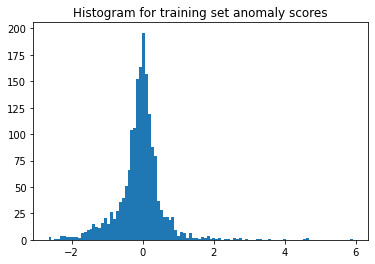

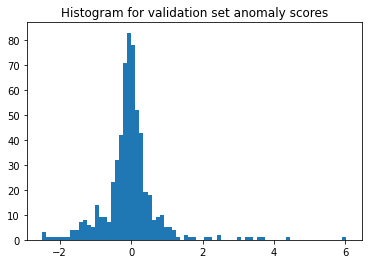

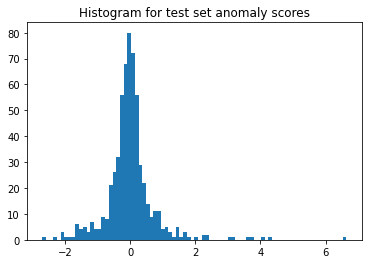

In [34]:
from pyod.models.lscp import LSCP
from tensorflow.keras.optimizers import Adadelta

adadelta = Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07)

#initialise group of heterogeneous OD models 
detector_list = [
    COF(n_neighbors=10, contamination=outlier_ratio),
    AutoEncoder(l2_regularizer=0.3, dropout_rate=0.2, batch_size=32, hidden_neurons=[4, 3, 1, 1, 3, 4], contamination=outlier_ratio, epochs=300, optimizer=adam, random_state=42, preprocessing=False),
    DeepSVDD(epochs=100, optimizer=adadelta, hidden_neurons=[32, 16, 4], batch_size=64, random_state=42, preprocessing=False, contamination=outlier_ratio),
    MO_GAAL(k=10, stop_epochs=100, contamination=outlier_ratio)
]

clf33 = LSCP(detector_list)
clf33.fit(train_arr)
viewOutliers(clf33)

Finding anomalies

In [35]:
def detectAnomalies(lst, threshold, dataName, modelName):
    anomalyIndex = []
    for i in range(0, len(lst)):
        score = lst[i]
        if (score > threshold) or (score < -threshold):
            anomalyIndex.append(i)
    print("Number of anomalies detected in %s for model %s: %d" % (dataName, modelName, len(anomalyIndex)))
    return anomalyIndex

In [36]:
#get important points from original dataset
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 7: #8,9 is failure states
        failurePoints.append(row['Timestep'])

In [37]:
#get all timesteps and state excluding maintenance 
timeData = np.array(dataset['Timestep'].tolist()).transpose()
stateData = np.array(dataset['State'].tolist()).transpose()

In [38]:
#SUOD model
SUOD_threshold = 2
SUOD_train_anomalies = detectAnomalies(train_scores, SUOD_threshold, "training", "SUOD")
SUOD_val_anomalies = detectAnomalies(val_scores, SUOD_threshold, "validation", "SUOD")
SUOD_test_anomalies = detectAnomalies(test_scores, SUOD_threshold, "test", "SUOD")

Number of anomalies detected in training for model SUOD: 4
Number of anomalies detected in validation for model SUOD: 3
Number of anomalies detected in test for model SUOD: 1


In [39]:
#find timesteps and state for anomalies in training set
SUOD_train_anomalies_time = []
SUOD_train_anomalies_state = []
for i in SUOD_train_anomalies:
    timestep = timeData[i]
    currentState = stateData[i]
    SUOD_train_anomalies_time.append(timestep)
    SUOD_train_anomalies_state.append(currentState)
    
#find timesteps for anomalies in validation set
SUOD_val_anomalies_time = []
SUOD_val_anomalies_state = []
for i in SUOD_val_anomalies:
    order = i + numTrain
    timestep = timeData[order]
    currentState = stateData[order]
    SUOD_val_anomalies_time.append(timestep)
    SUOD_val_anomalies_state.append(currentState)
    
#find timesteps for anomalies in test set
SUOD_test_anomalies_time = []
SUOD_test_anomalies_state = []
for i in SUOD_test_anomalies:
    order = i + numTrain+numVal
    timestep = timeData[order]
    currentState = stateData[order]
    SUOD_test_anomalies_time.append(timestep)
    SUOD_test_anomalies_state.append(currentState)

Anomaly time
[151, 423, 940, 1654]
Anomaly state
[3, 4, 3, 4]


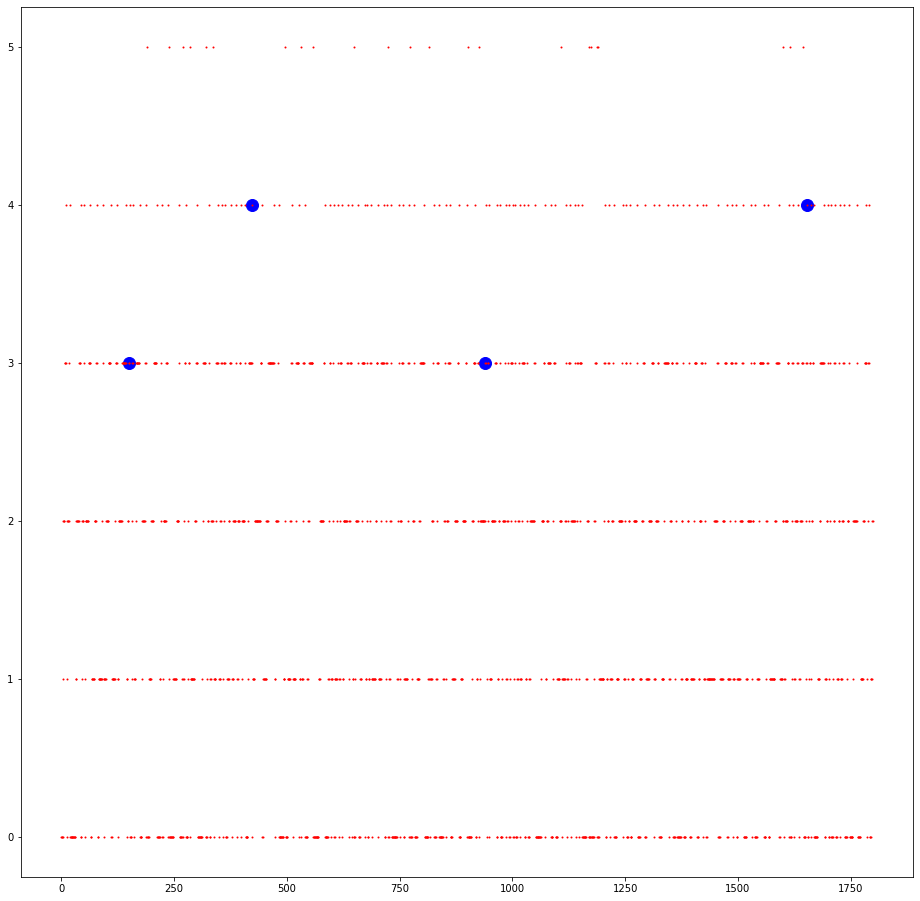

In [40]:
#compare timesteps and state, concatenate and observe 

#training set

print('Anomaly time')
print(SUOD_train_anomalies_time)
print('Anomaly state')
print(SUOD_train_anomalies_state)

plt.figure(figsize=(16,16))
plt.plot(SUOD_train_anomalies_time, SUOD_train_anomalies_state, 'bo', label='anomalies', markersize=12)
plt.plot(timeData[0:numTrain], stateData[0:numTrain], 'ro', label='all', markersize=1)
plt.show()

Anomaly time
[1842, 1890, 2166]
Anomaly state
[3, 5, 3]


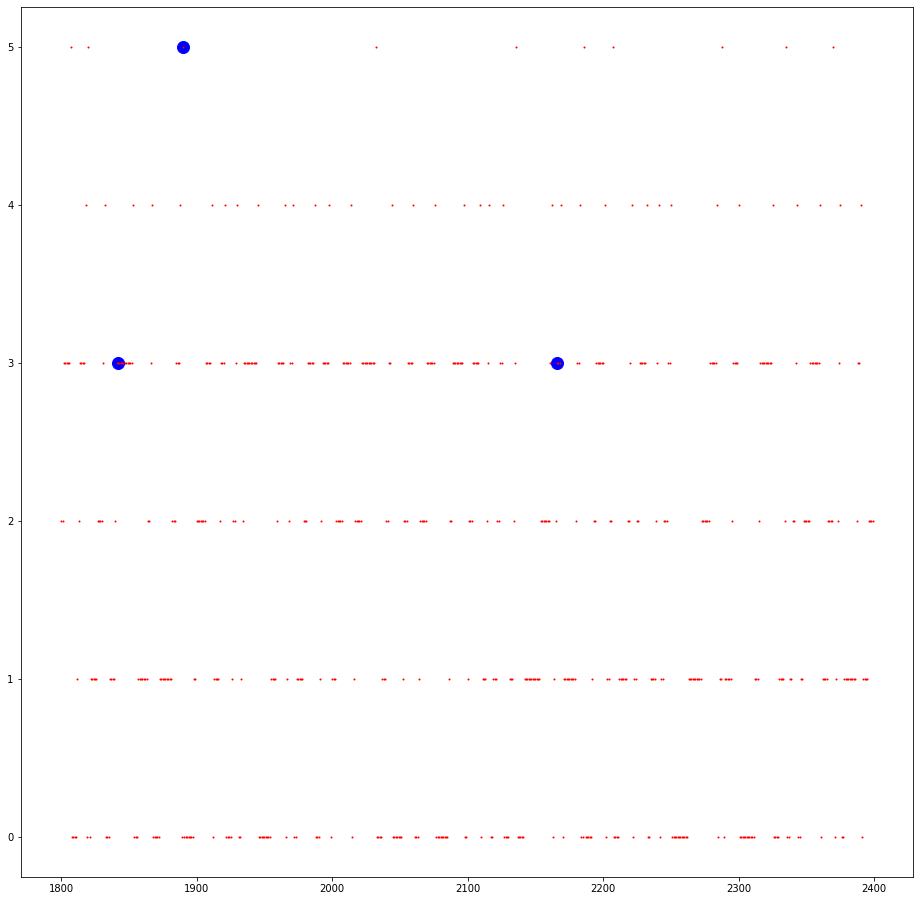

In [41]:
#validation set

print('Anomaly time')
print(SUOD_val_anomalies_time)
print('Anomaly state')
print(SUOD_val_anomalies_state)

plt.figure(figsize=(16,16))
plt.plot(SUOD_val_anomalies_time, SUOD_val_anomalies_state, 'bo', label='anomalies', markersize=12)
plt.plot(timeData[numTrain:numTrain+numVal], stateData[numTrain:numTrain+numVal], 'ro', label='all', markersize=1)
plt.show()

Anomaly time
[2765]
Anomaly state
[3]


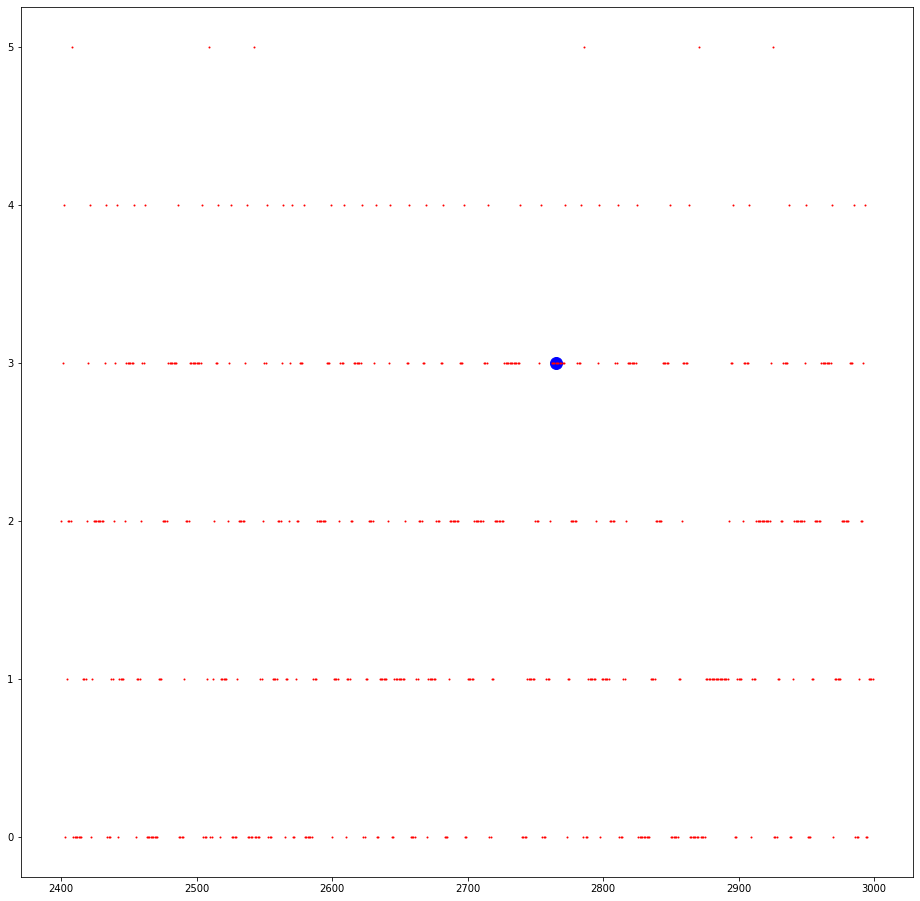

In [42]:
#test set

print('Anomaly time')
print(SUOD_test_anomalies_time)
print('Anomaly state')
print(SUOD_test_anomalies_state)

plt.figure(figsize=(16,16))
plt.plot(SUOD_test_anomalies_time, SUOD_test_anomalies_state, 'bo', label='anomalies', markersize=12)
plt.plot(timeData[numTrain+numVal:], stateData[numTrain+numVal:], 'ro', label='all', markersize=1)
plt.show()

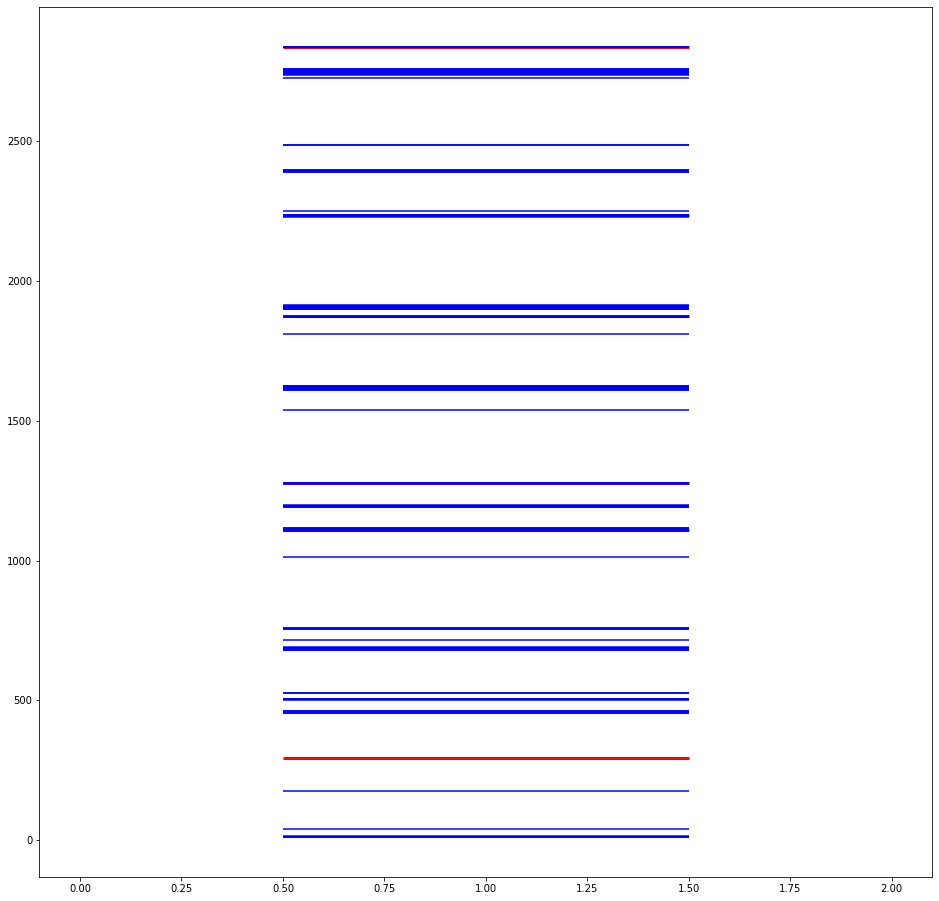

In [61]:
#compare with failure
plt.figure(figsize=(16,16))
plt.eventplot(SUOD_anomalies_time, orientation='vertical', colors='red', linewidths=3)
plt.eventplot(failurePoints, orientation='vertical', colors='blue')
plt.show()

Anomaly detection with LSCP 

In [56]:
train_scores_LSCP = clf33.decision_function(train_arr)
val_scores_LSCP = clf33.decision_function(val_arr)
test_scores_LSCP = clf33.decision_function(test_arr)

In [62]:
#SUOD model
LSCP_threshold = 4
LSCP_train_anomalies = detectAnomalies(train_scores_LSCP, LSCP_threshold, "training", "LSCP")
LSCP_val_anomalies = detectAnomalies(val_scores_LSCP, LSCP_threshold, "validation", "LSCP")
LSCP_test_anomalies = detectAnomalies(test_scores_LSCP, LSCP_threshold, "test", "LSCP")

Number of anomalies detected in training for model LSCP: 5
Number of anomalies detected in validation for model LSCP: 2
Number of anomalies detected in test for model LSCP: 2


In [63]:
#find timesteps and state for anomalies in training set
LSCP_train_anomalies_time = []
LSCP_train_anomalies_state = []
for i in LSCP_train_anomalies:
    timestep = timeData[i]
    currentState = stateData[i]
    LSCP_train_anomalies_time.append(timestep)
    LSCP_train_anomalies_state.append(currentState)
    
#find timesteps for anomalies in validation set
LSCP_val_anomalies_time = []
LSCP_val_anomalies_state = []
for i in LSCP_val_anomalies:
    order = i + numTrain
    timestep = timeData[order]
    currentState = stateData[order]
    LSCP_val_anomalies_time.append(timestep)
    LSCP_val_anomalies_state.append(currentState)
    
#find timesteps for anomalies in test set
LSCP_test_anomalies_time = []
LSCP_test_anomalies_state = []
for i in LSCP_test_anomalies:
    order = i + numTrain+numVal
    timestep = timeData[order]
    currentState = stateData[order]
    LSCP_test_anomalies_time.append(timestep)
    LSCP_test_anomalies_state.append(currentState)

Anomaly time
[151, 437, 582, 712, 1689]
Anomaly state
[3, 2, 3, 3, 3]


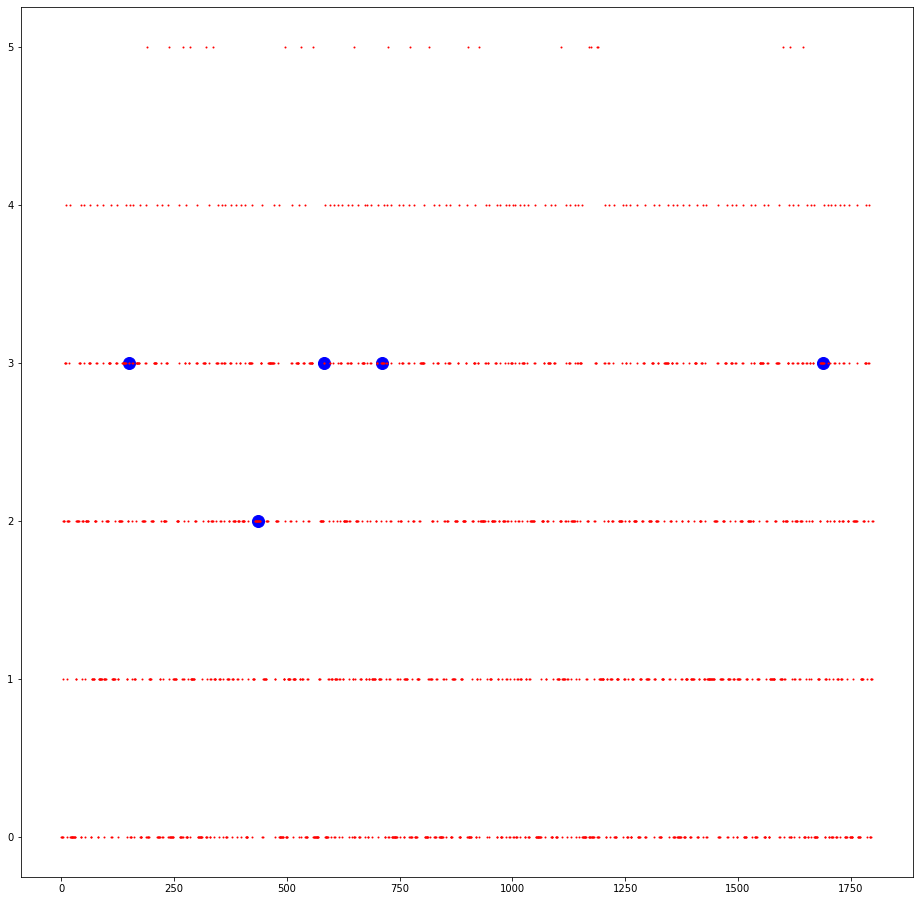

In [64]:
#compare timesteps and state, concatenate and observe 

#training set

print('Anomaly time')
print(LSCP_train_anomalies_time)
print('Anomaly state')
print(LSCP_train_anomalies_state)

plt.figure(figsize=(16,16))
plt.plot(LSCP_train_anomalies_time, LSCP_train_anomalies_state, 'bo', label='anomalies', markersize=12)
plt.plot(timeData[0:numTrain], stateData[0:numTrain], 'ro', label='all', markersize=1)
plt.show()

Anomaly time
[2076, 2288]
Anomaly state
[4, 5]


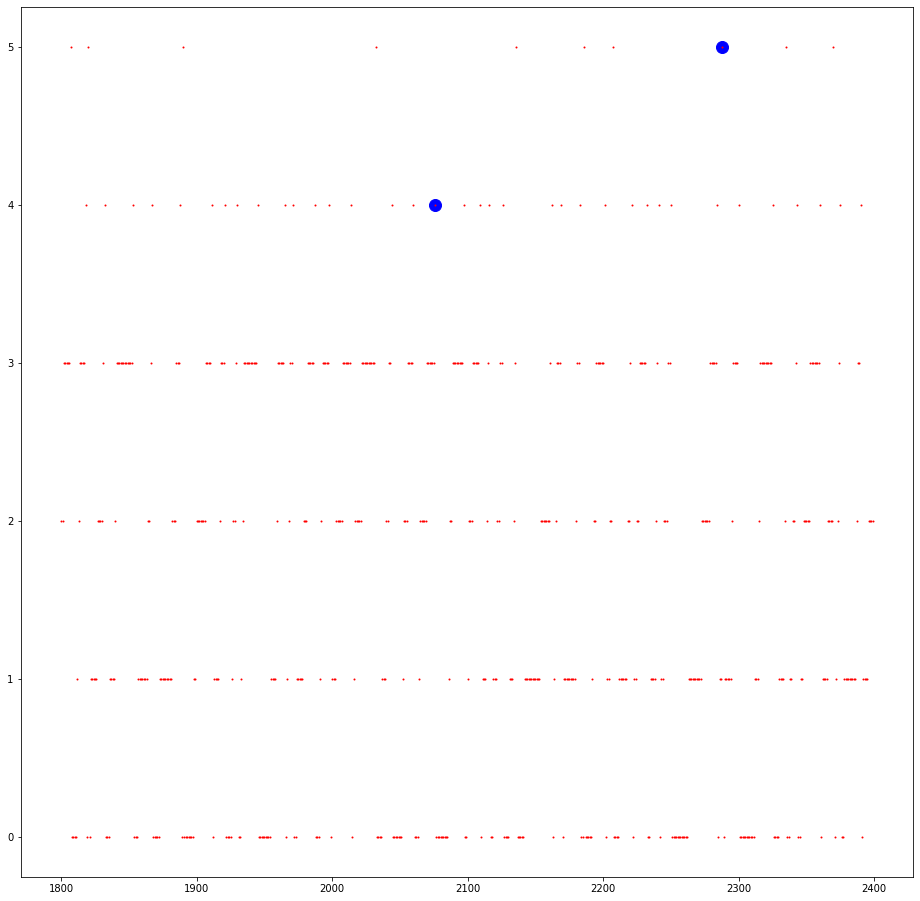

In [65]:
#validation set

print('Anomaly time')
print(LSCP_val_anomalies_time)
print('Anomaly state')
print(LSCP_val_anomalies_state)

plt.figure(figsize=(16,16))
plt.plot(LSCP_val_anomalies_time, LSCP_val_anomalies_state, 'bo', label='anomalies', markersize=12)
plt.plot(timeData[numTrain:numTrain+numVal], stateData[numTrain:numTrain+numVal], 'ro', label='all', markersize=1)
plt.show()

Anomaly time
[2440, 2739]
Anomaly state
[3, 4]


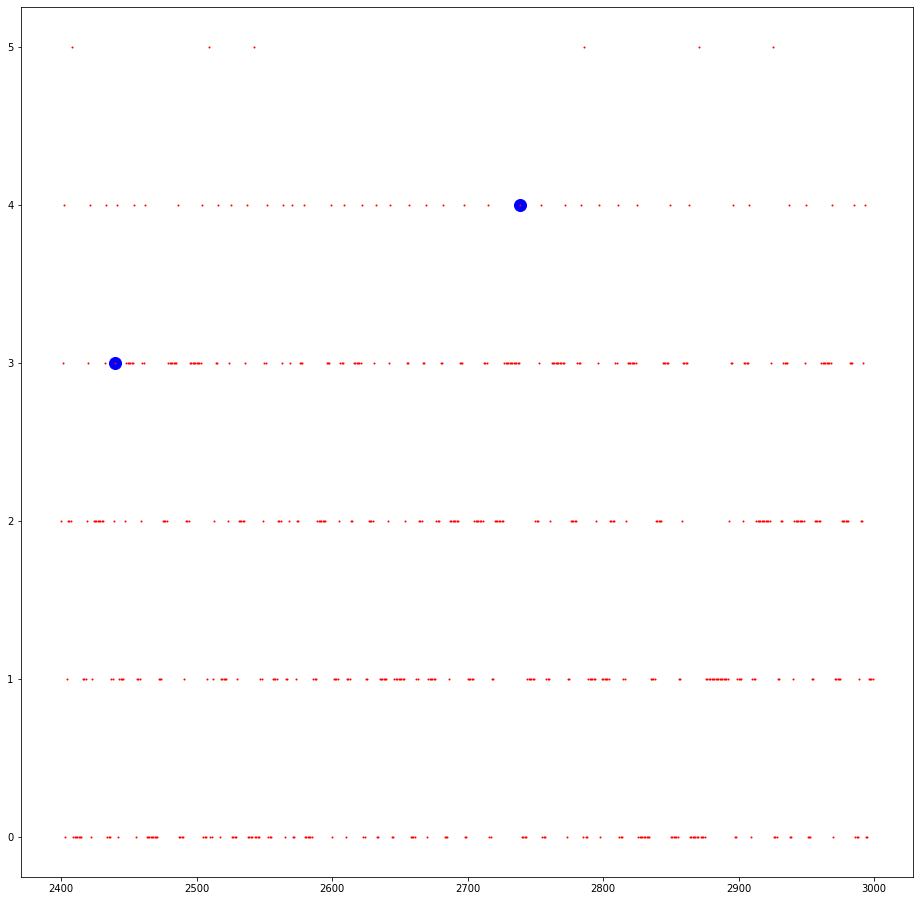

In [66]:
#test set

print('Anomaly time')
print(LSCP_test_anomalies_time)
print('Anomaly state')
print(LSCP_test_anomalies_state)

plt.figure(figsize=(16,16))
plt.plot(LSCP_test_anomalies_time, LSCP_test_anomalies_state, 'bo', label='anomalies', markersize=12)
plt.plot(timeData[numTrain+numVal:], stateData[numTrain+numVal:], 'ro', label='all', markersize=1)
plt.show()

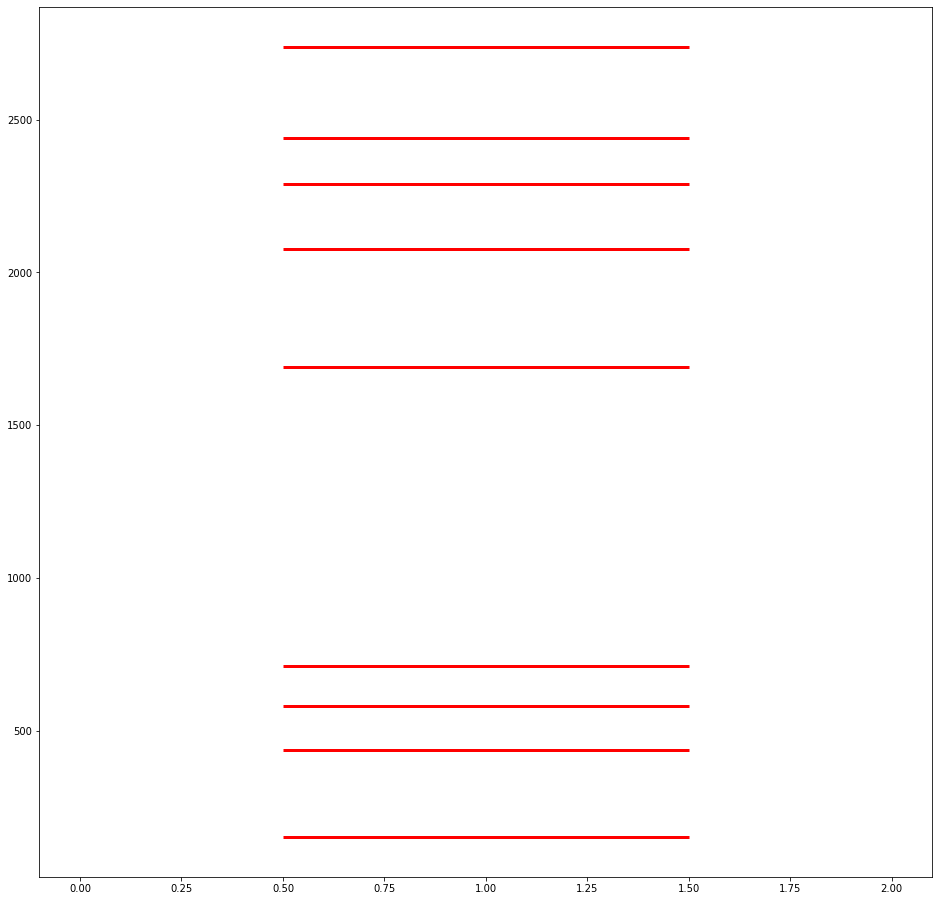

In [67]:
#compare with failure
LSCP_anomalies_time = LSCP_train_anomalies_time + LSCP_val_anomalies_time + LSCP_test_anomalies_time
plt.figure(figsize=(16,16))
plt.eventplot(LSCP_anomalies_time, orientation='vertical', colors='red', linewidths=3)
plt.eventplot(failurePoints, orientation='vertical', colors='blue')
plt.show()